<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=300 height=300 align=left class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2023<br>
<font color=3C99D size=5>
    Practical Assignment 2 - Adversarial Search <br>
<font color=696880 size=4>
    Mohammad Ali Banayeean Zade


____

# Personal Data

In [2]:
# Set your student number
student_number = '40010593'
Name = 'Mohamd Moein'
Last_Name = 'samadi azad'

# Rules

- You should upload just your notebook file.

# Libraries

In [5]:
# import libraries here
import random
import copy
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import output
import time
import os, sys
import time
import pygame
from gui import *
from map import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Q2: Adversarial Search (100 Points)

<font size=4>
Author: Mohammad Ali Banayeean Zade
<br/>
<font color=red>
Please run all the cells.
</font>
</font>
<br/>
</div>

In this problem you must implement a minimax agent to play a game known as Alquerque.

The game has already been implemented for you. You should implement these things:  
Complete the three minimax players (minmax, alpha-beta pruning) and random player classes. For the first minmax player you must create the minimax tree until you reach a desired depth or a cutoff state. Then you must use an evaluation function in `Game` class to score the nodes and find the best next move. For the second one, you must do all the above but using alpha beta pruning algorithm.

*** Note that, the result from the game is a part of your score and a small portion of your score is evaluated based on the quality of your code.


# Game rules:
You can play Alquerque <a href="https://omerkel.github.io/Alquerque/html5/src/">here</a>.
Before starting, each player places their twelve pieces in the two rows closest to them and in the two rightmost spaces in the center row. The game is played in turns, with one player taking red and the other blue.
<ul>
<li> A piece can move from its point to any empty adjacent point that is <b>  connected by a line. </b> </li>
<li> A piece can jump over an opposing piece and remove it from the game, if that opposing piece is adjacent and the point beyond it is empty.</li>
</ul>

<img  
src="https://imageupload.io/ib/Sb359POEfCjUpAL_1698232288.png" alt="demo.png"/>
</br>

*** The goal of the game is to get more score. Players play for 100 round, Finally each player score come from below equation:


$$\displaystyle score=(remain \; pieces)+5×(pieces \; taken \; from \; opponent)$$


The player with higher score win the game.

</br>

# Agents


## Player

Player is base class for game-playing agent. Other agents must inherit this class.

In [6]:
class Player:
    """
    Base class for a game-playing agent.
    You must implement the next_move() method to complete this class.

    Parameters
    ----------
    number : int
        The number of the player. If 1 then this player goes first. Otherwise this
        player goes second.
    """

    def __init__(self, number: int, maxdepth=2):
        self.number = number
        self.maxdepth = maxdepth

    def next_move(self, game):
        raise NotImplementedError("This should be implemented")

## Random Player (5 points)
This player, randomly select a move from the available possible moves.

In [14]:
class Random_Player(Player):
    def next_move(self, game):
        """
        Randomly select a move from the available possible moves.

        Parameters
        ----------
        game : `game.Game`
            An instance of `game.Game` encoding the current state of the
            game.

        Returns
        ----------
        (int, int) or None
            A randomly selected possible move.

        Useful functions:
        ----------
        game.get_possible_moves
        """
        pm = game.get_possible_moves()
        if len(pm) == 0:
          return None
        return random.choice(pm)



## Min-Max Player (30 pints)
In this part, You should implement orginal min max algorithm for `Min_Max_Player` class

In [8]:
class Min_Max_Player(Player):
    def __init__(self, number: int, maxdepth=2):
        self.number = number
        self.maxdepth = maxdepth
    # return other player number
    def other_num(self):
        if self.number == 1:
             return 2
        return 1
    # imp 1 : heuristic score of this player - score of other player
    def choose_move_max(self, game, depth,this_player):
        pm = game.get_possible_moves()
        #cutoff or depth limit
        if depth == self.maxdepth or len(pm) == 0 : return game.get_player_score(self.number) - game.get_player_score(self.other_num())
        # copy game
        optimium = 1000000
        if this_player:
            optimium = -1000000
        # find best move
        for move in pm:
                game_copy = copy.deepcopy(game)
                game_copy.apply(move)
                game_copy.turn += 1

                val = self.choose_move_max(game_copy,depth + 1, not this_player)
                #max this player score
                if this_player and val > optimium:
                    optimium = val

                # enemy try to max his score
                if not this_player and val < optimium:
                    optimium = val

        # return best move and scores for each player.
        return optimium
    def next_move(self, game):
        """
        Parameters
        ----------
        game : `game.Game`
        An instance of `game.Game` encoding the current state of the
        game.

        Returns
        ----------
        (int, int) or None
        A  possible move. First int is the moving piece's location id. Second int is the target location id.

        If None is returned when possible moves are available, it is an automatic forfeit and the player will
        lose the match.

        Useful functions:
        ----------
        game.get_possible_moves
        game.apply
        game.get_player_score
        """
        max_val = -1000000
        best = None
        for move in game.get_possible_moves():
                game_copy = copy.deepcopy(game)
                game_copy.apply(move)
                game_copy.turn += 1
                val = self.choose_move_max(game_copy, 1, False)
                if val > max_val:
                    max_val = val
                    best = move
        return best


## Alpha-Beta Pruning (40 points)
In this part, You should implement alpha beta pruning algorithm.

In [9]:
class Alpha_Beta_Pruning_Player(Player):
    def __init__(self, number: int, maxdepth=2):
        self.number = number
        self.maxdepth = maxdepth
    # return other player number
    def other_num(self):
        if self.number == 1:
             return 2
        return 1

   # imp 1 : heuristic score of this player - score of other player
    def choose_move_max(self, game, depth,this_player,alpha,beta):
        pm = game.get_possible_moves()
        #cutoff or depth limit
        if depth == self.maxdepth or len(pm) == 0 : return game.get_player_score(self.number) - game.get_player_score(self.other_num()),None
        # copy game
        best = None
        optimium = 1000000
        if this_player:
            optimium = -1000000
        # find best move
        for move in pm:
                game_copy = copy.deepcopy(game)
                game_copy.apply(move)
                game_copy.turn += 1
                val,_ = self.choose_move_max(game_copy,depth + 1, not this_player,alpha,beta)
                #max this player score
                if this_player:
                    if val > optimium:
                        optimium = val
                        best = move
                    alpha = max(alpha, optimium)
                    if beta <= alpha:
                        return 1000000,None


                # enemy try to max his score

                if not this_player:
                    if val < optimium:
                        optimium = val
                        best =move
                    beta = min(beta, optimium)
                    if beta <= alpha:
                        return -1000000,None


        # return best move and scores for each player.
        return optimium,best


    def next_move(self, game):
        """
        Parameters
        ----------
        game : `game.Game`
        An instance of `game.Game` encoding the current state of the
        game.

        Returns
        ----------
        (int, int) or None
        A possible move. First int is the moving piece's location id. Second int is the target location id.

        If None is returned when possible moves are available, it is an automatic forfeit and the player will
        lose the match.


        Useful functions:
        ----------
        game.get_possible_moves
        game.apply
        game.get_player_score
        """

        val_self,move = self.choose_move_max(game,0,True,-1000000,1000000)
        return move

# Game
All the game actions happen in this class. Don't change this codes. You can read the code to unserstand what it exactly does.

*** Notice: You should implement `get_player_score()` function here.

In [10]:
class Game:
    def __init__(self, player_1, player_2):
        """
        Parameters:
        ----------
        player_1: It is first player. From Player classes

        player_2: It is second player. From Player classes
        """
        self.map = OriginalMap(220, 140, 200, 200, 4, 4)

        self.player1 = player_1
        self.player2 = player_2

        self.turn = 0

        self.player1_pieces = [i for i in range(12)]
        for i in self.player1_pieces:
            self.map.assign_point(i, PointStatus.player_1)

        self.player2_pieces = [i for i in range(13, 25)]
        for i in self.player2_pieces:
            self.map.assign_point(i, PointStatus.player_2)

    def get_active_player(self):
        return self.player1 if self.turn % 2 == 1 else self.player2

    def tick(self):
        self.turn += 1
        game_copy = copy.deepcopy(self)
        player = self.get_active_player()
        move = player.next_move(game_copy)

        if self.is_move_valid(move):
            self.apply(move)

    def is_move_valid(self, move):
        if move is not None:
            if move[0] in self.get_player_pieces(self.turn % 2):
                return True
            else:
                return False

    def get_possible_moves(self):
        possible_moves = []
        pieces_available = self.player1_pieces if self.turn % 2 == 1 else self.player2_pieces
        for piece_id in pieces_available:
            piece = self.map.id_to_point(piece_id)

            for i in range(-2, 3):
                for j in range(-2, 3):
                    dest_row = piece[0] + i
                    dest_column = piece[1] + j
                    if self.map.is_point_valid(dest_row, dest_column):
                        dest_id = self.map.point_to_id(dest_row, dest_column)
                        if self.map.can_move(piece_id, dest_id):
                            possible_moves.append((piece_id, dest_id))

        return possible_moves

    def apply(self, move):
        if move is not None:
            outcomes = self.map.apply_move(move)

            moving_player_pieces = self.player1_pieces if self.turn % 2 == 1 else self.player2_pieces
            waiting_player_pieces = self.player2_pieces if self.turn % 2 == 1 else self.player1_pieces

            for outcome in outcomes:
                # Some piece died
                if outcome[1] == -1:
                    assert outcome[0] in waiting_player_pieces
                    waiting_player_pieces.remove(outcome[0])
                # A piece moved
                else:
                    assert outcome[0] in moving_player_pieces
                    moving_player_pieces.remove(outcome[0])
                    moving_player_pieces.append(outcome[1])

    def get_player_pieces(self, number):
        if number == 1:
            return self.player1_pieces
        else:
            return self.player2_pieces

    def get_player_score(self, number):
        '''
        Calculate the heuristic value of a game state from the point of view of the given player.
        Parameters:
        ----------
        number: show given player number.

        Useful functions:
        ----------
        game.get_player_pieces
        '''
        if number == 1:
            return len(self.get_player_pieces(1)) + 5*(12 - len(self.get_player_pieces(2)))
        return len(self.get_player_pieces(2)) + 5*(12 - len(self.get_player_pieces(1)))


    def render(self, surface):
        self.map.render(surface)


# Test agents (25 points)


In [11]:
# Don't change this cell

import matplotlib.pyplot as plt
def visualize(game, display, screen):
    game.render(screen)
    display.flip()
    view = pygame.surfarray.array3d(screen)
    view = view.transpose([1, 0, 2])
    img_bgr = cv2.cvtColor(view, cv2.COLOR_RGB2BGR)
    cv2_imshow(img_bgr)

In [12]:
# Don't change this cell
# By calling this function, the game start and you can track the game by using graphics = True

SCREEN_WIDTH = 640
SCREEN_HEIGHT = 480
def start_game(game: Game, graphics=True):
  '''
    Parameters:
    ----------
    game: instance of `Game` class.
    graphics: If True, show graphic of the game.
  '''

  pygame.init()
  screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
  display = pygame.display
  done = False

  # White background
  background_color = (255, 255, 255)
  counter = 0

  while not done:
    counter += 1
    screen.fill(background_color)
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            done = True

    if counter >= 1:
        game.tick()

    if counter >= 101:
        break

    if graphics:
    # can change this to have better visualizion
      visualize(game, display=display, screen=screen)

  player1_score = game.get_player_score(1)
  player2_score = game.get_player_score(2)
  if player1_score > player2_score:
      print("Player 1 wins")
      return 1
  elif player2_score > player1_score:
      print("Player 2 wins")
      return 2
  else:
      print("It's a draw")
      return 0



### Two random player

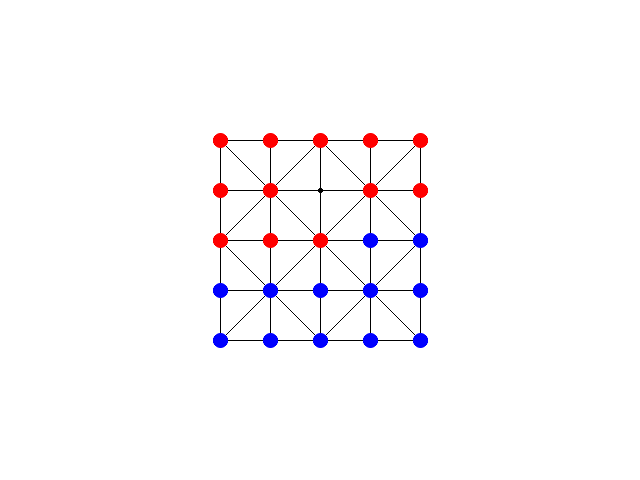

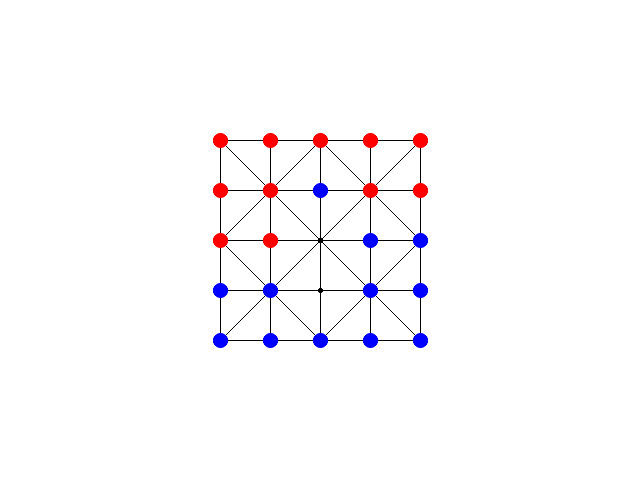

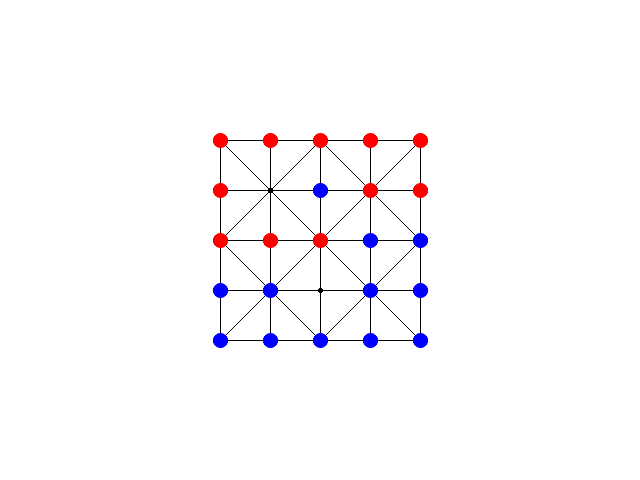

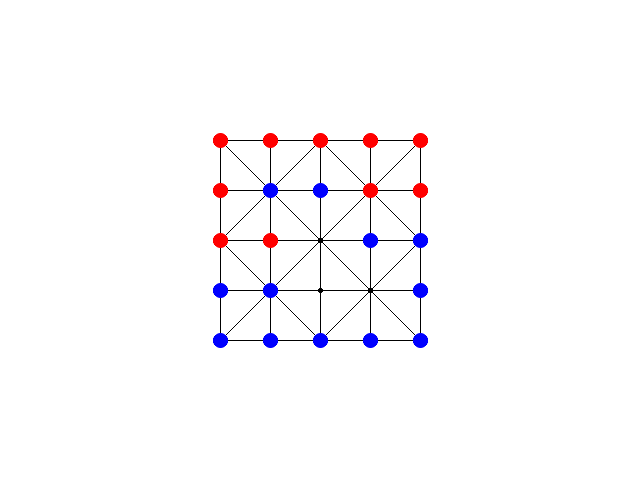

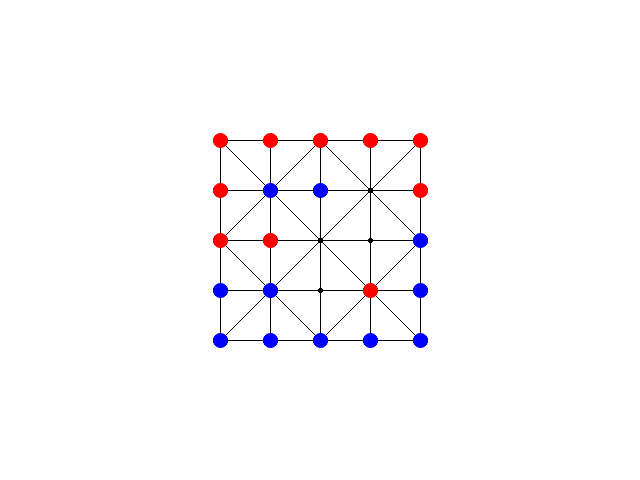

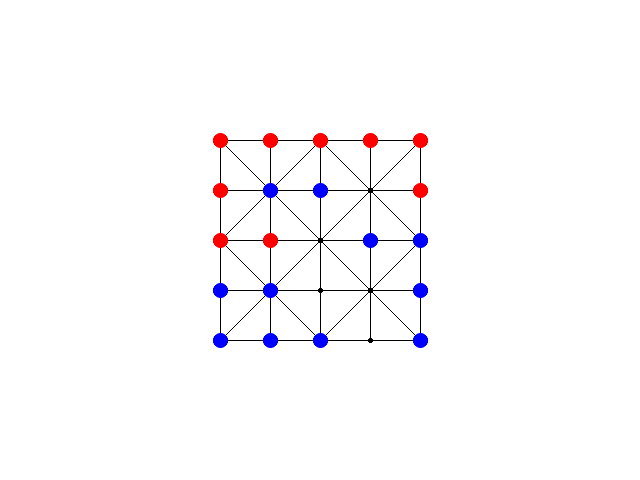

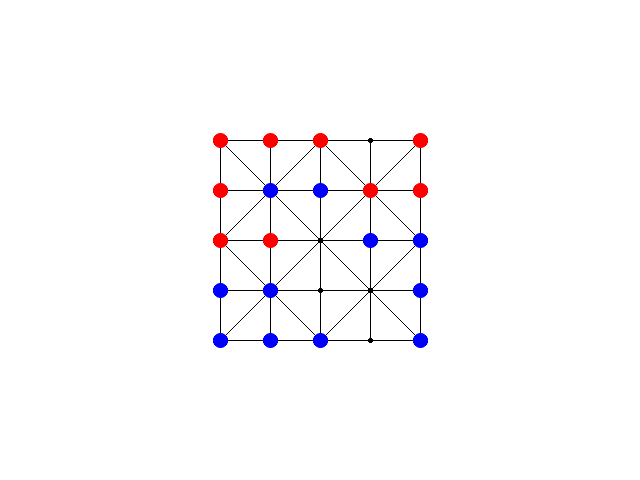

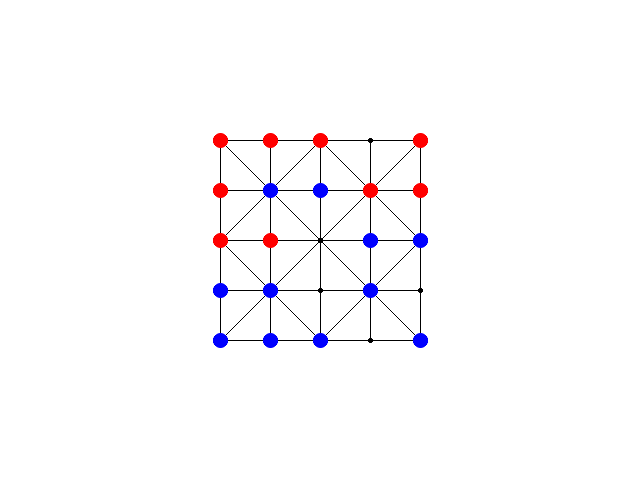

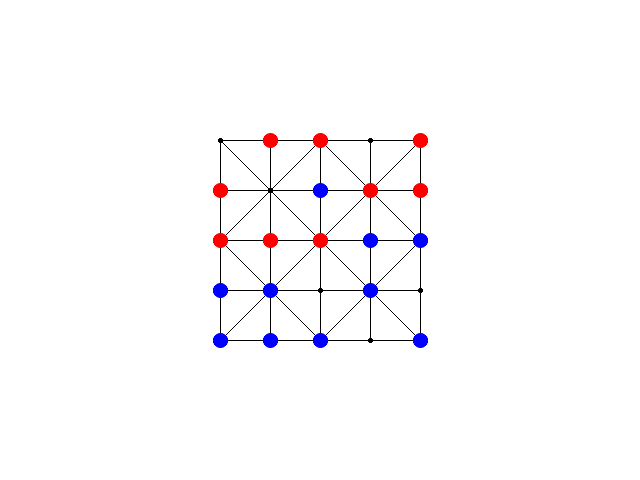

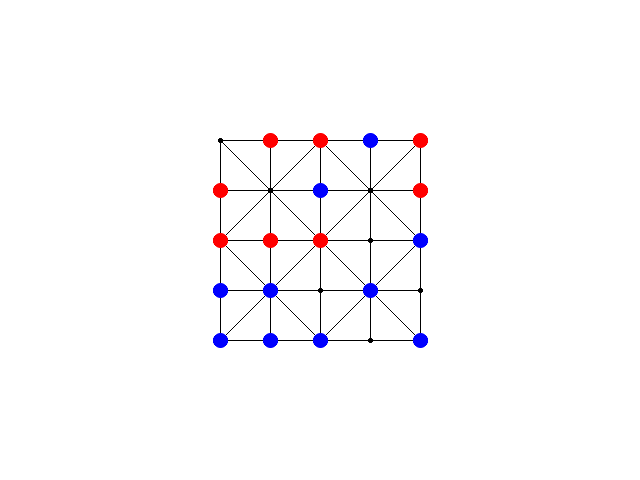

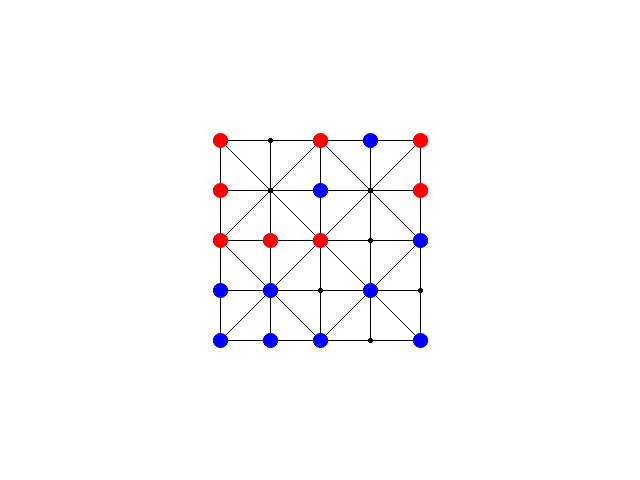

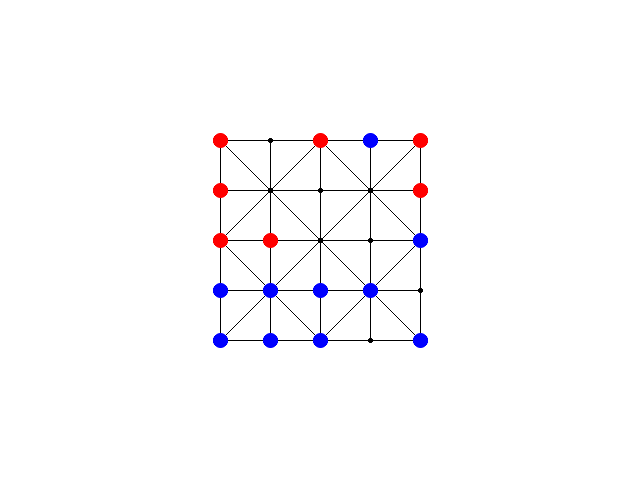

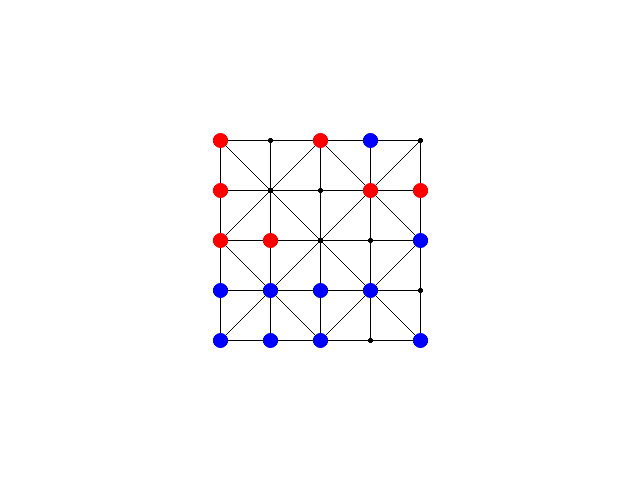

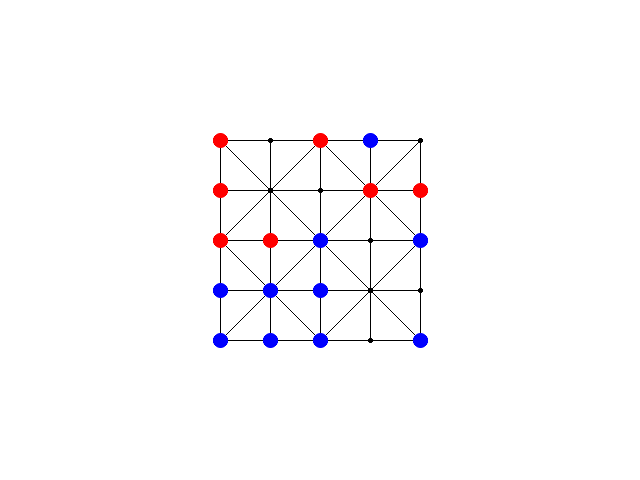

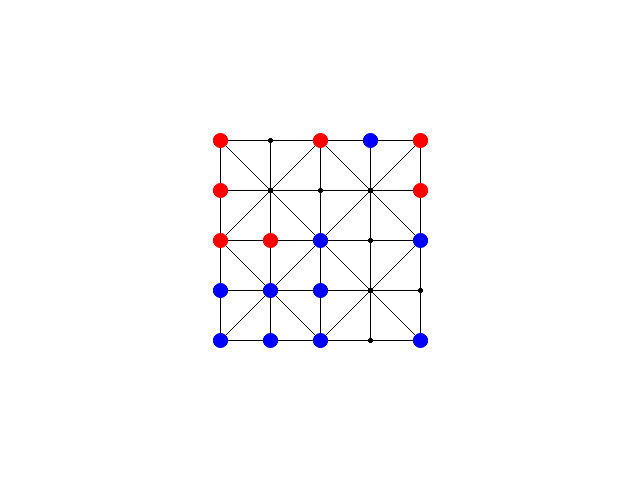

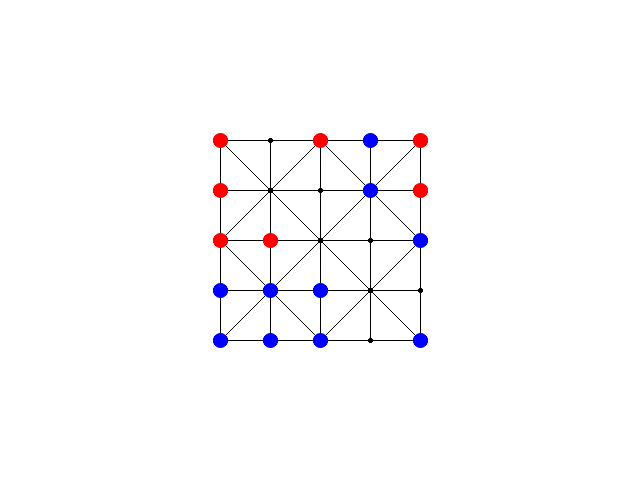

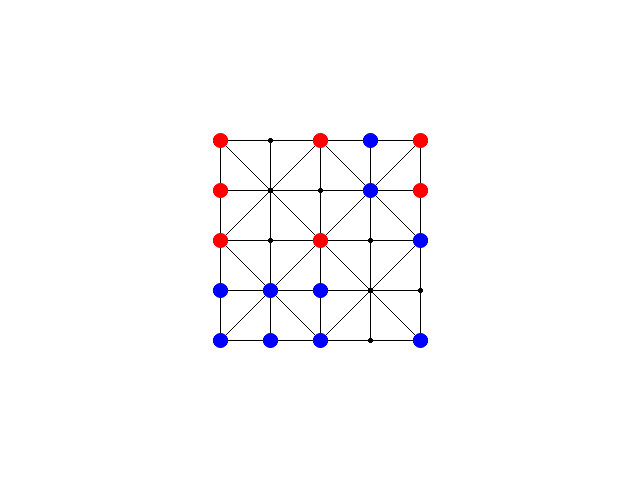

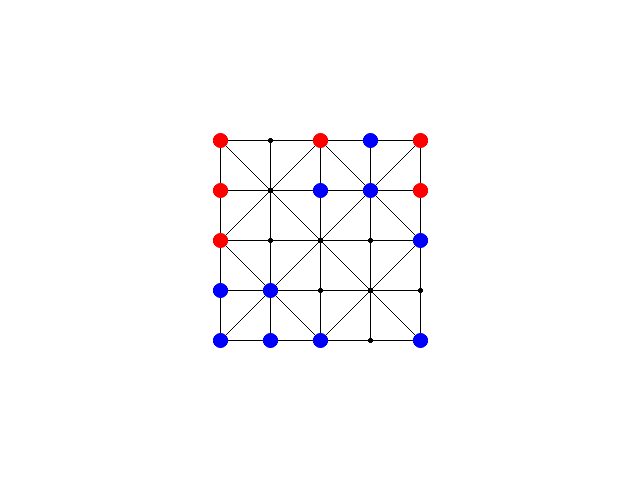

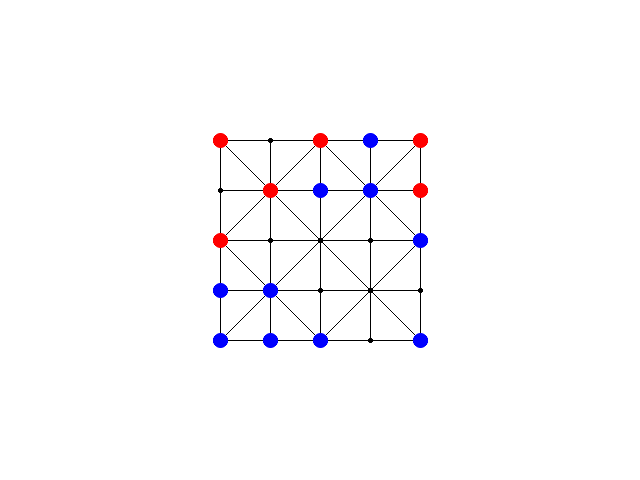

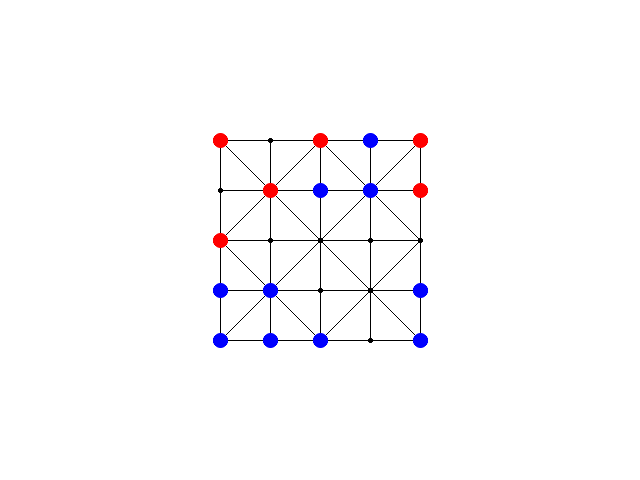

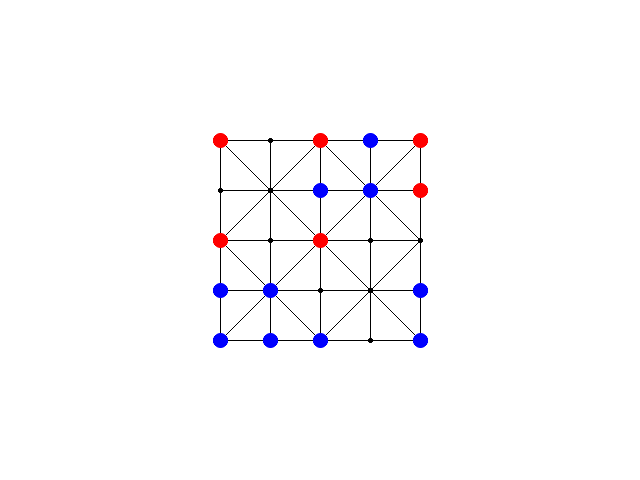

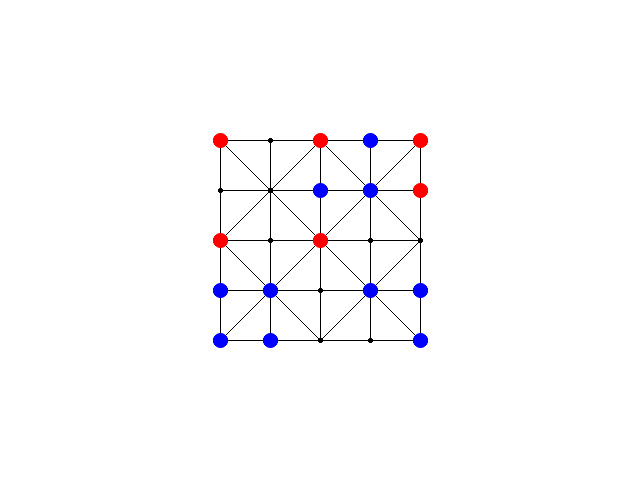

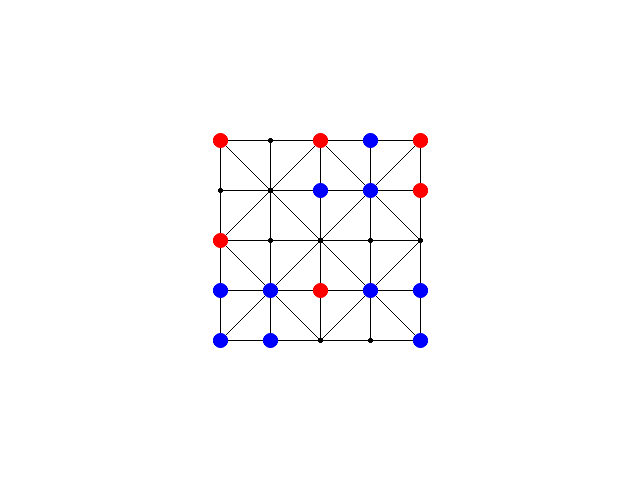

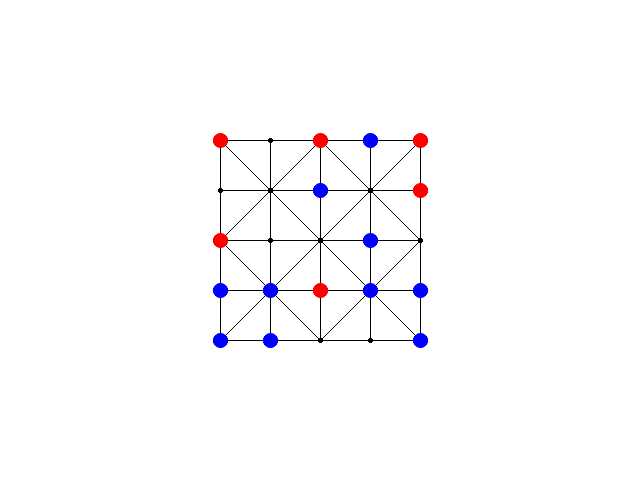

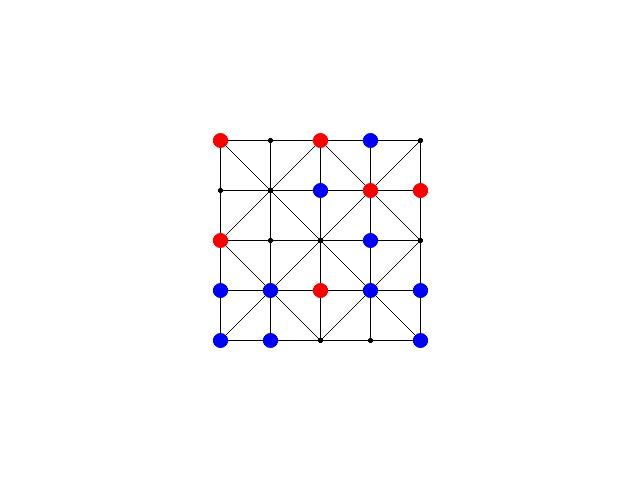

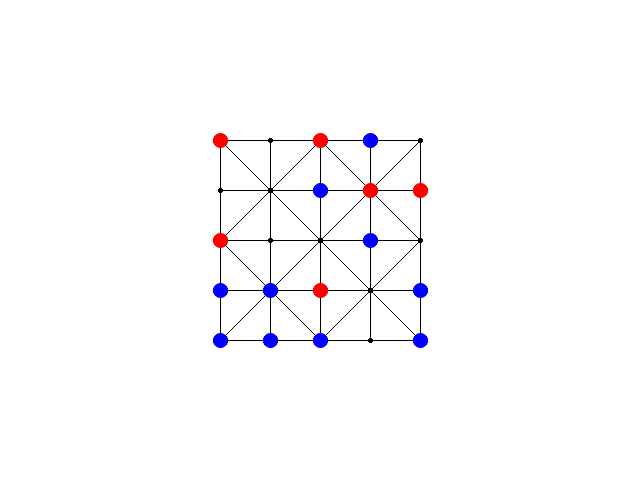

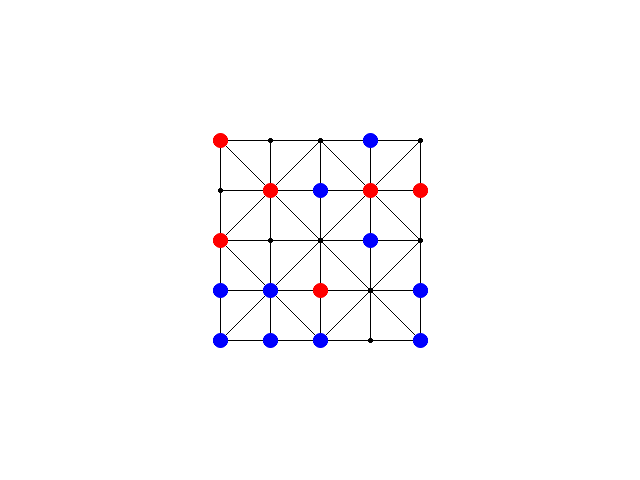

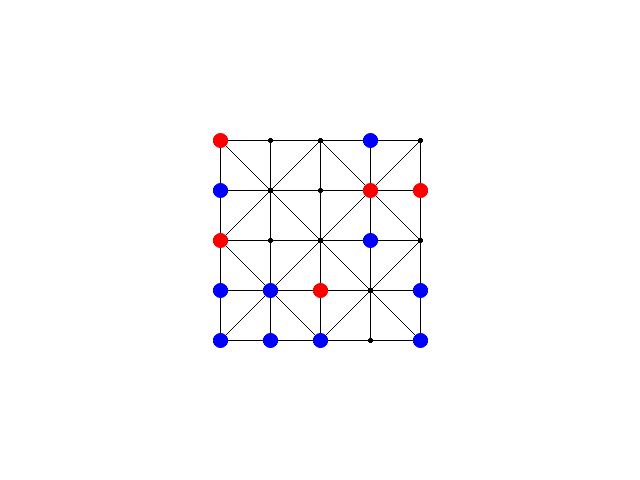

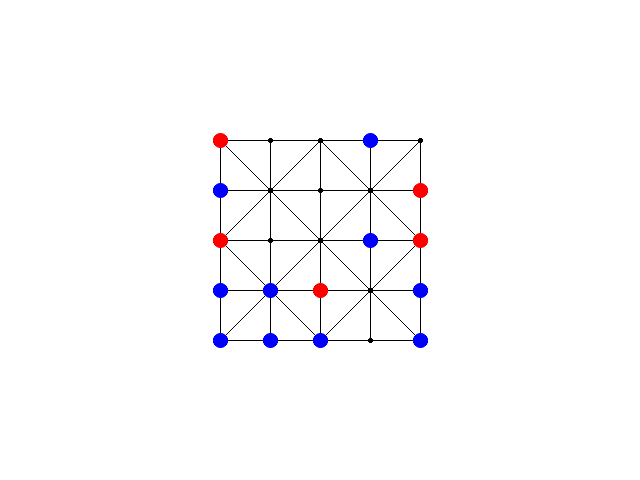

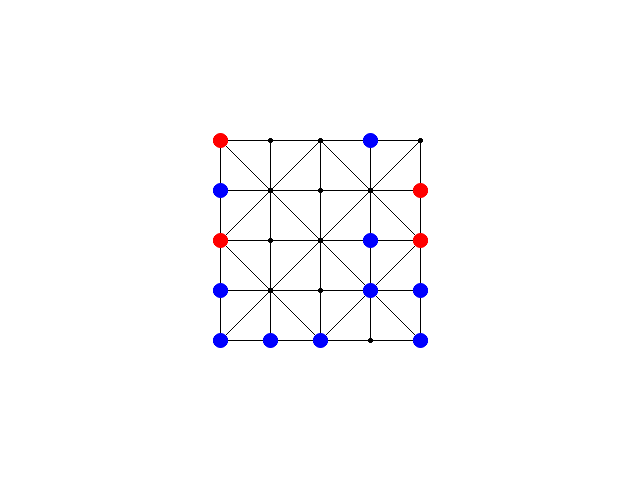

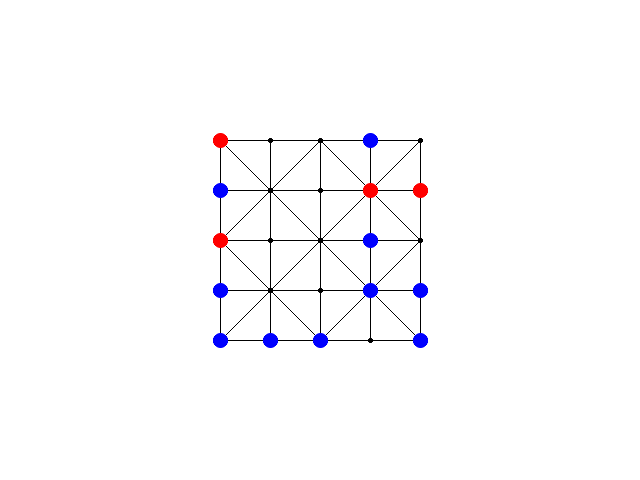

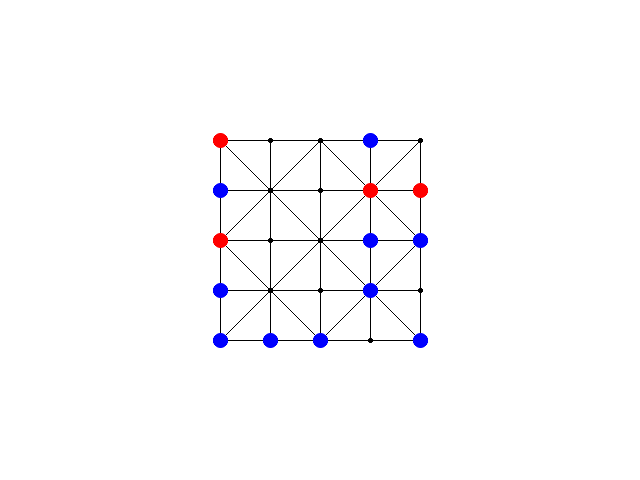

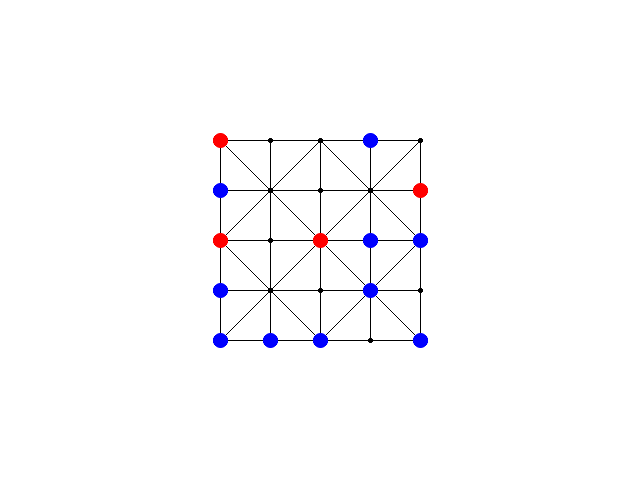

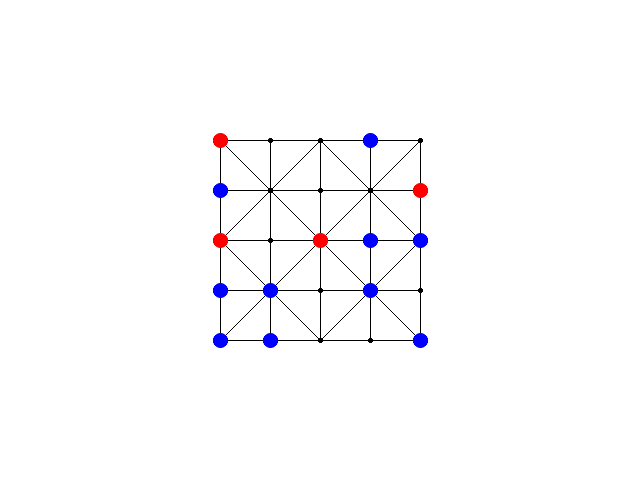

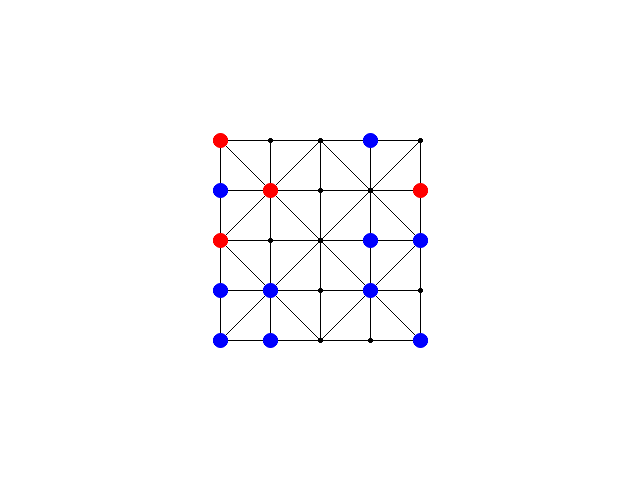

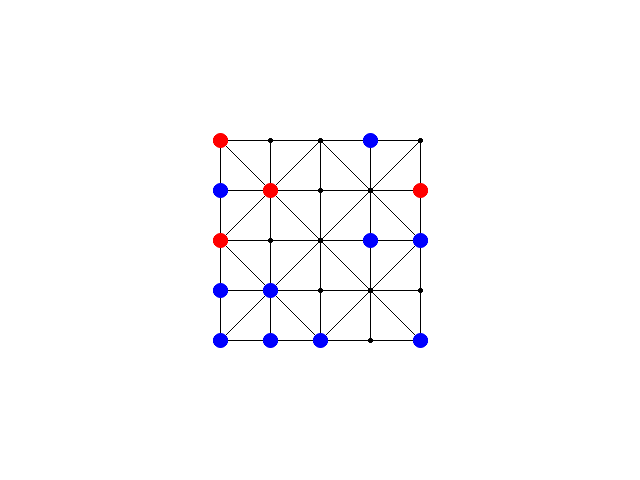

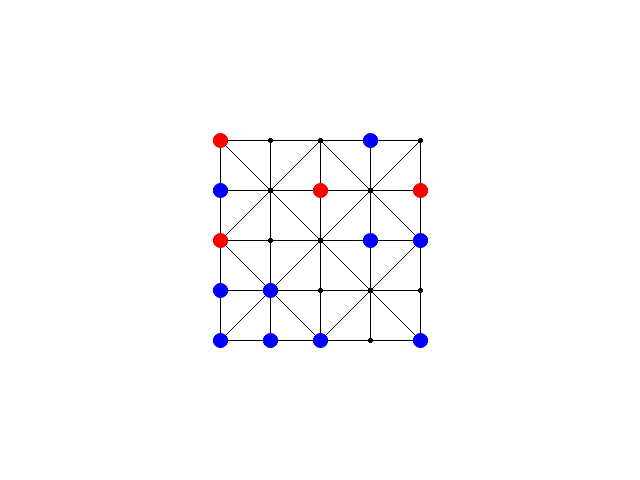

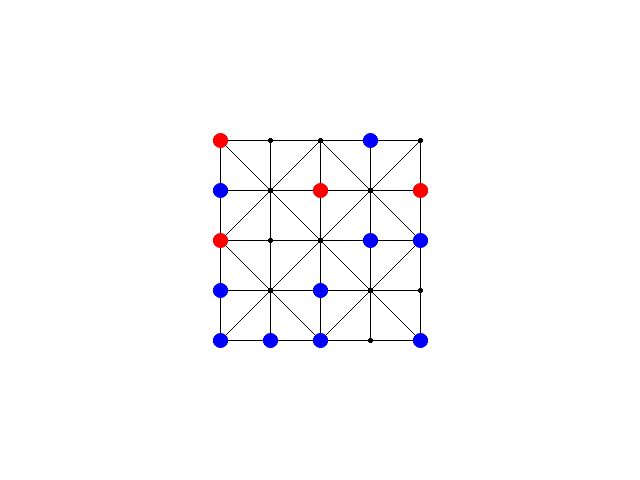

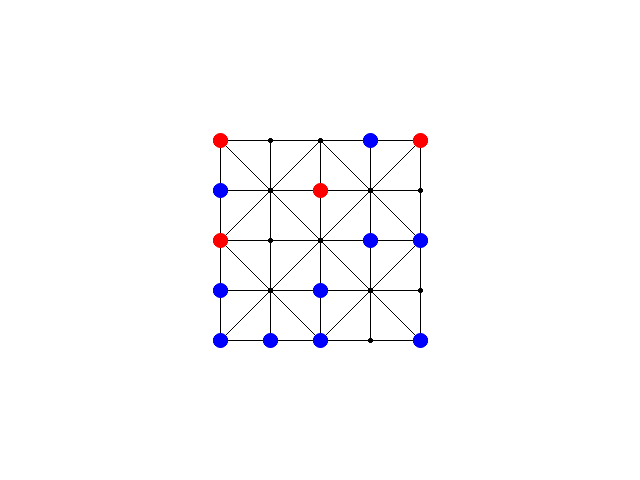

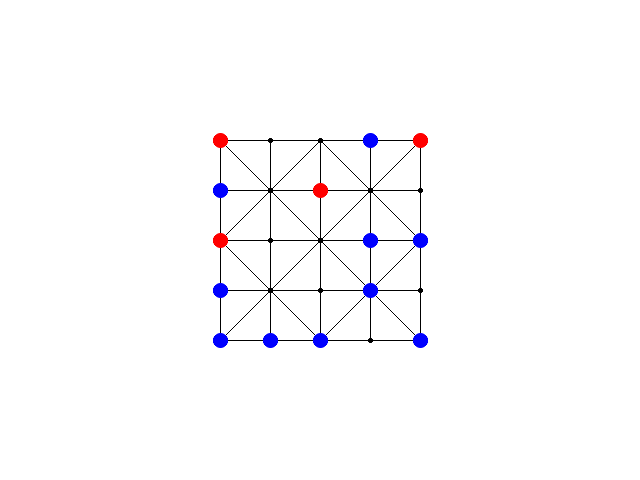

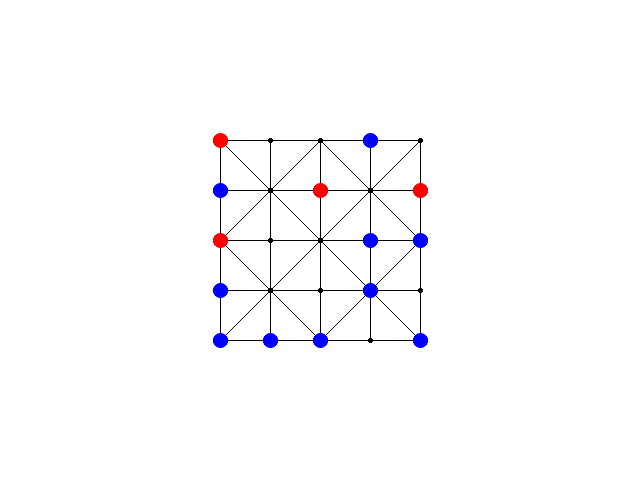

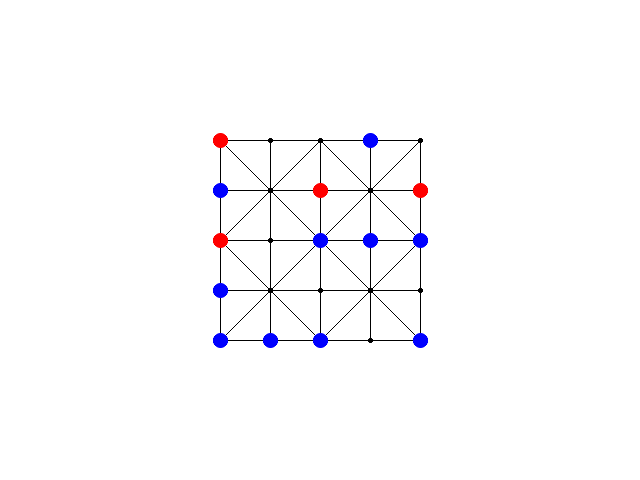

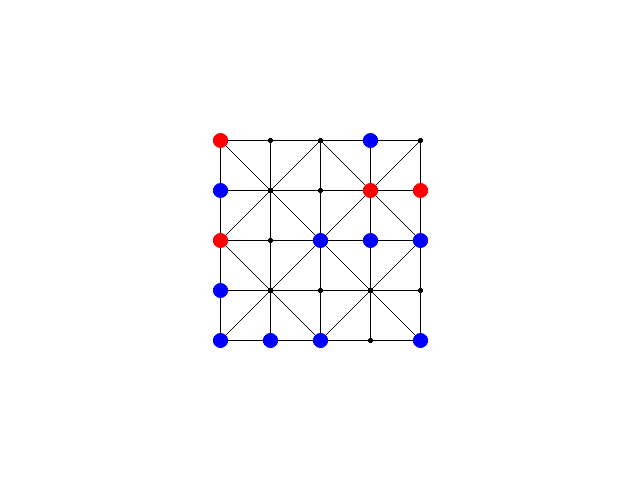

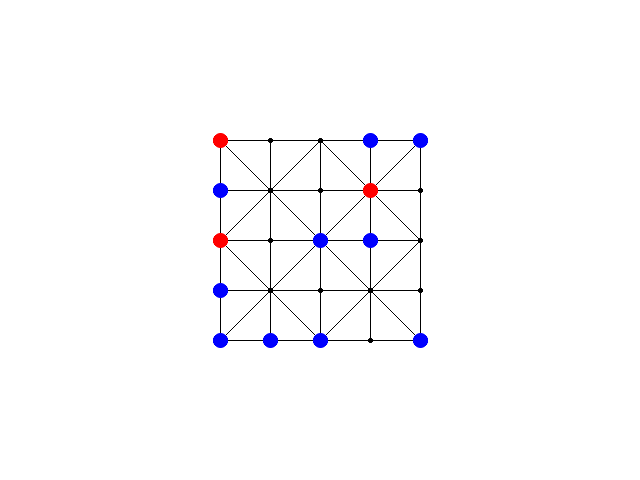

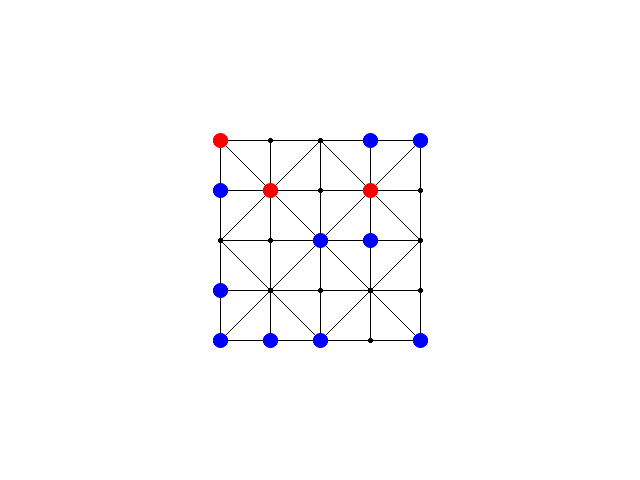

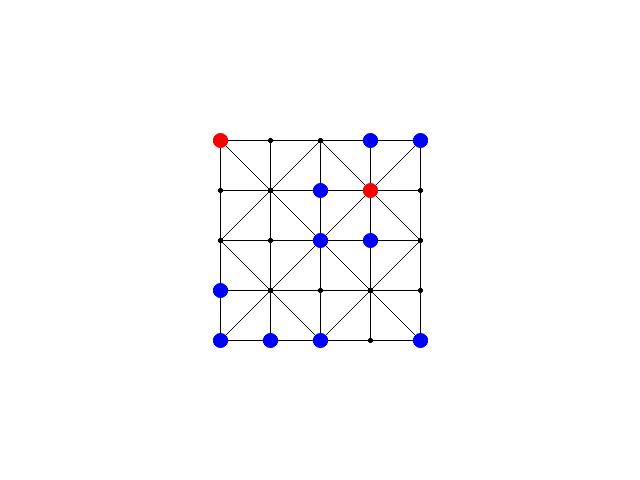

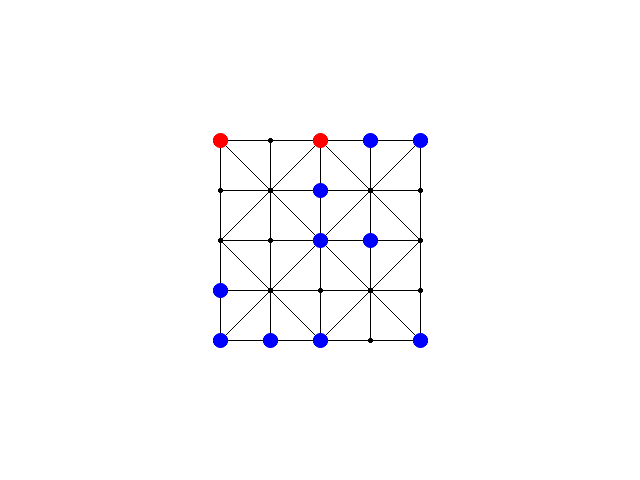

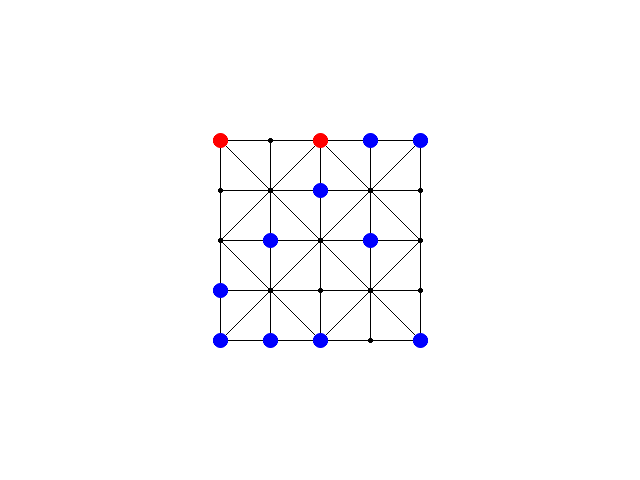

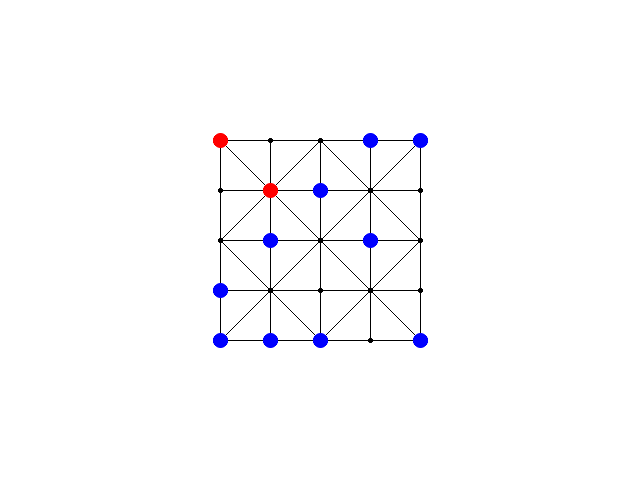

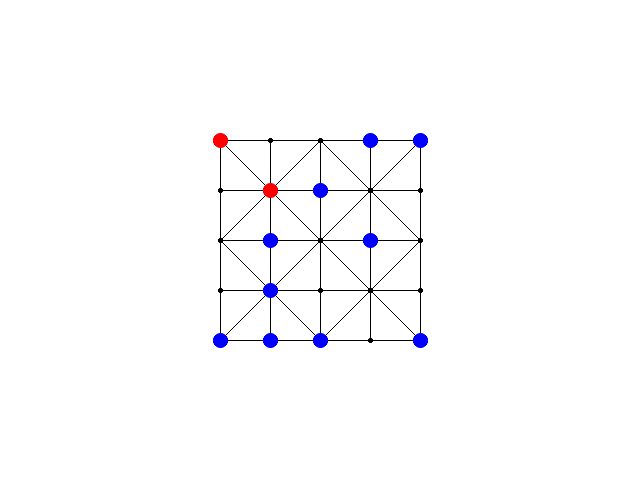

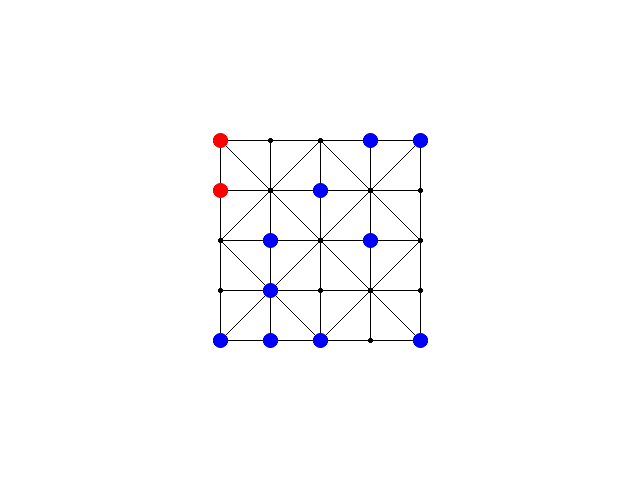

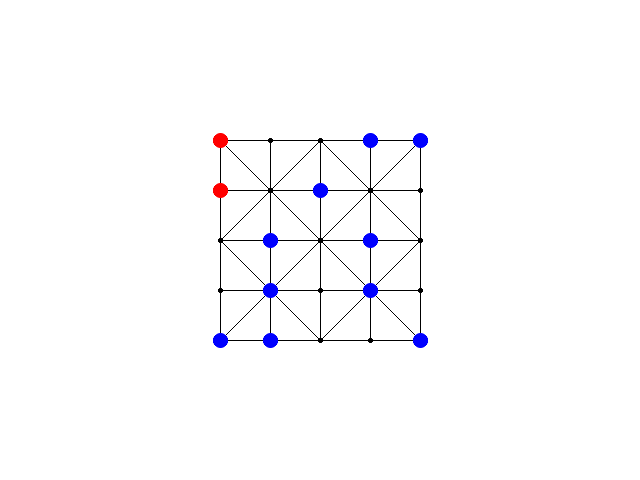

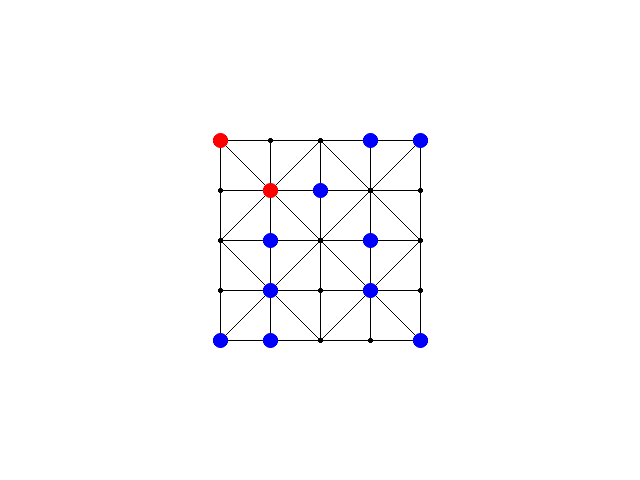

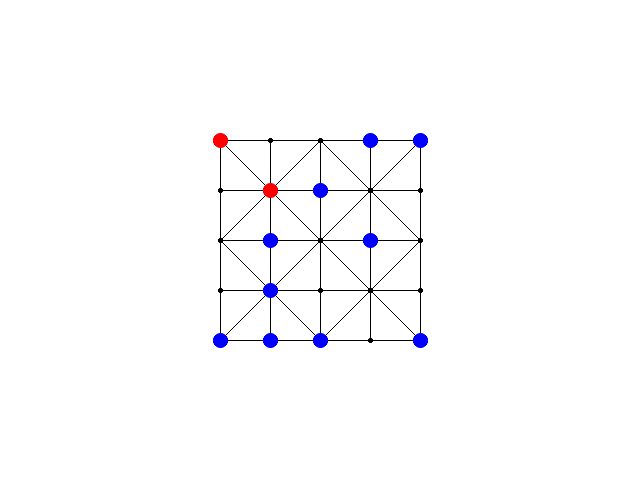

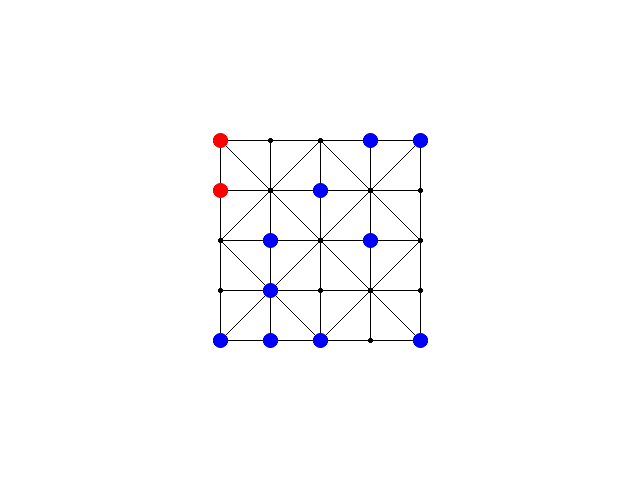

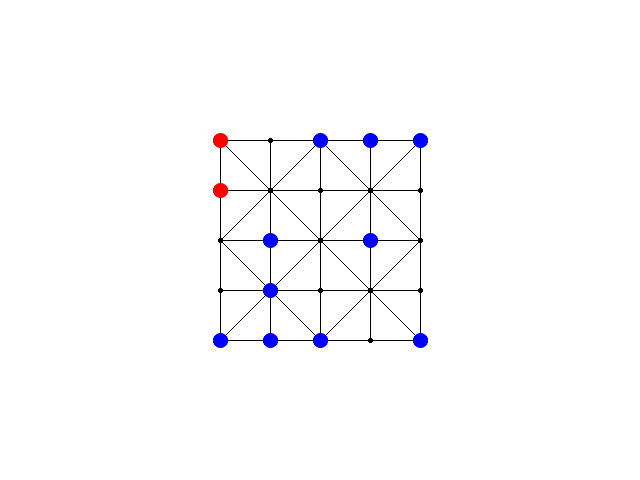

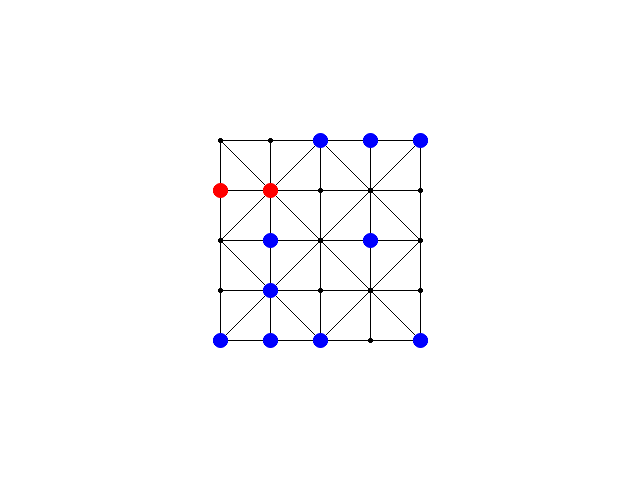

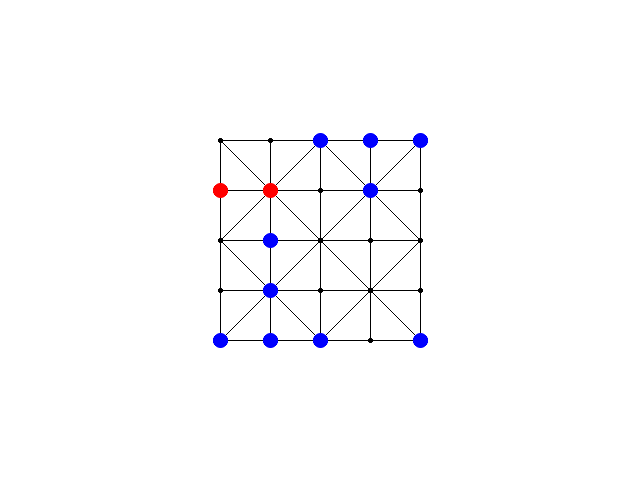

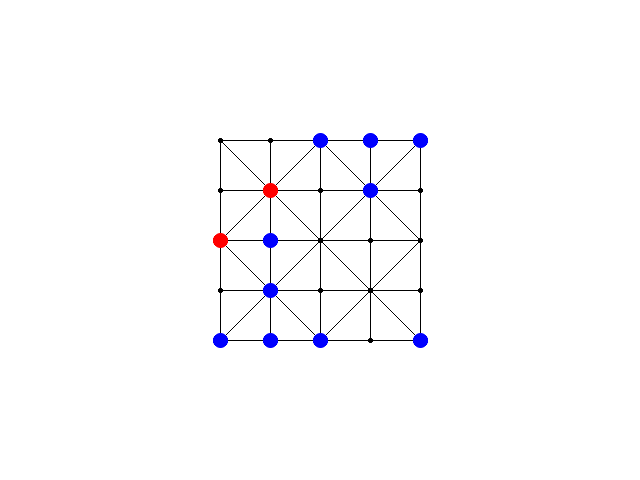

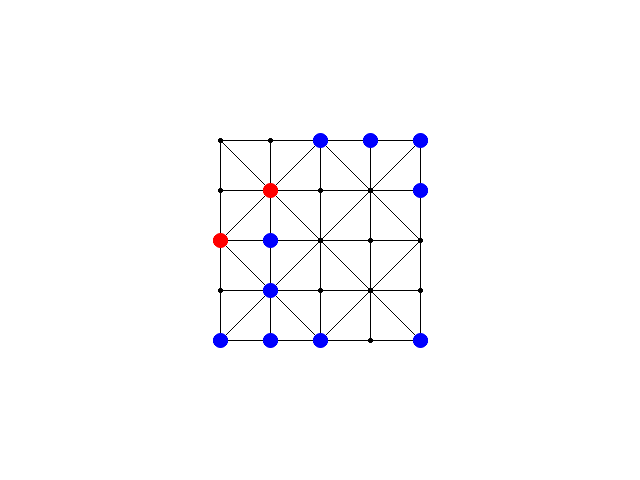

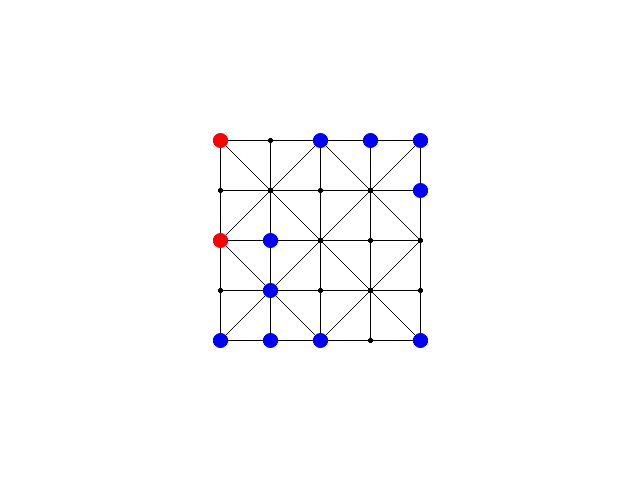

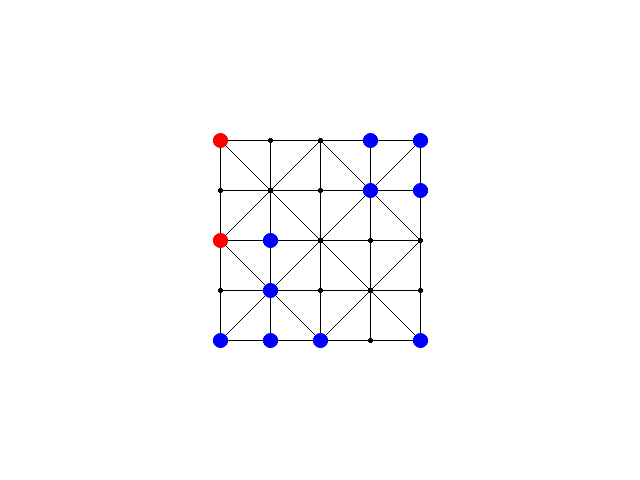

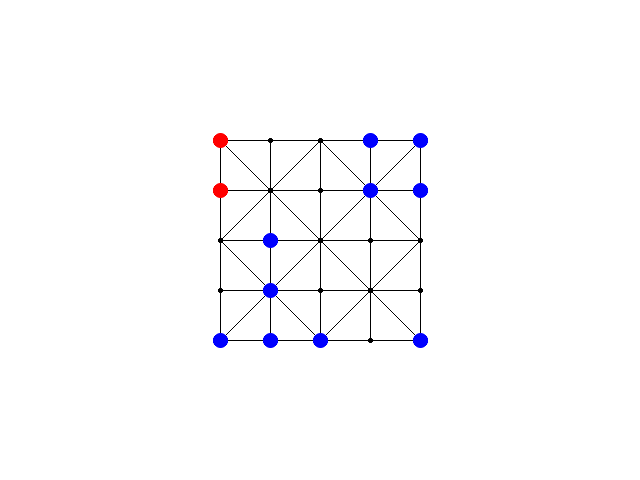

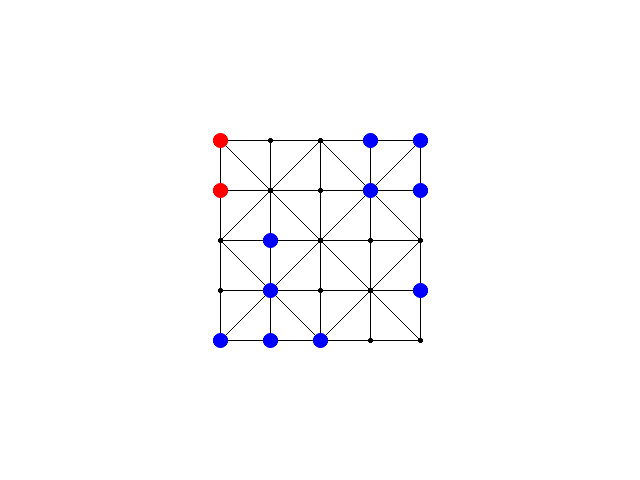

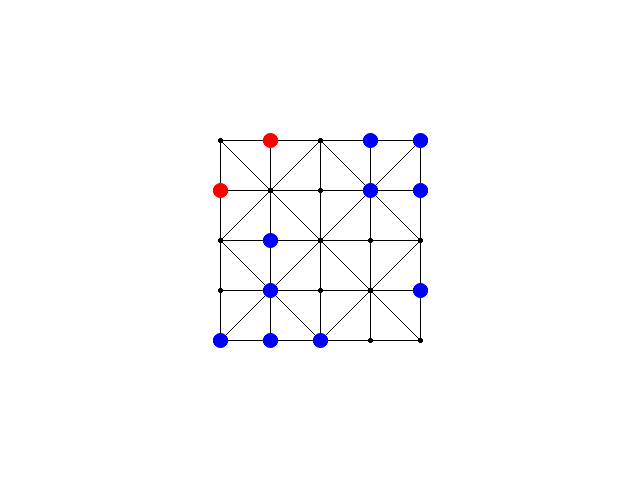

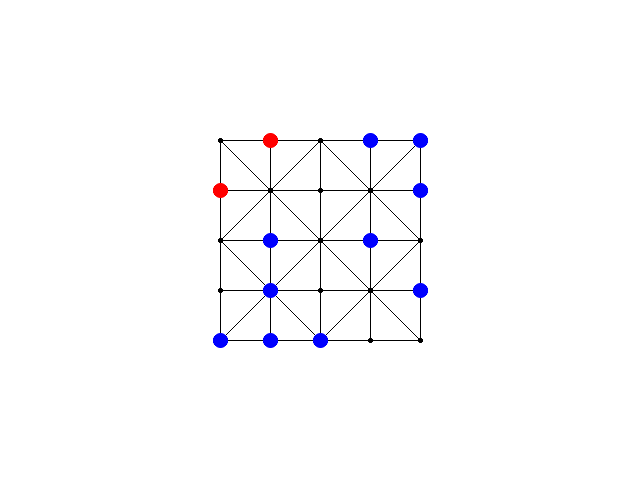

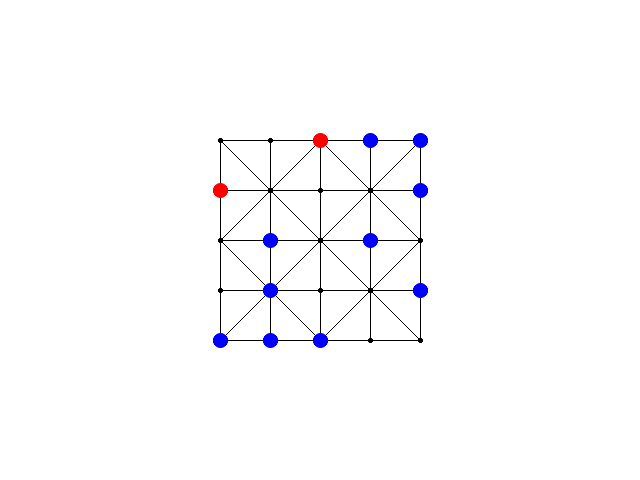

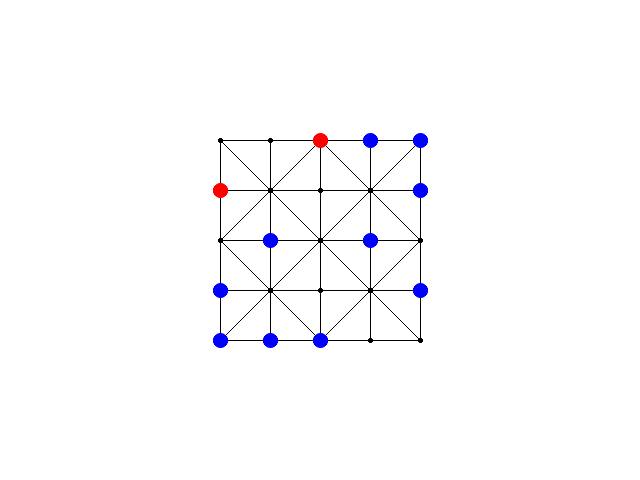

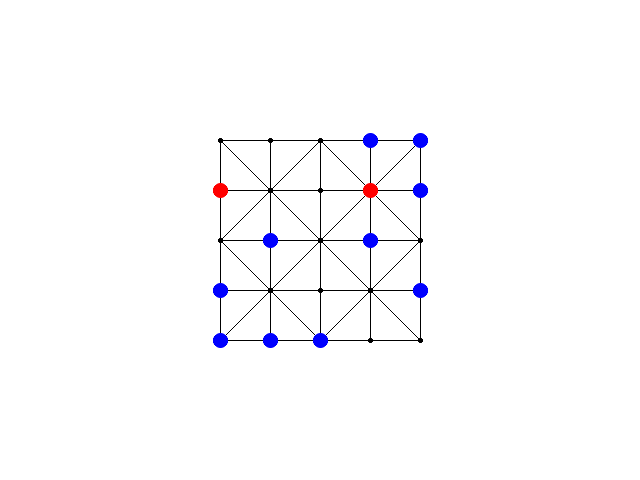

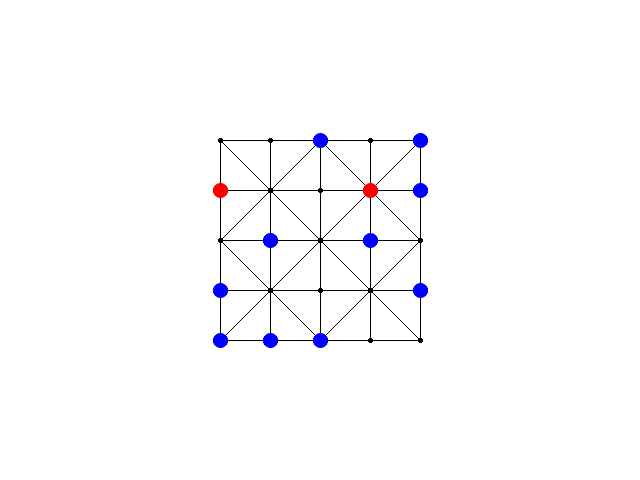

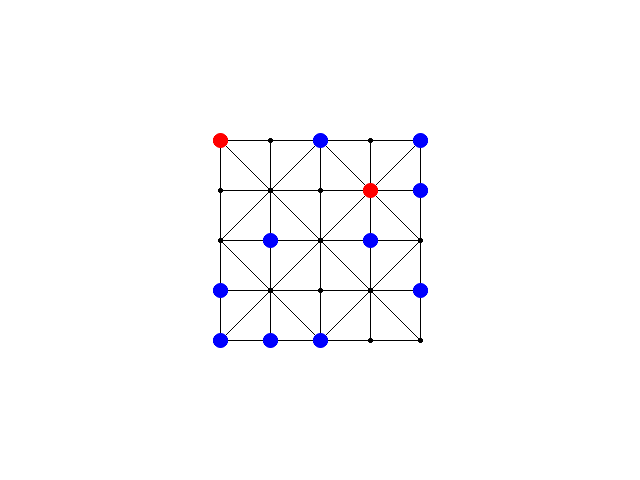

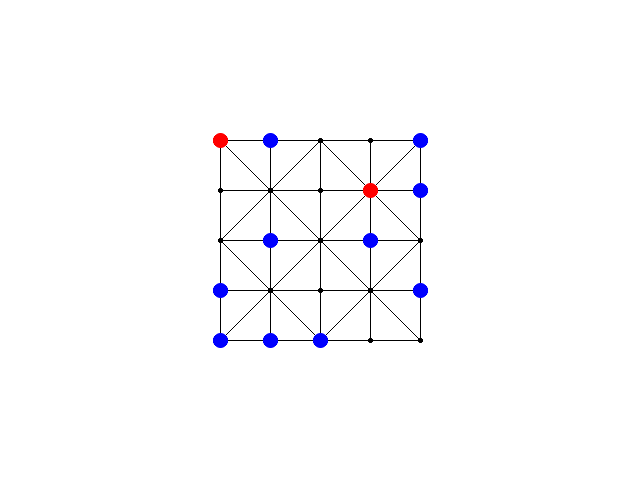

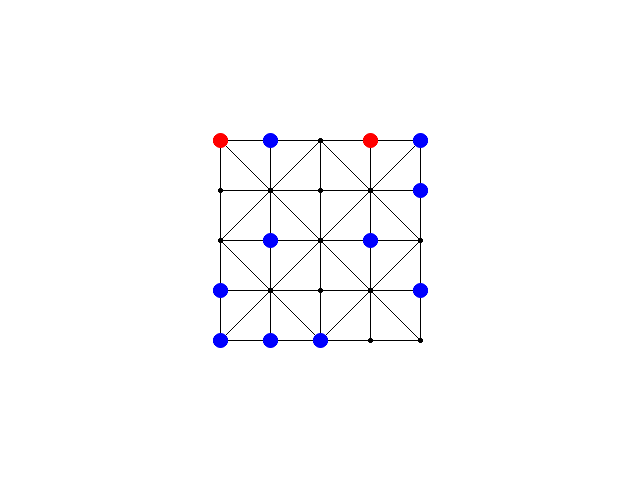

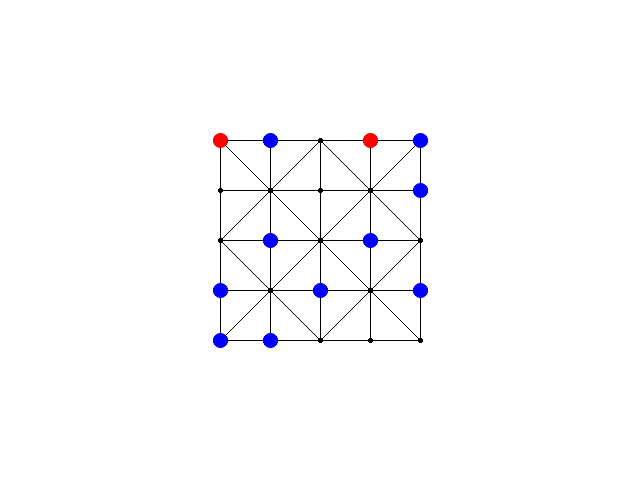

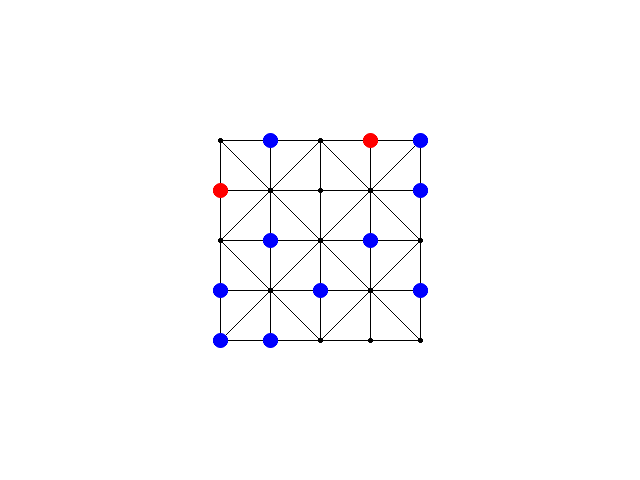

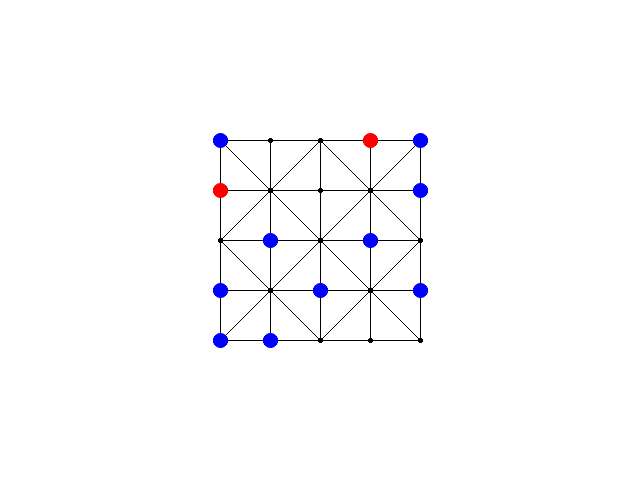

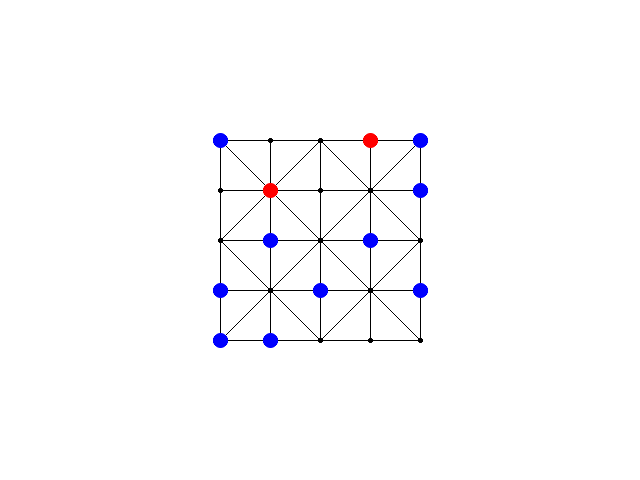

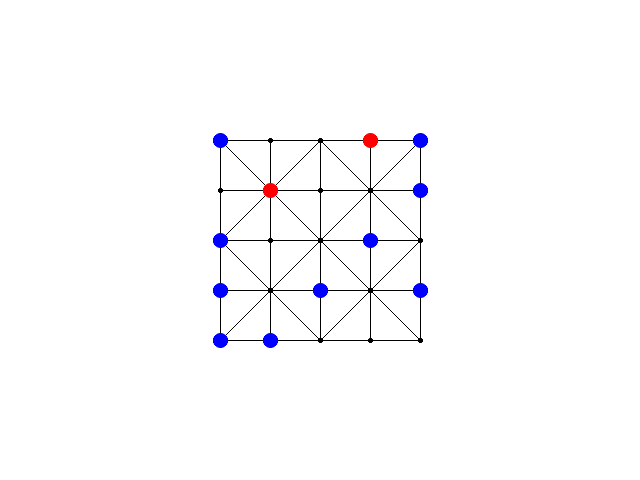

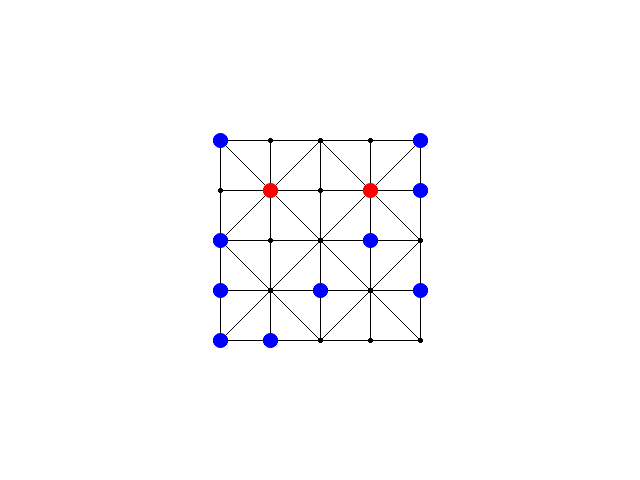

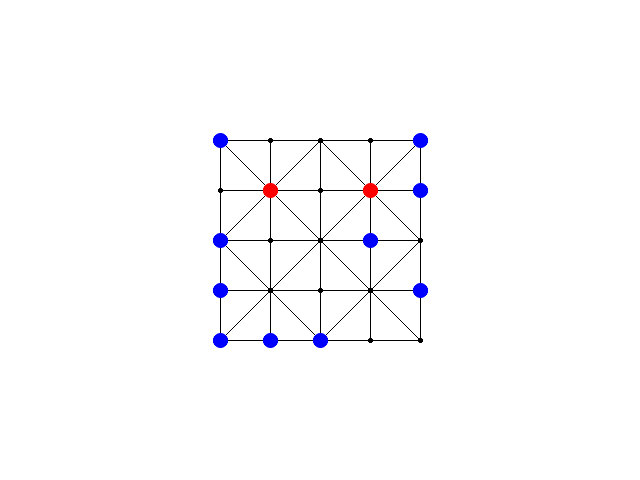

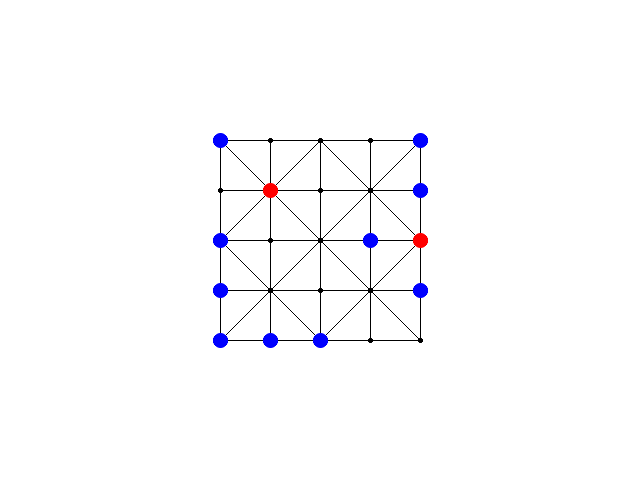

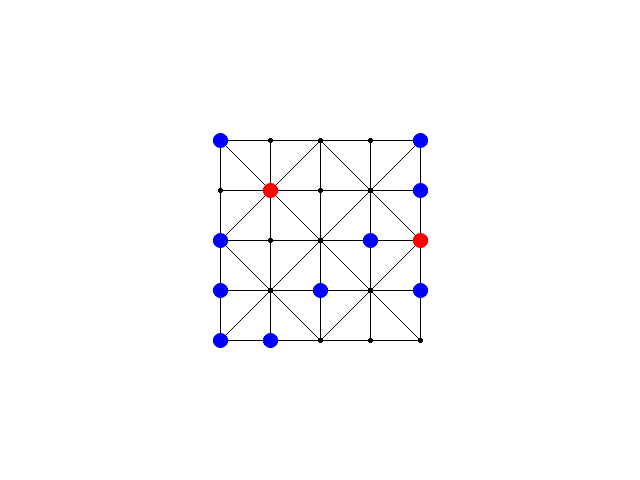

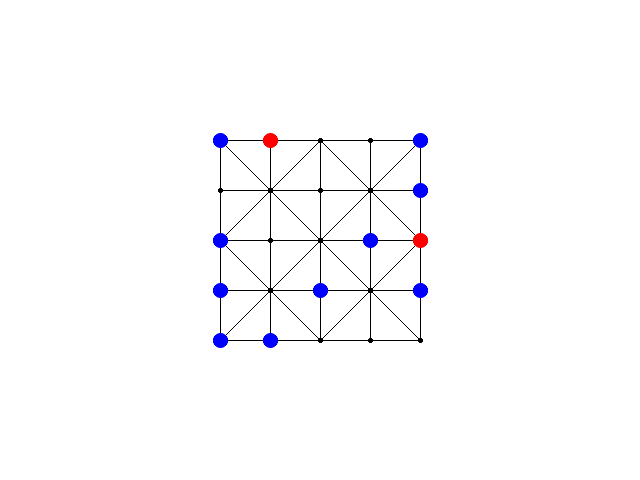

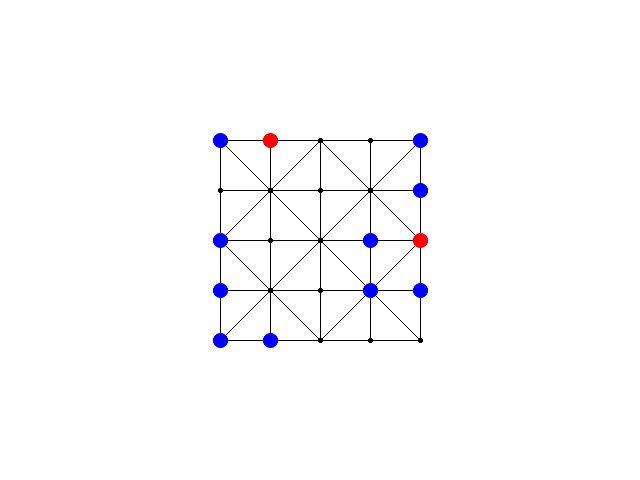

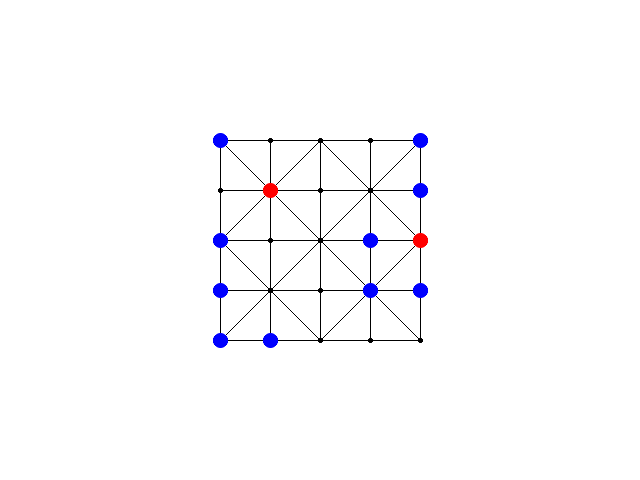

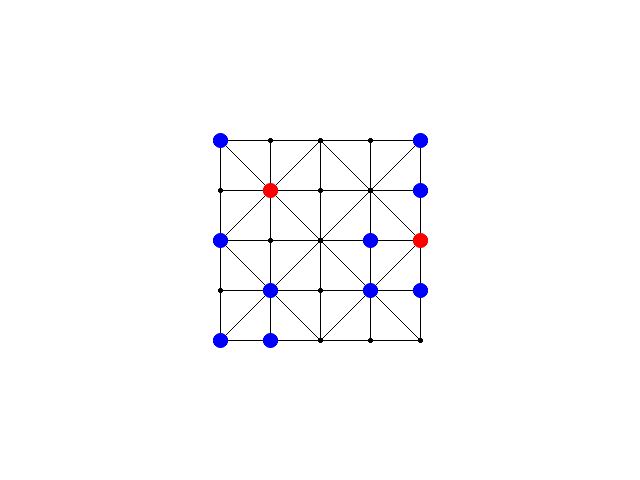

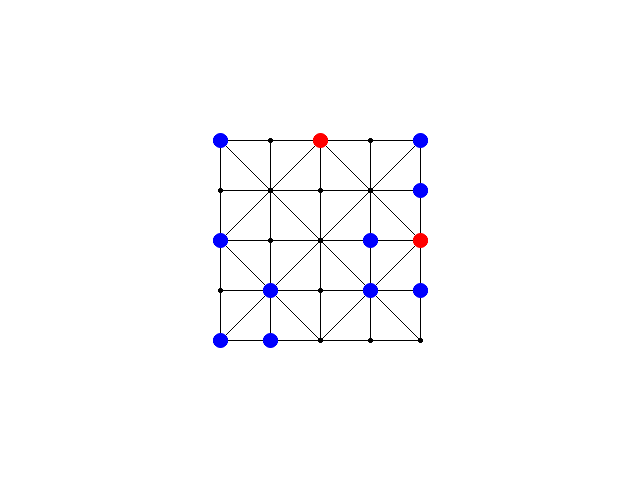

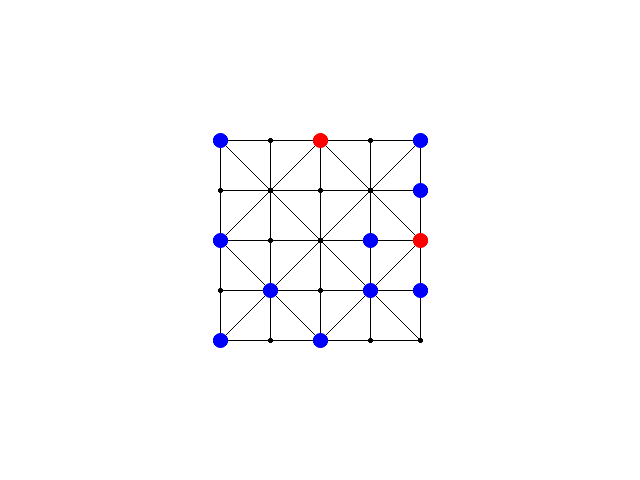

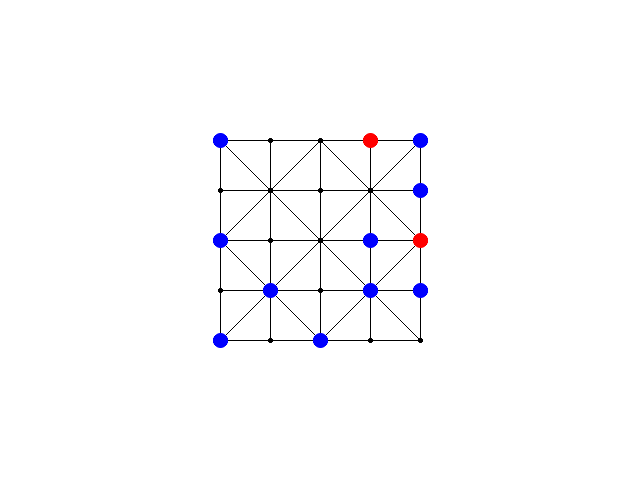

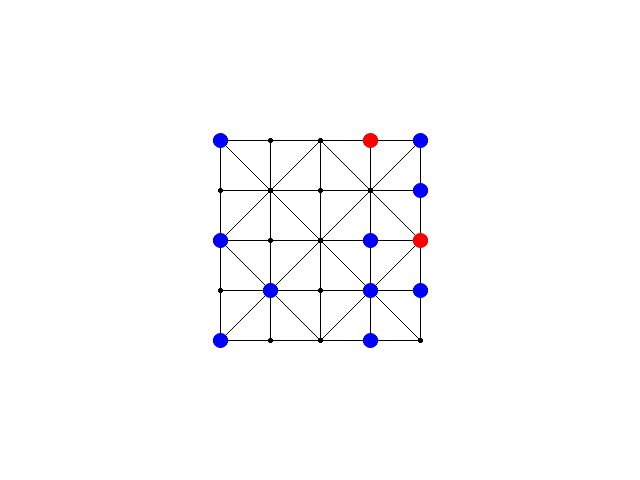

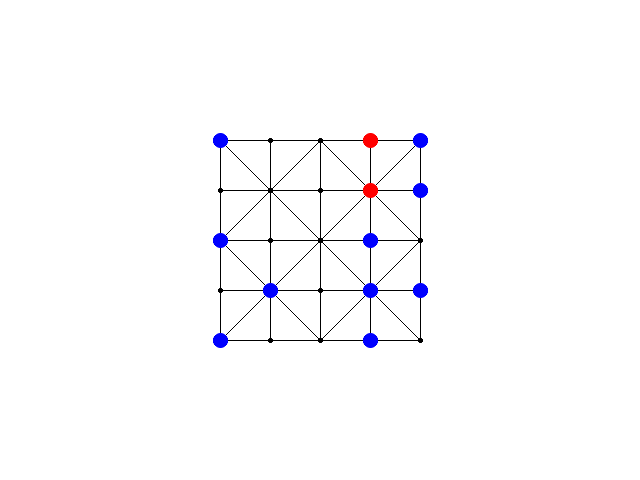

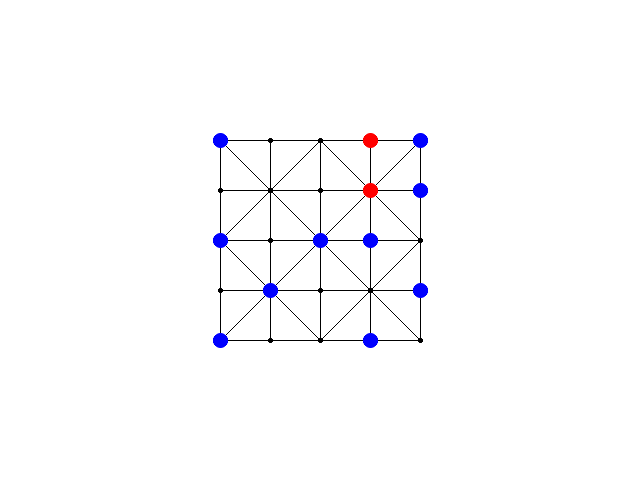

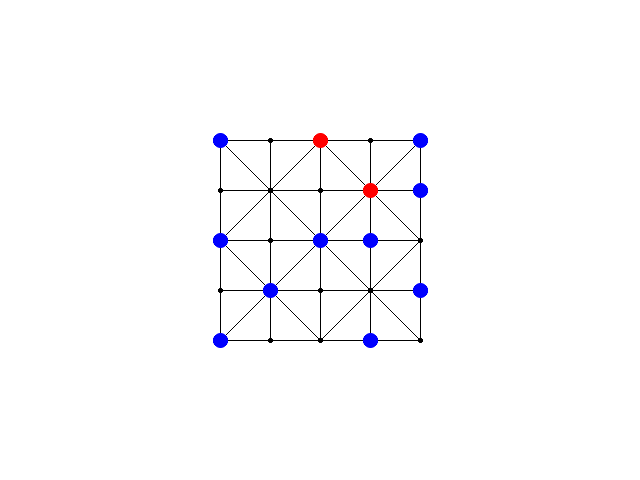

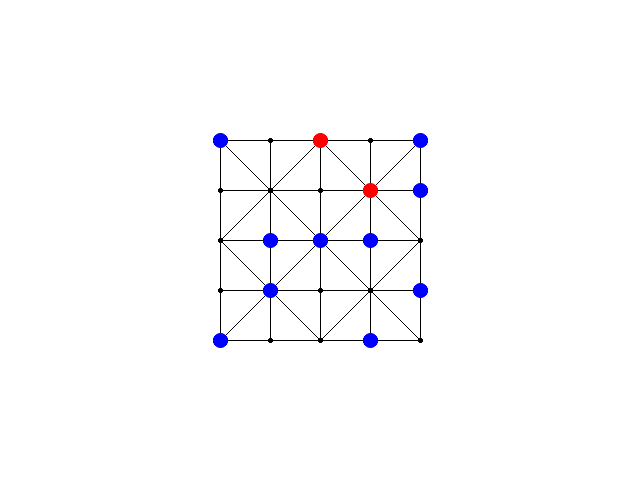

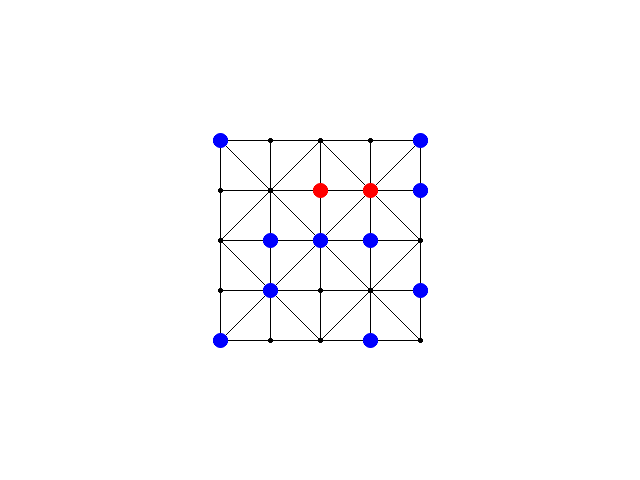

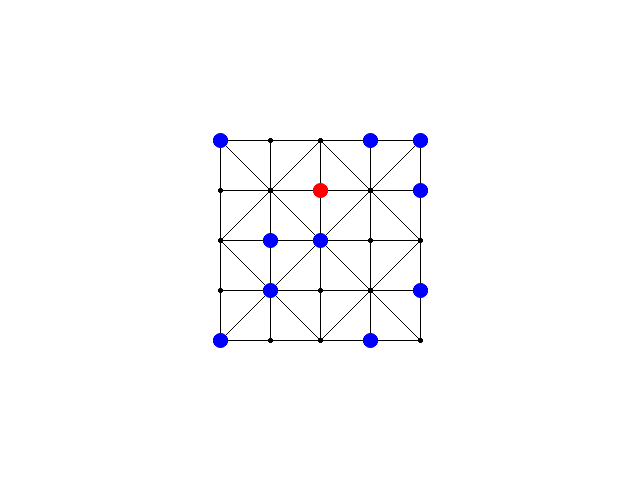

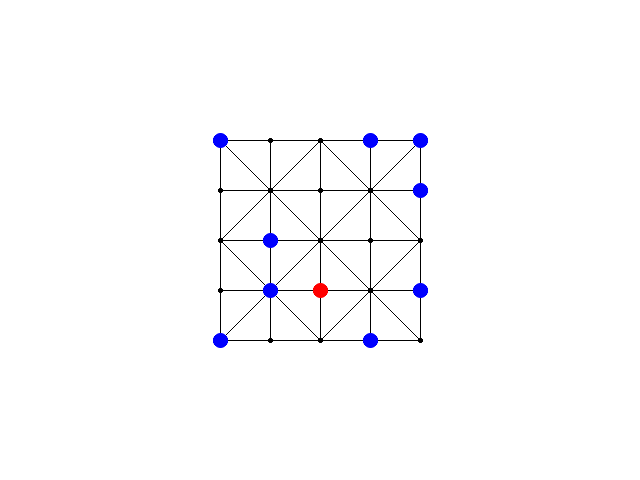

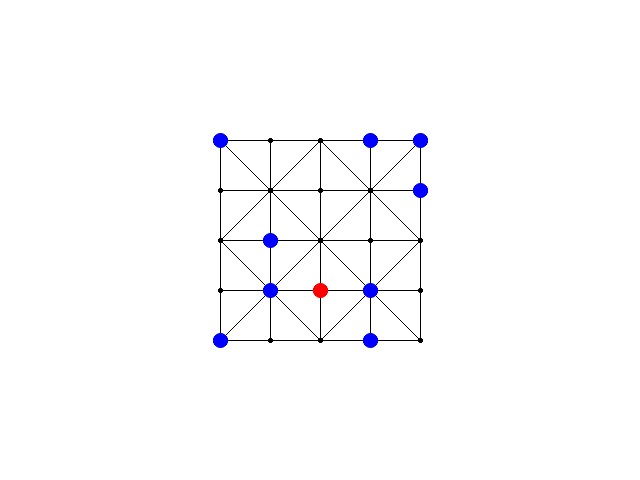

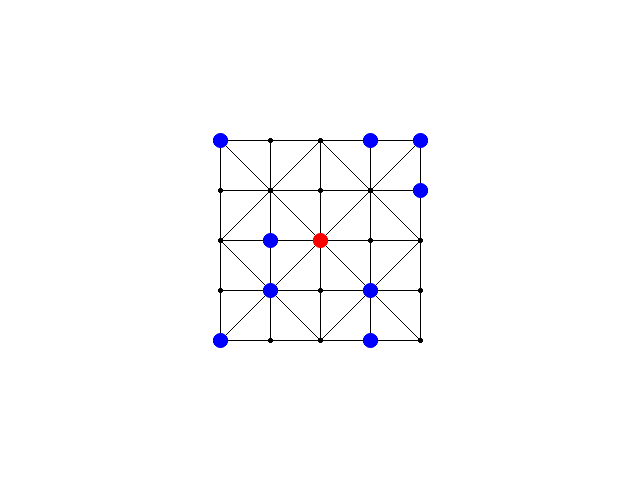

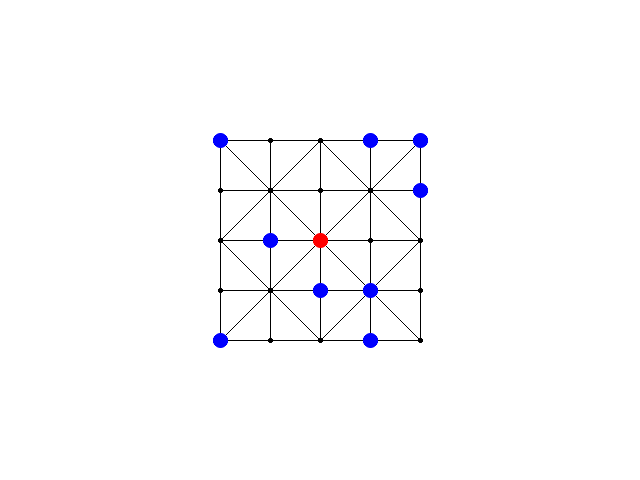

Player 2 wins


2

In [ ]:
# example 1: player1 = red, player2 = blue
# with graphics=True you can follow the steps and see the game.
player1 = Random_Player(1)
player2 = Random_Player(2)
game = Game(player1, player2)
start_game(game, graphics=True)

You can see playing of two random player for 10 time in below cell. It is obvious that first player wining is approximately equal to second one.

In [ ]:
# example 1: player1 = red, player2 = blue
num = 10
win_1 = 0
win_2 = 0
draw = 0
for _ in range(num):
  player1 = Random_Player(1)
  player2 = Random_Player(2)
  game = Game(player1, player2)
  result = start_game(game, graphics=False)
  if result == 1:
    win_1 += 1
  elif result == 0:
    draw += 1
  else:
    win_2 += 1
print(f'win_1 = {win_1}, win_2 = {win_2}, draw = {draw}')

Player 1 wins
Player 2 wins
Player 2 wins
Player 1 wins
Player 1 wins
Player 1 wins
It's a draw
It's a draw
Player 2 wins
Player 1 wins
win_1 = 5, win_2 = 3, draw = 2


### Random player vs Min Max player

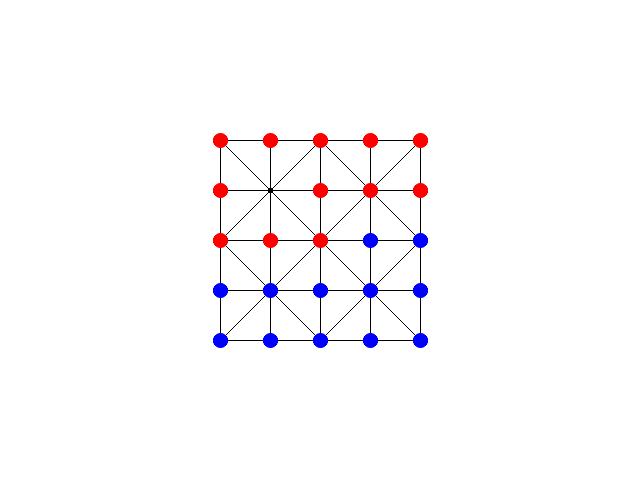

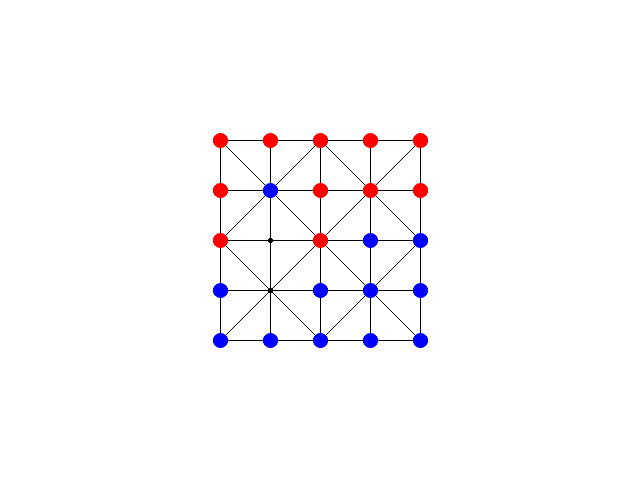

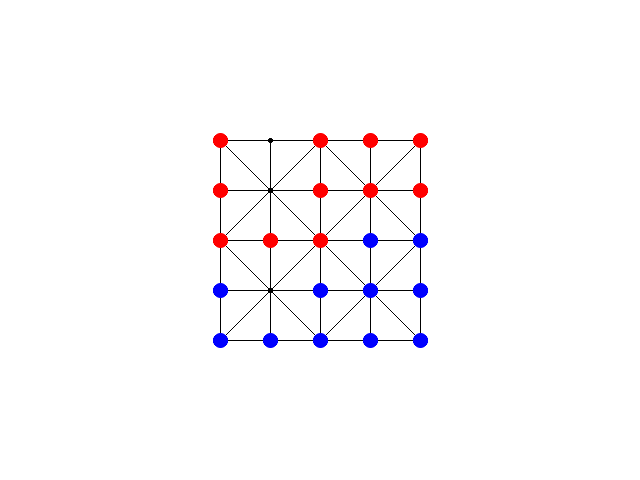

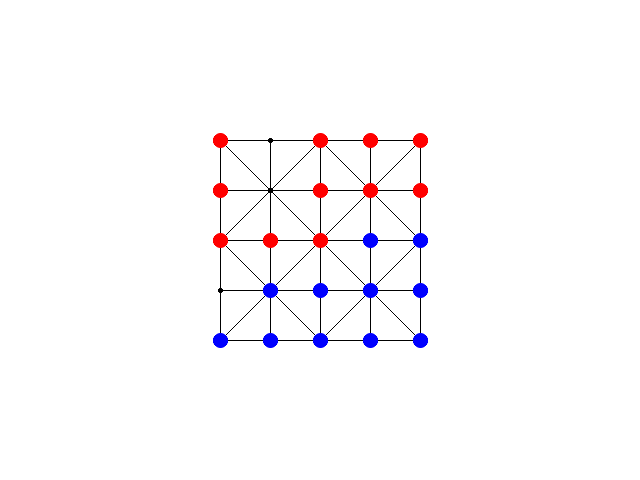

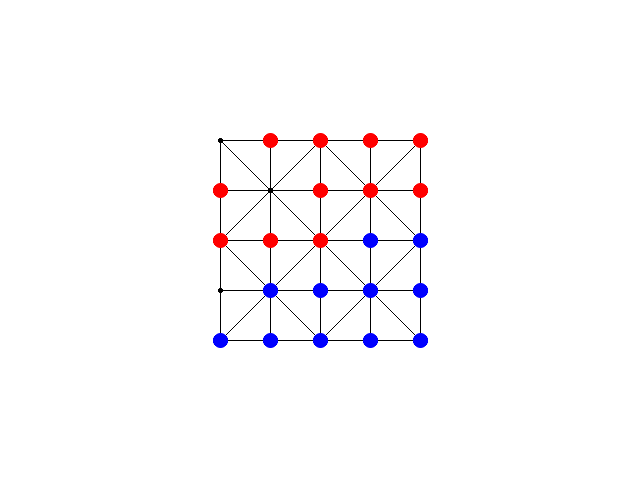

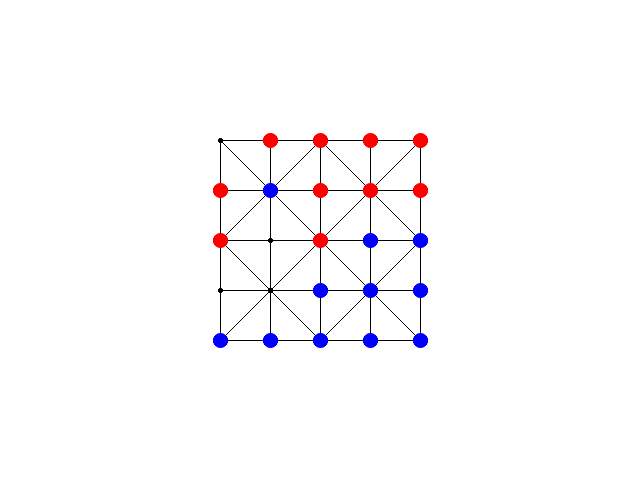

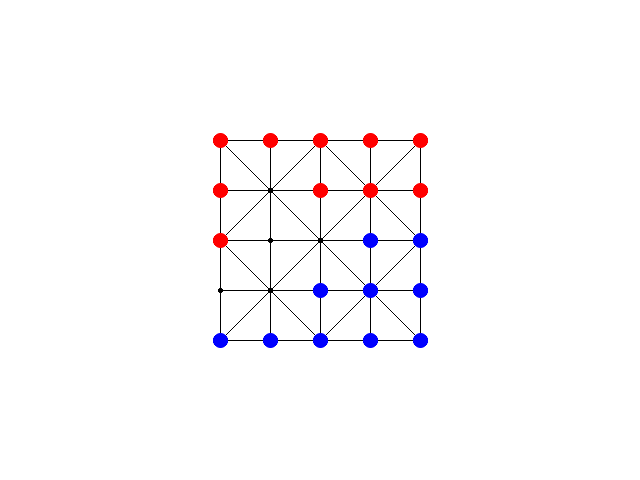

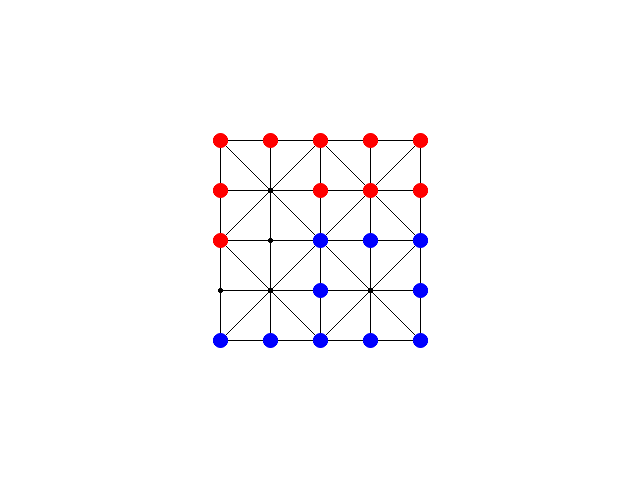

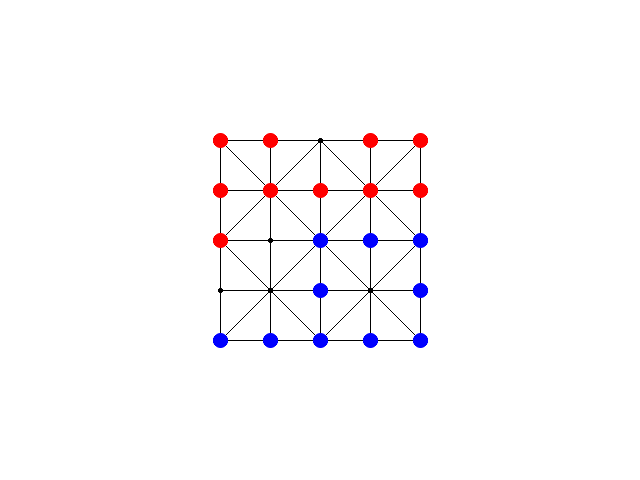

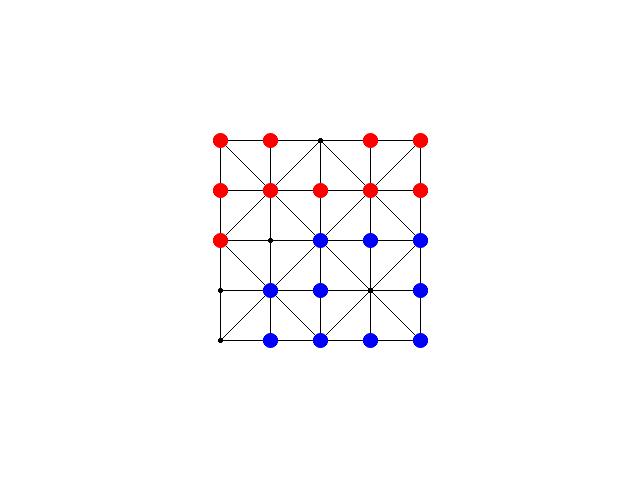

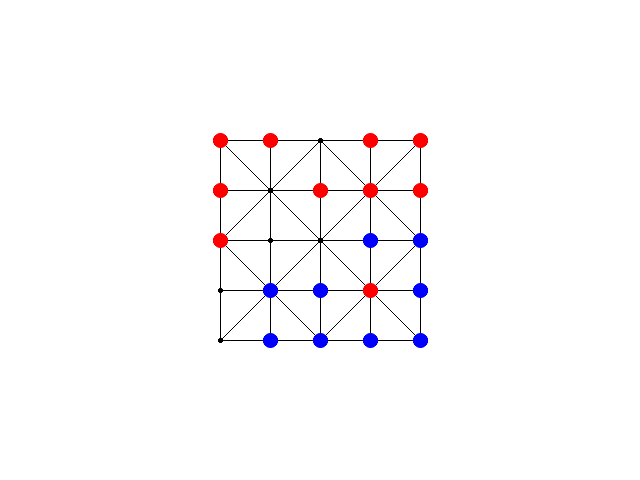

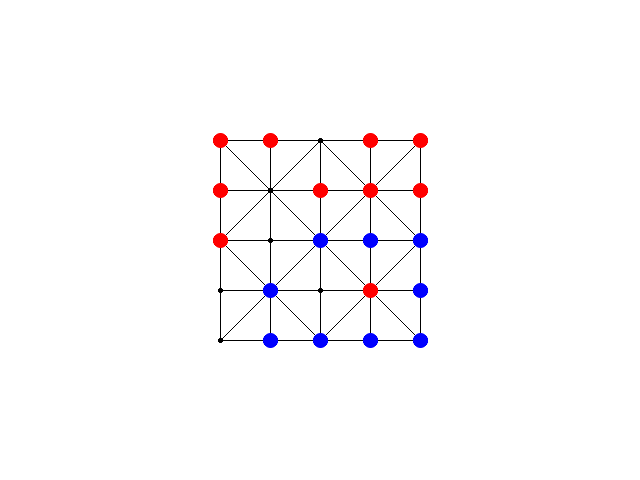

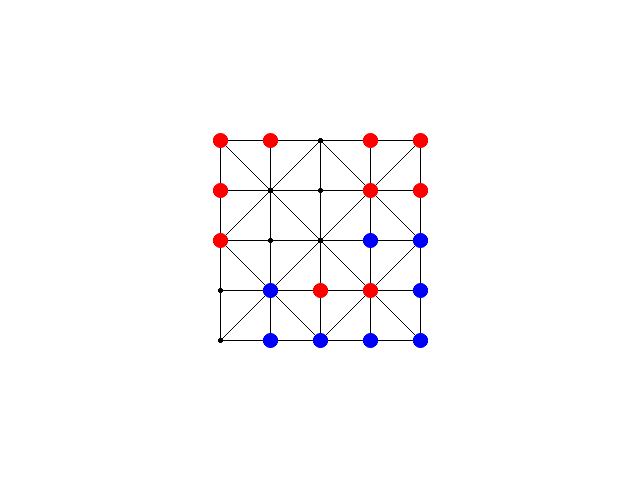

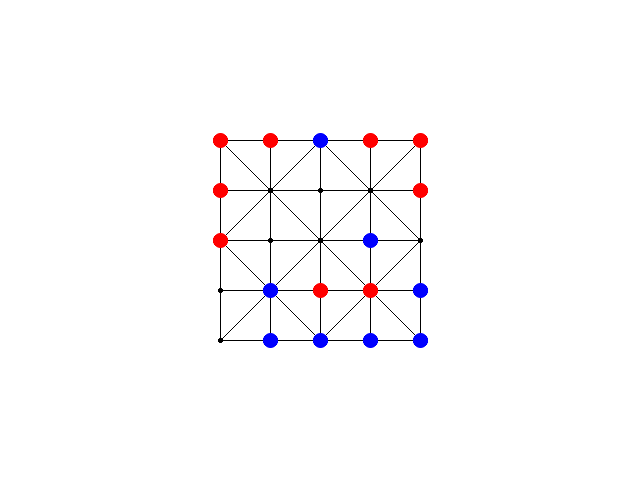

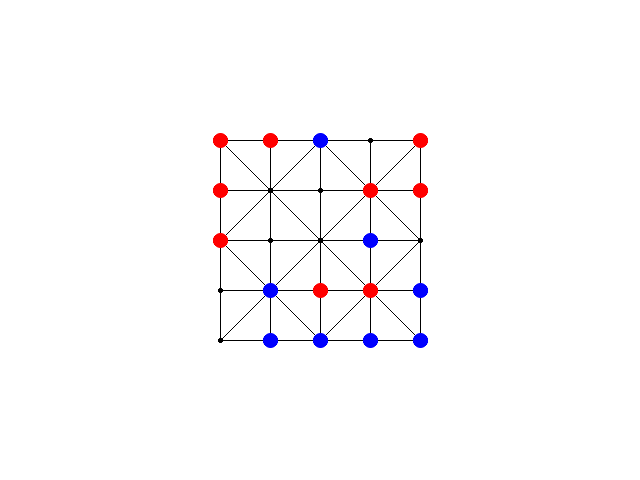

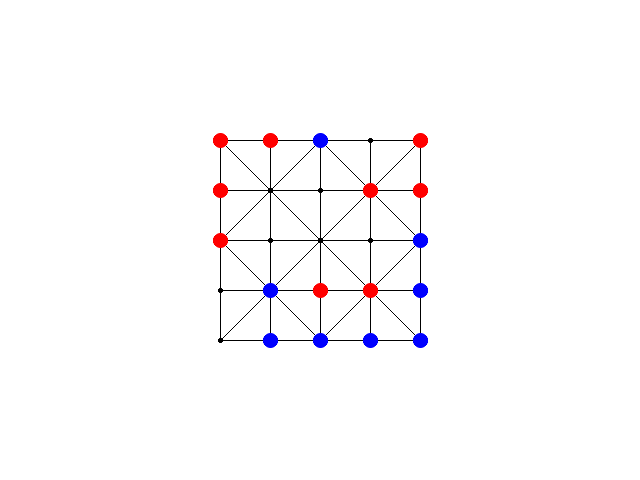

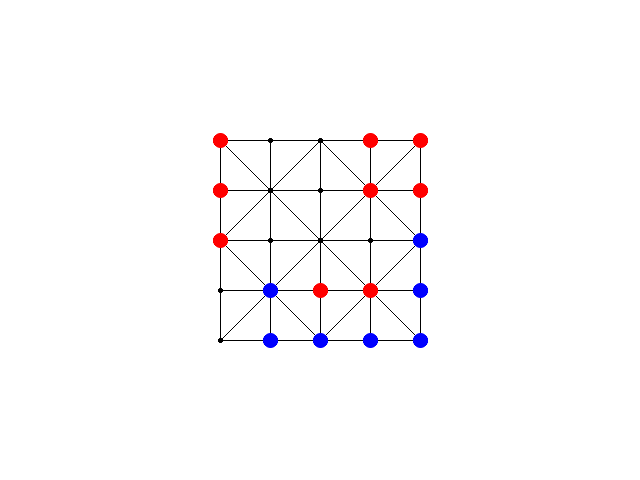

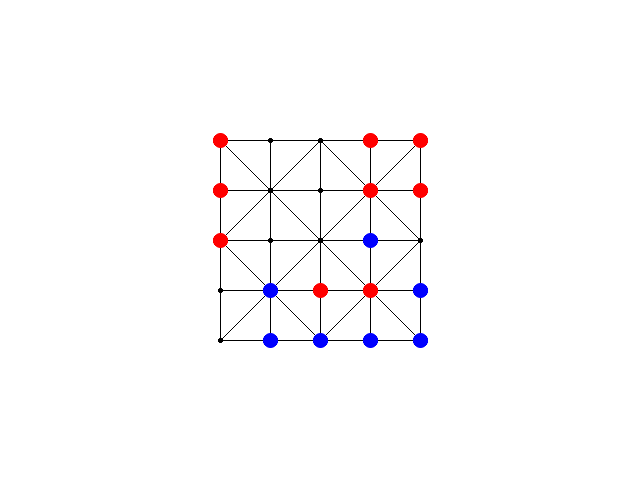

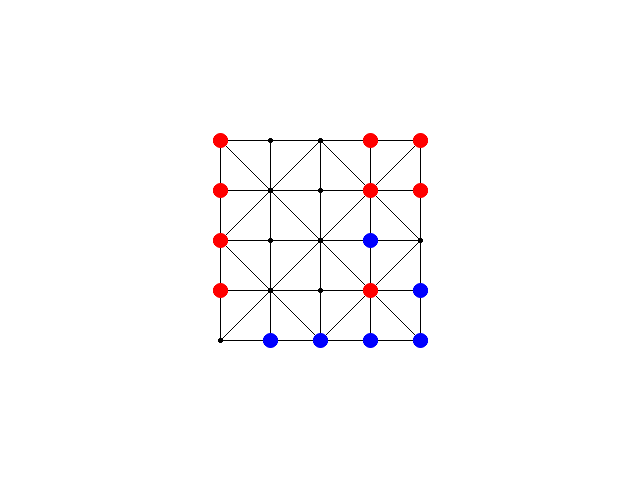

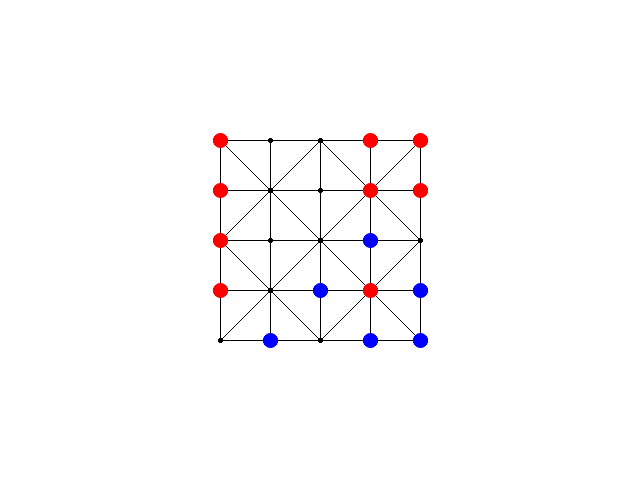

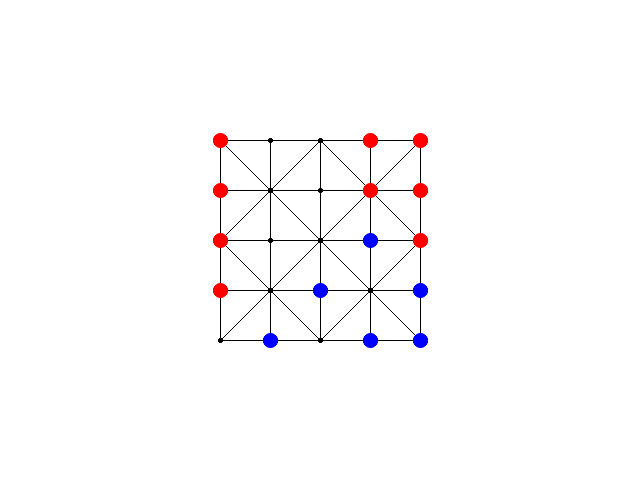

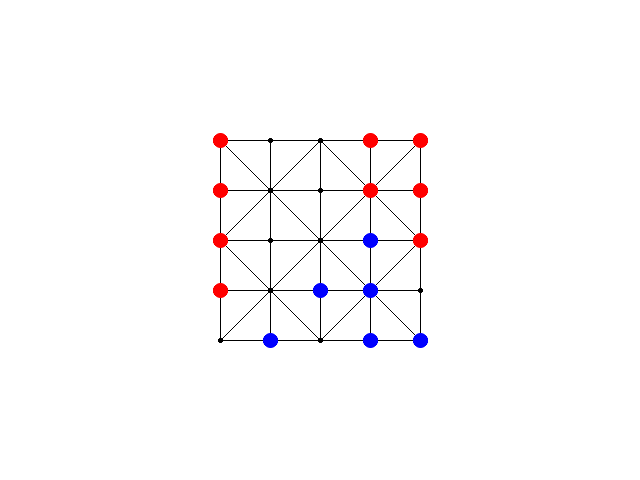

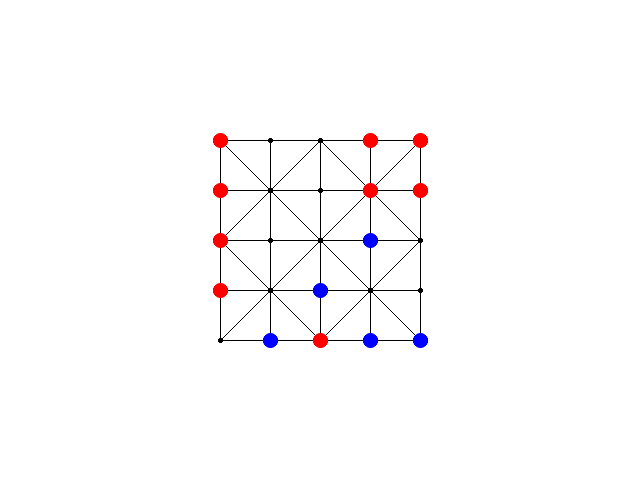

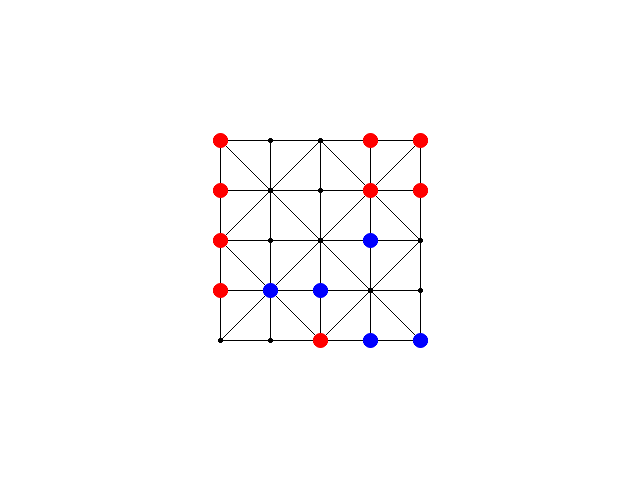

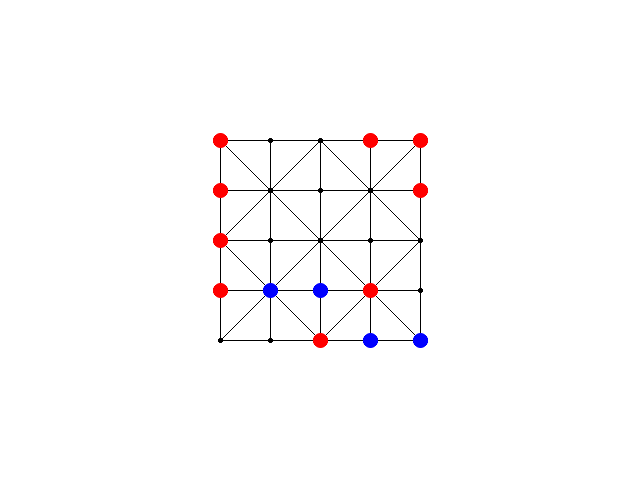

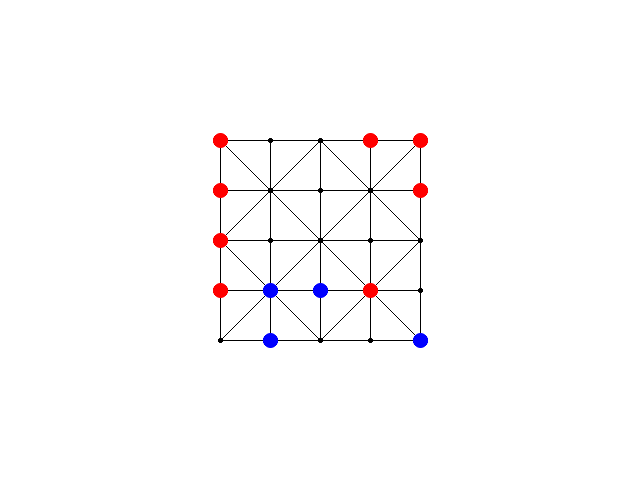

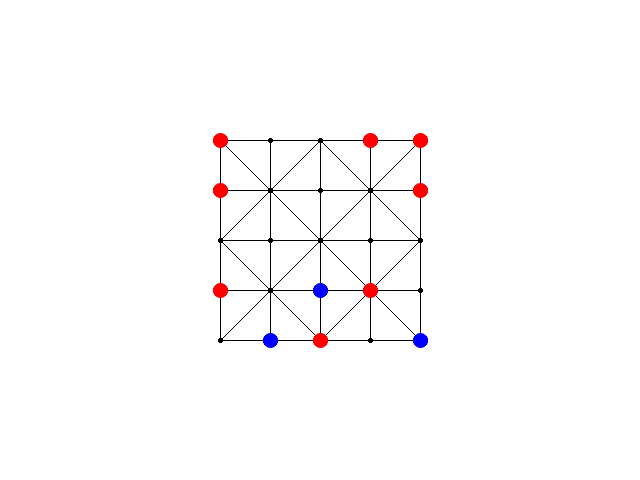

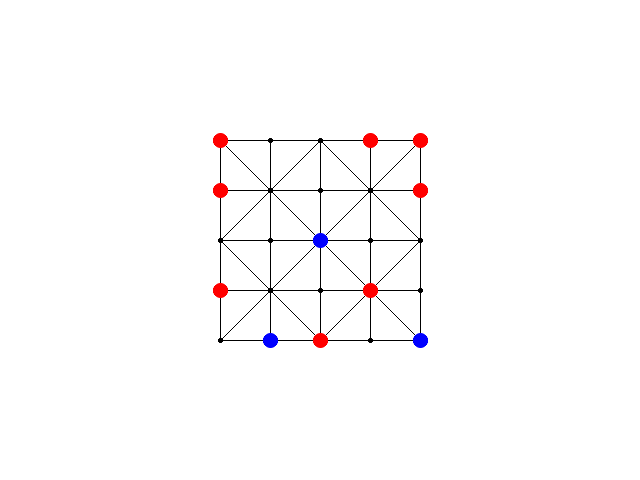

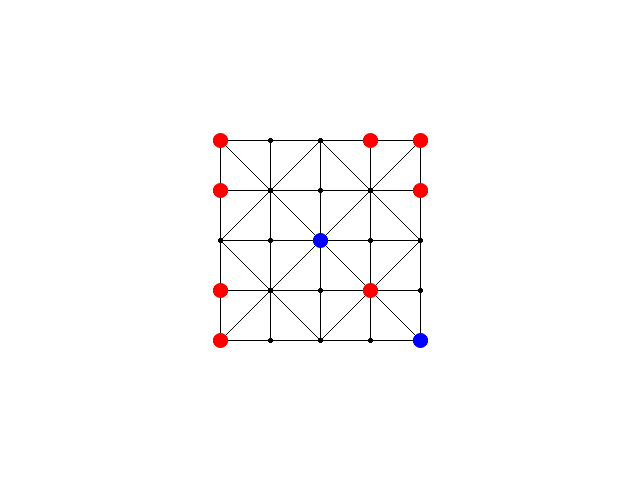

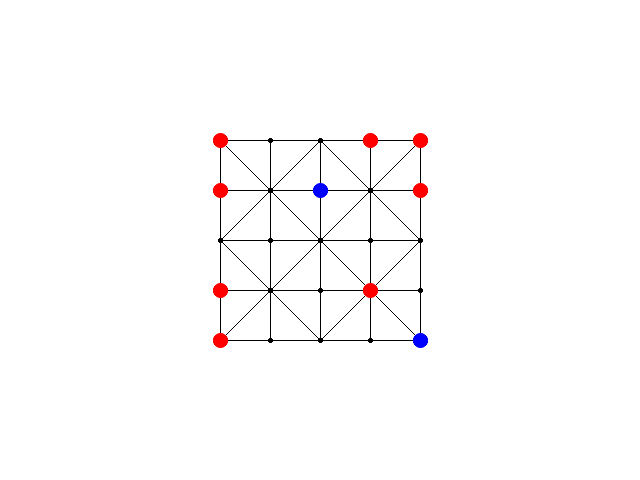

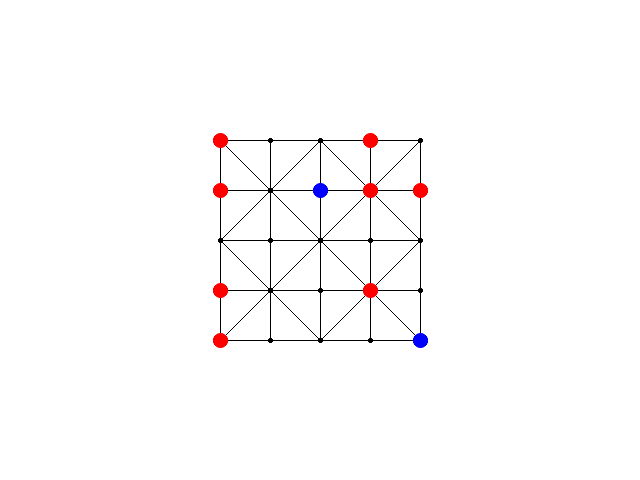

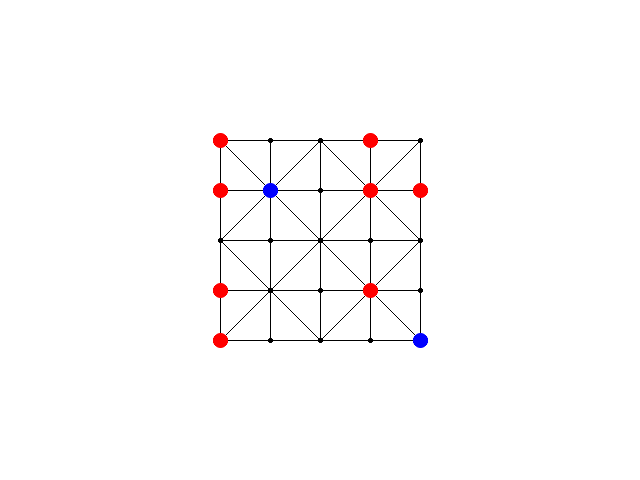

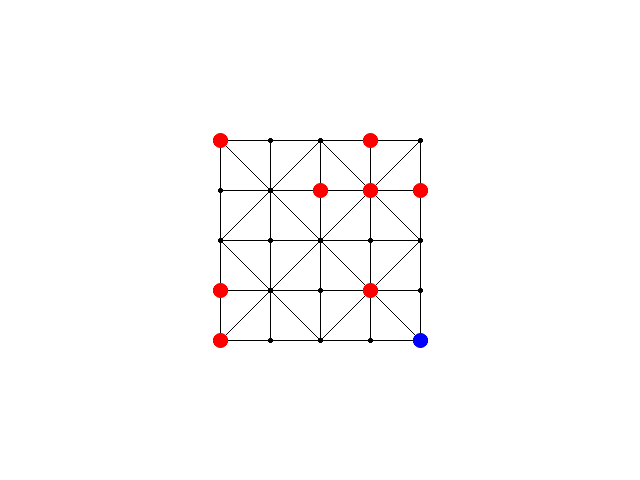

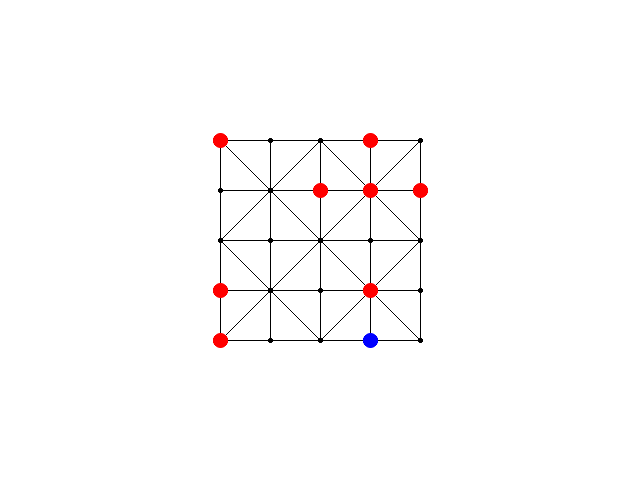

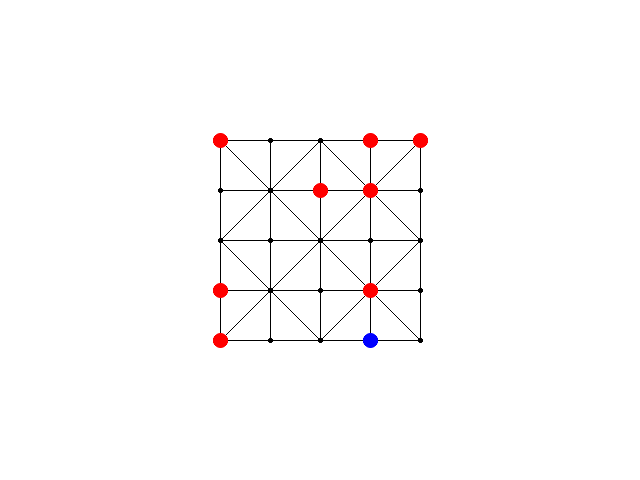

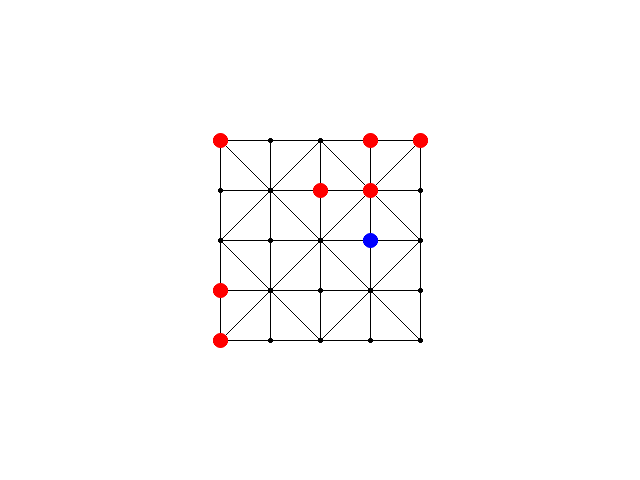

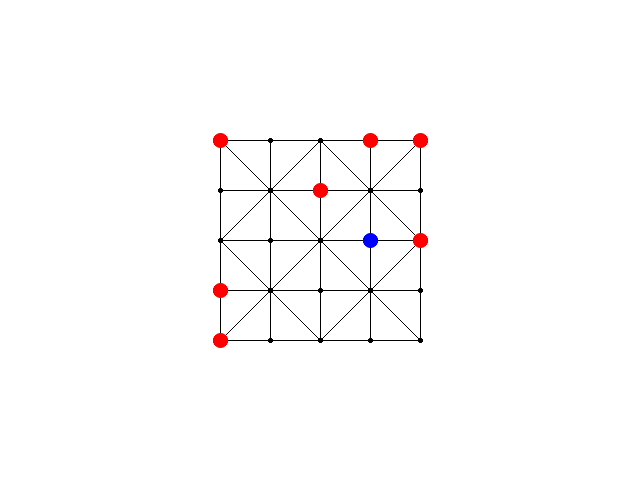

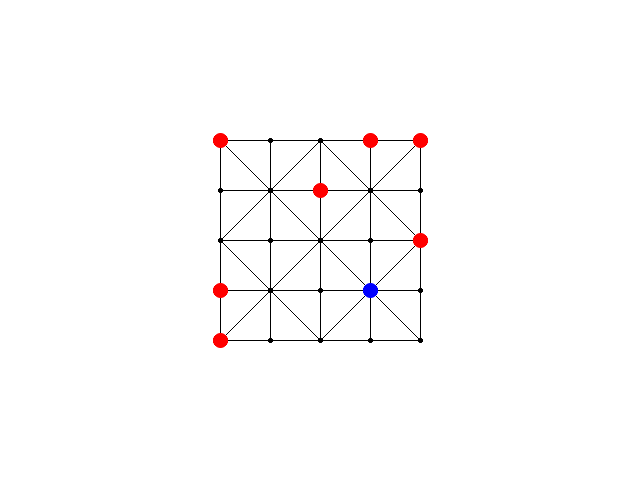

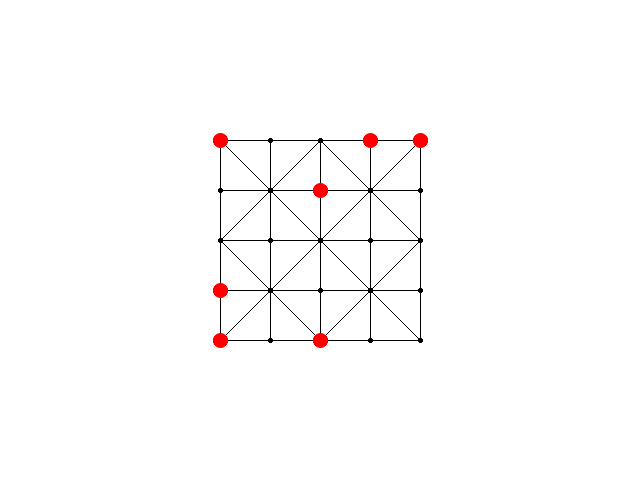

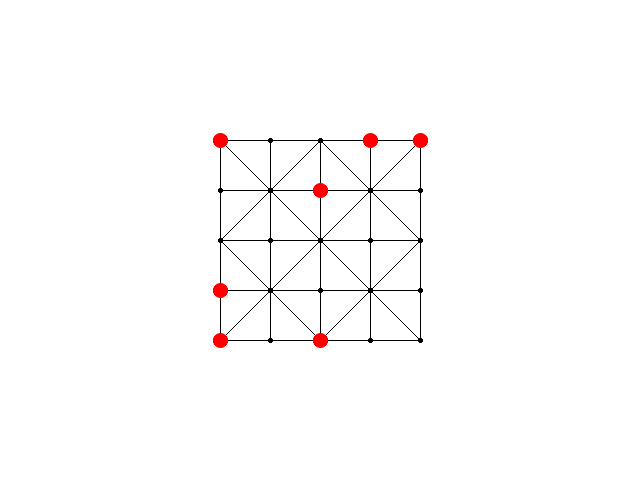

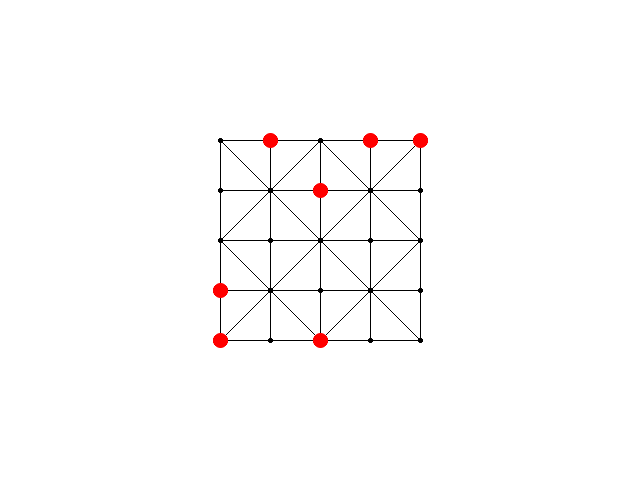

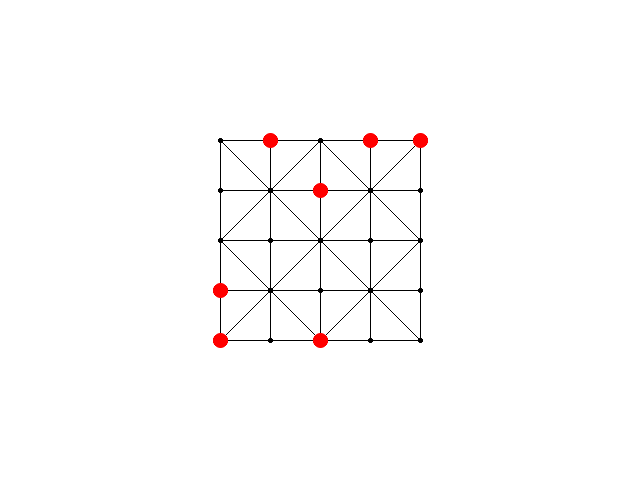

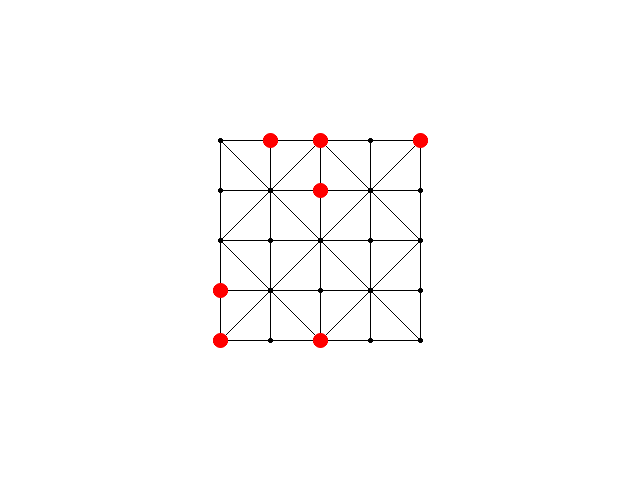

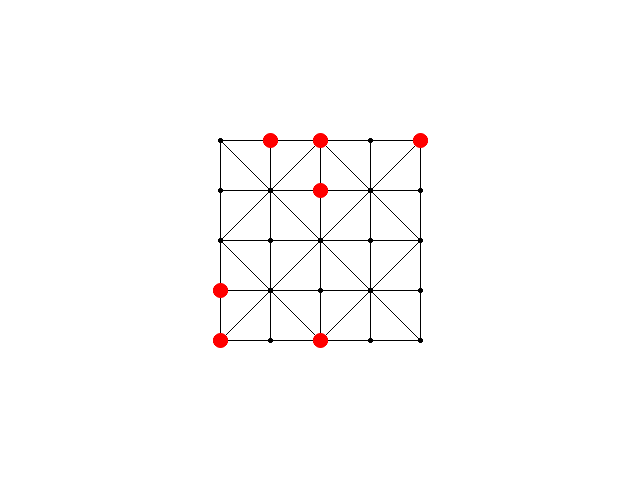

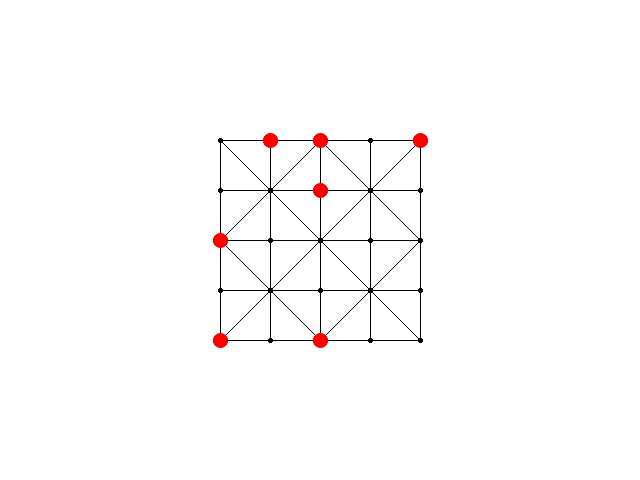

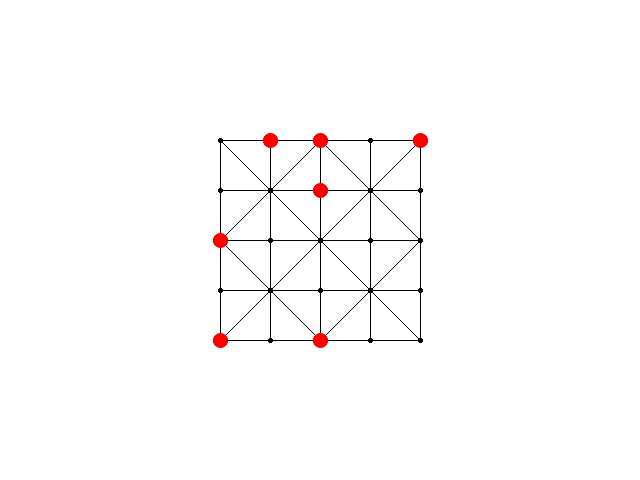

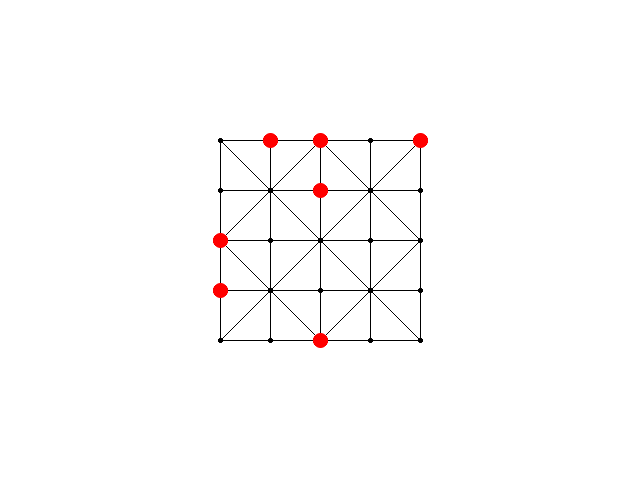

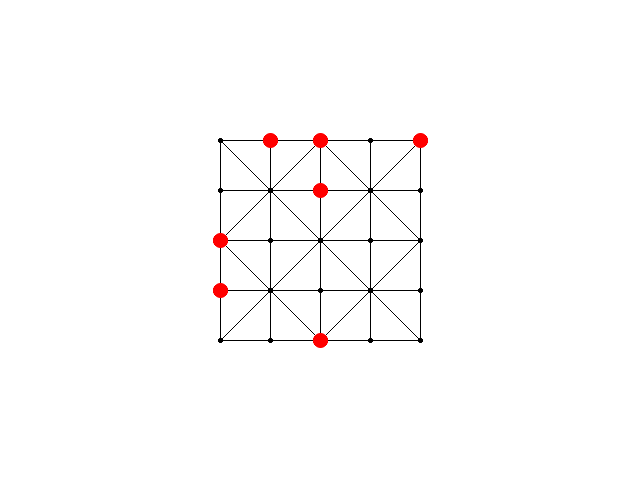

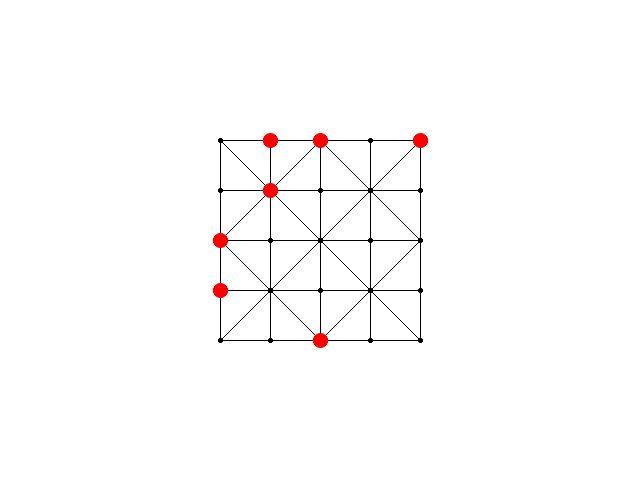

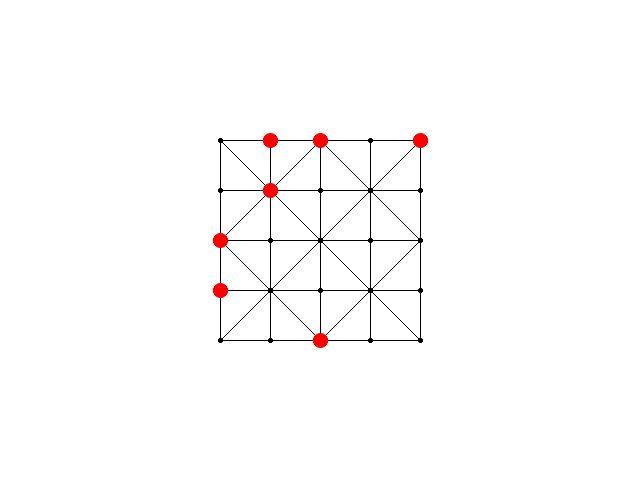

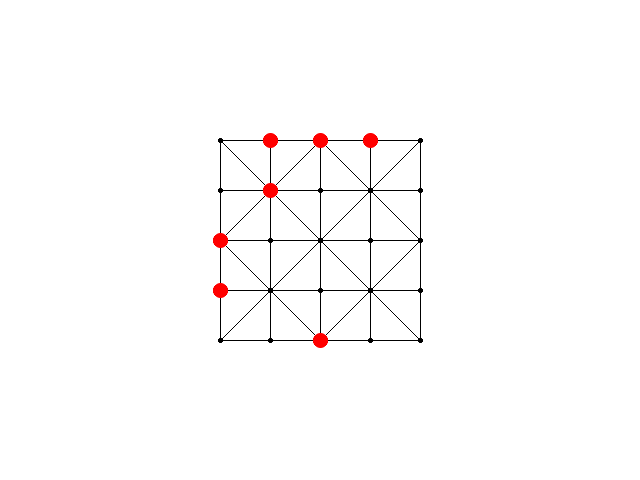

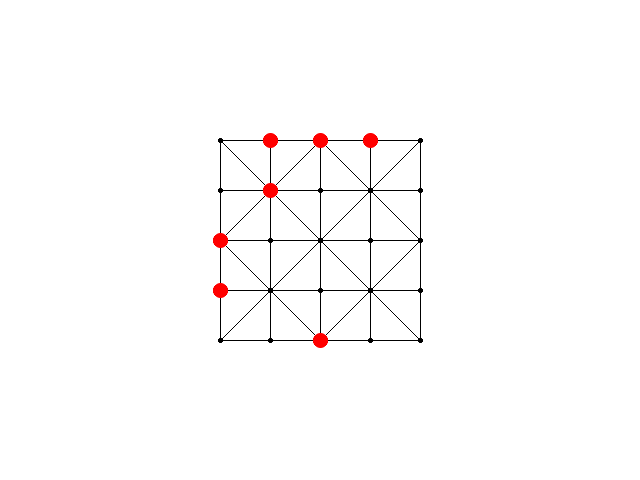

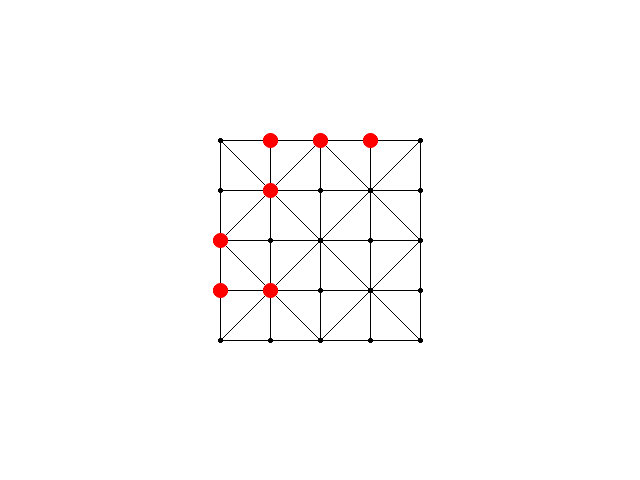

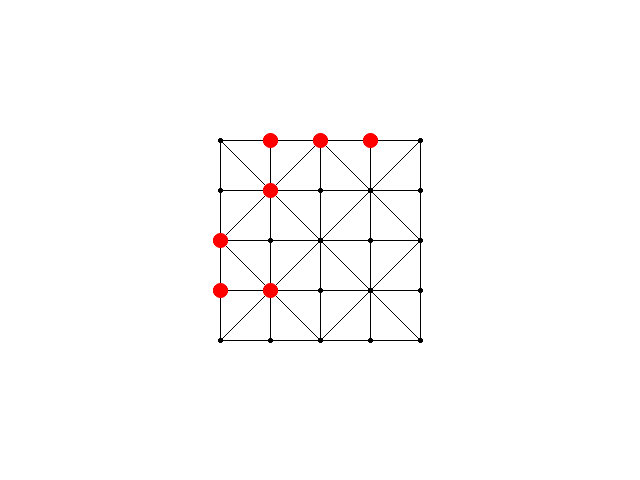

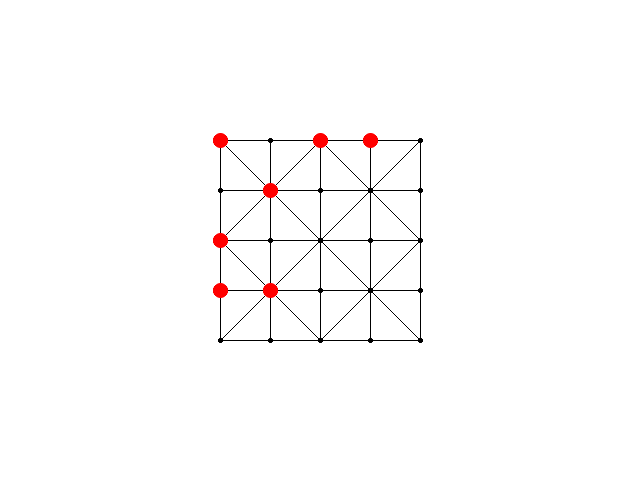

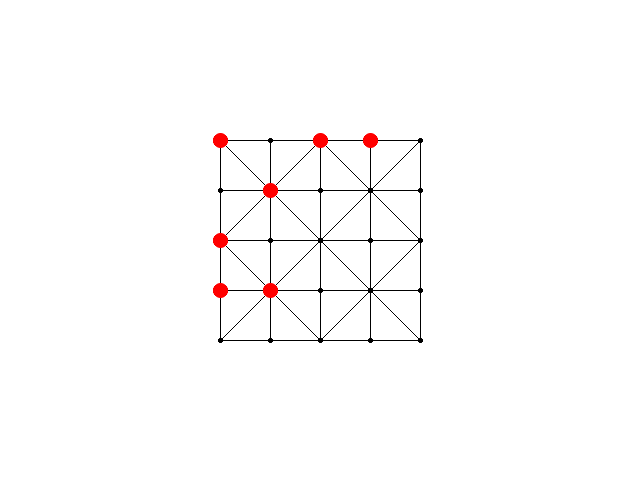

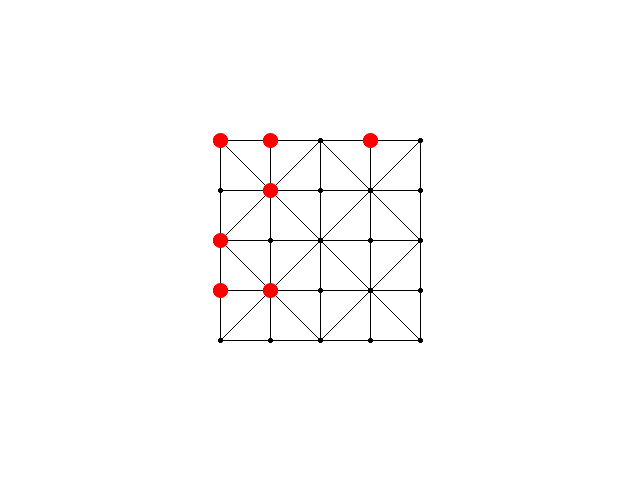

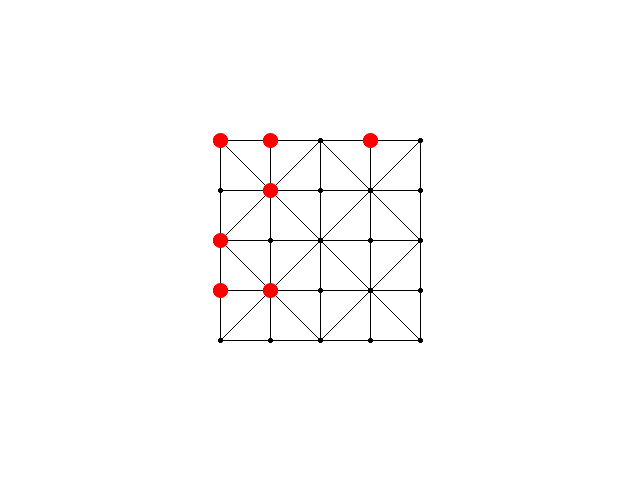

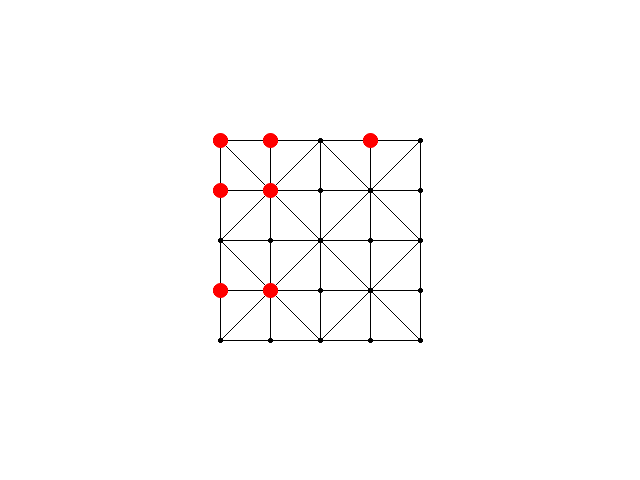

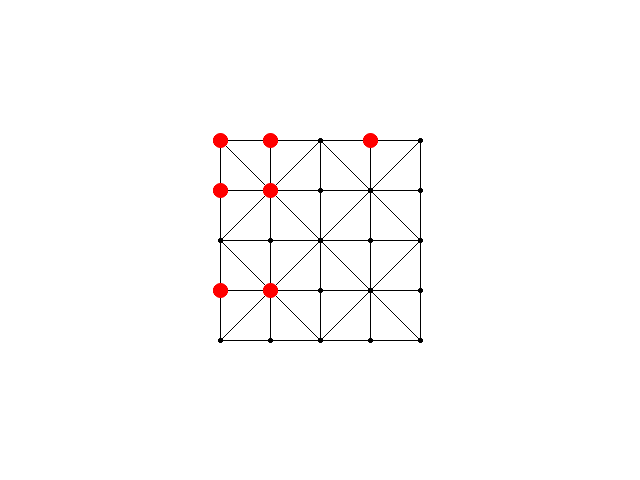

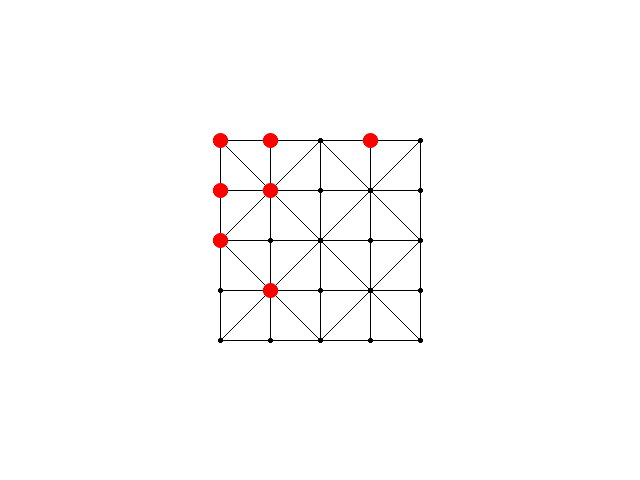

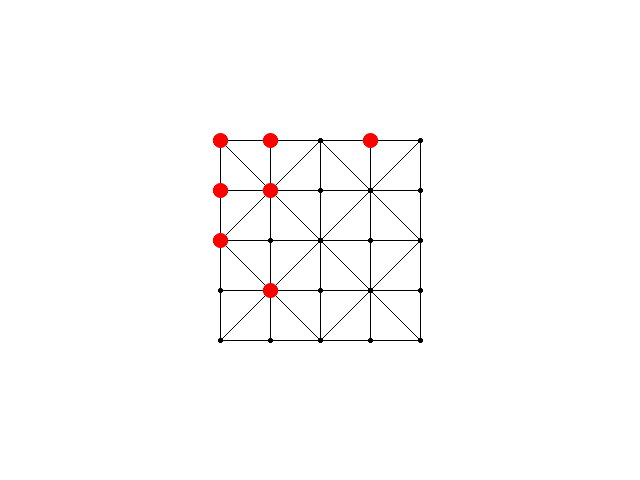

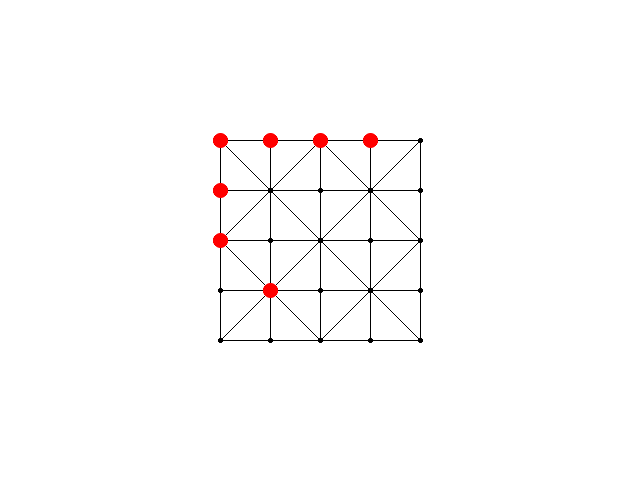

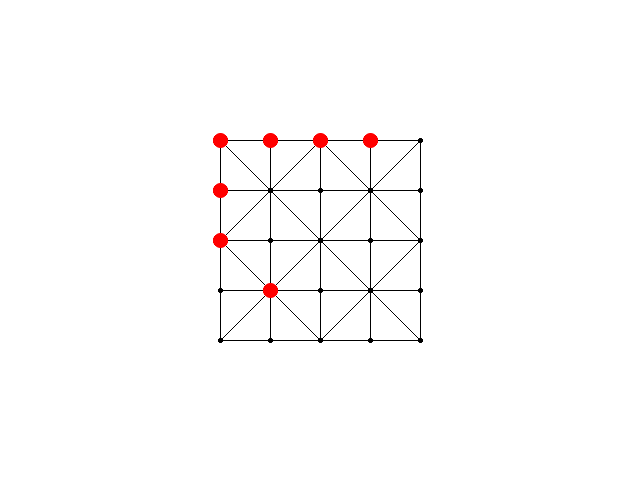

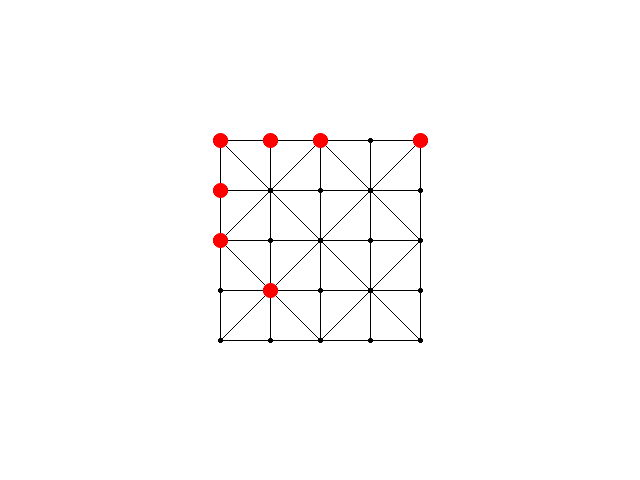

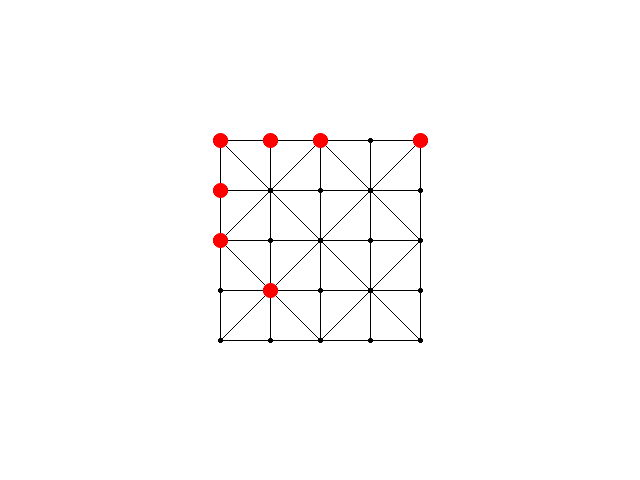

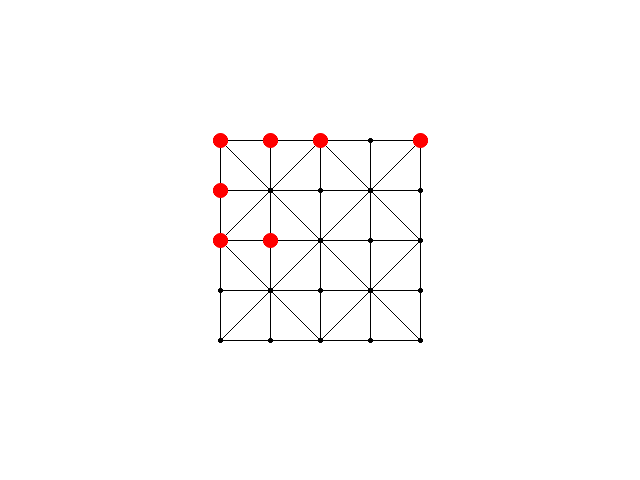

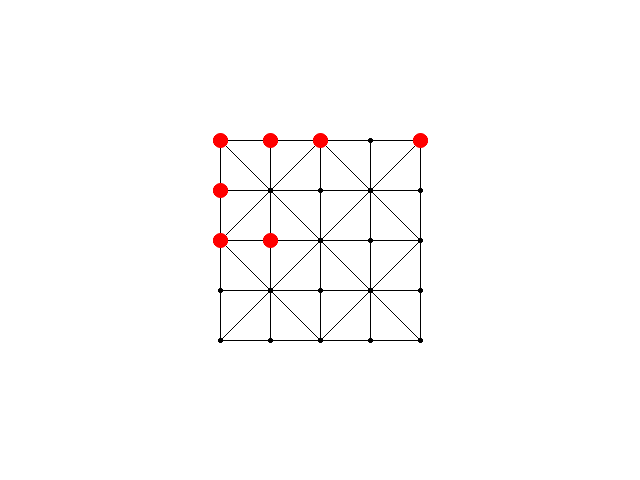

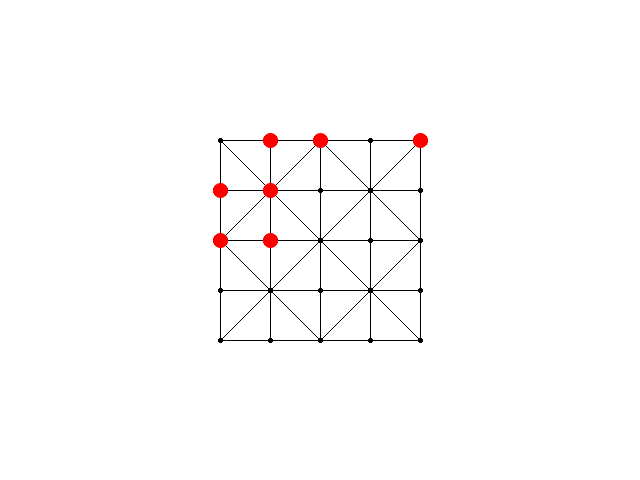

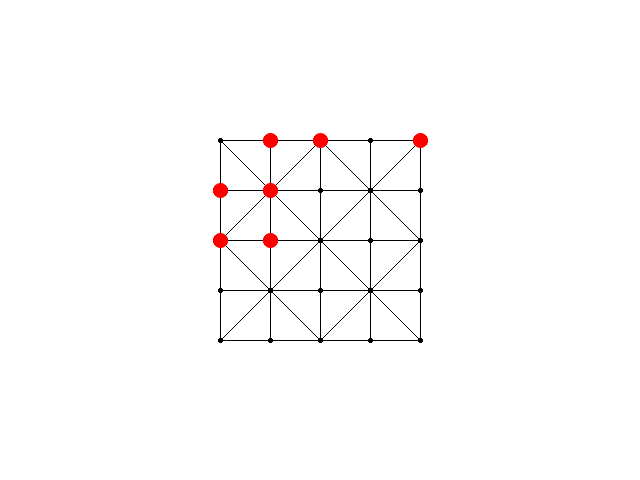

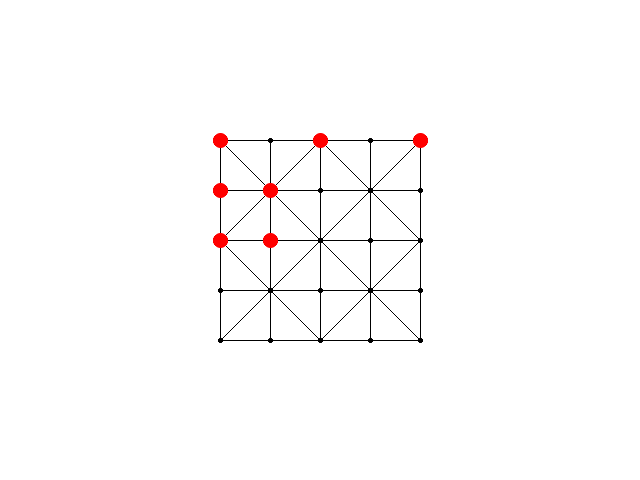

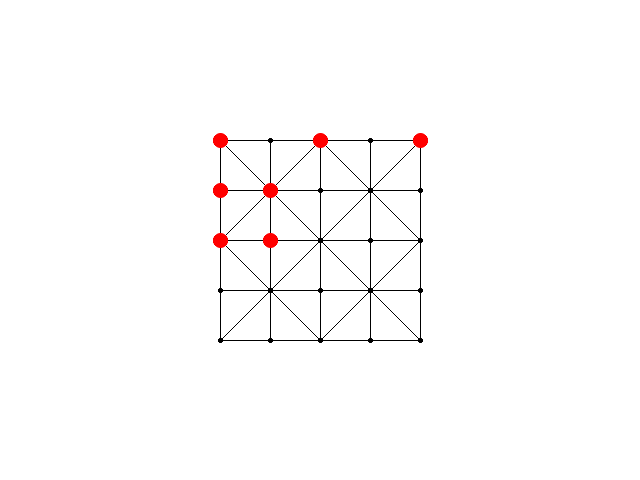

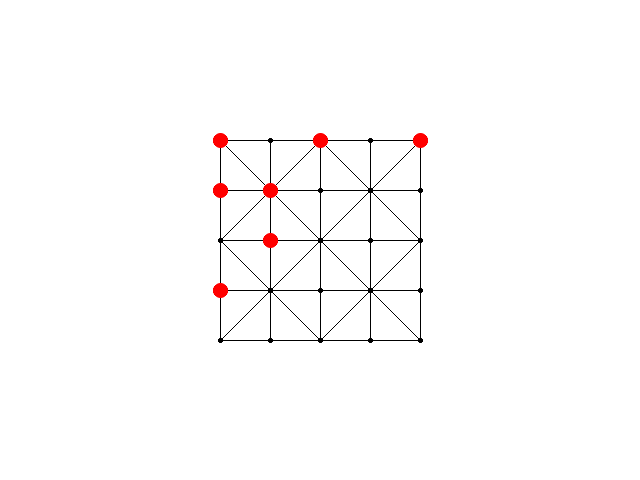

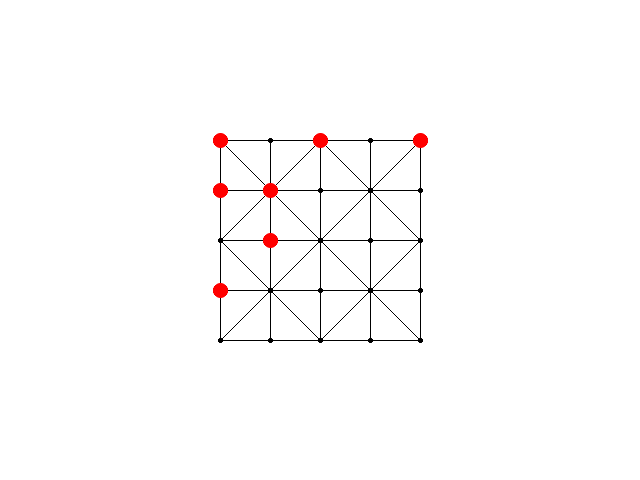

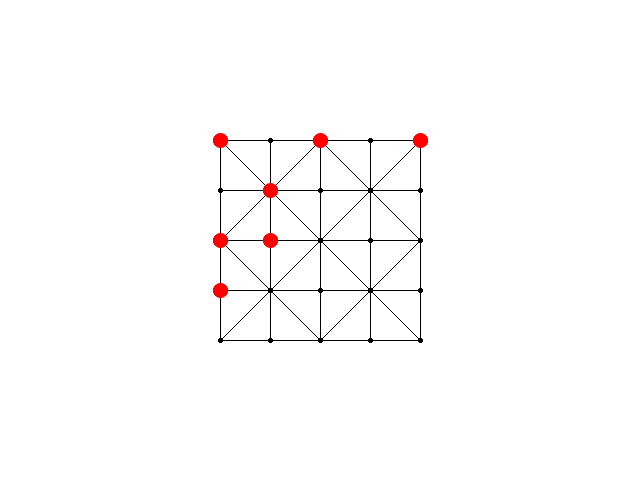

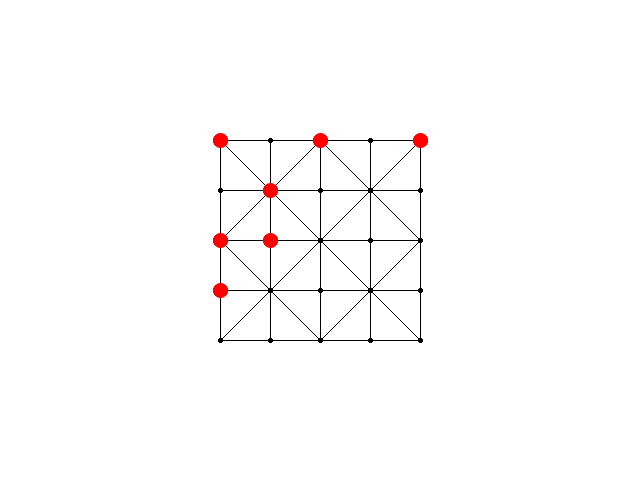

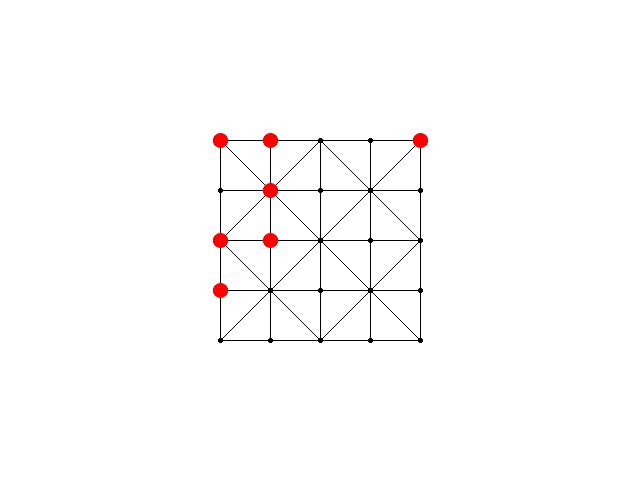

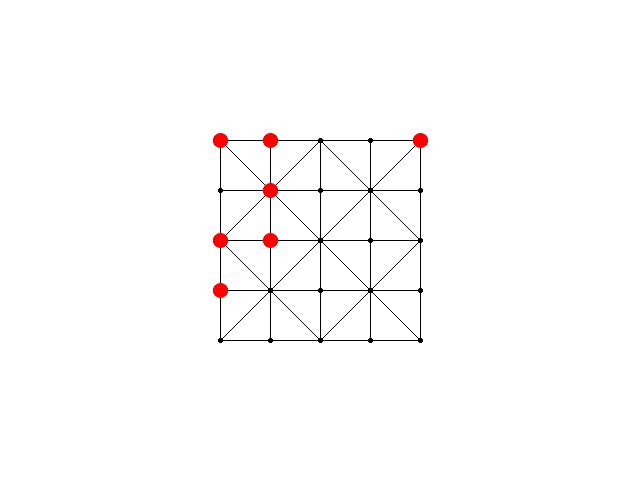

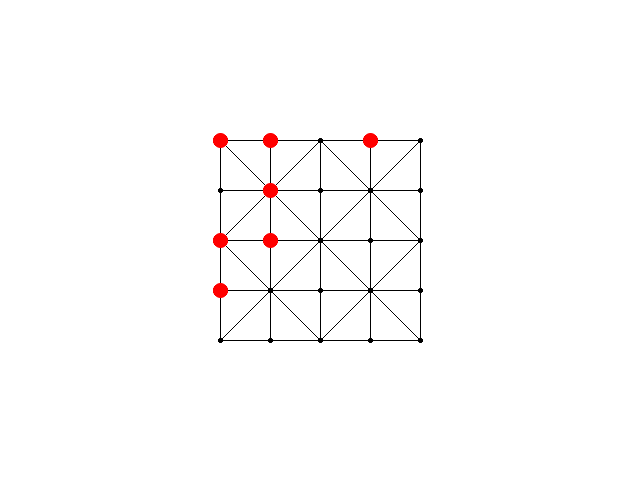

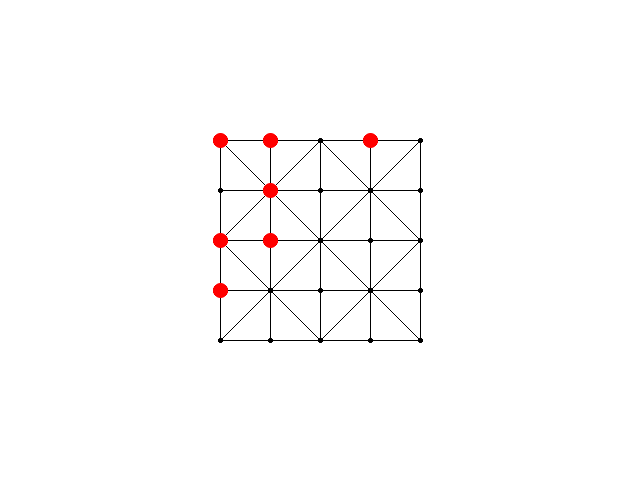

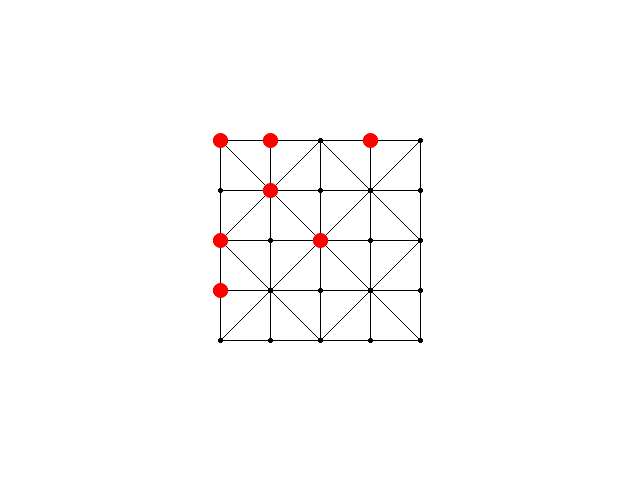

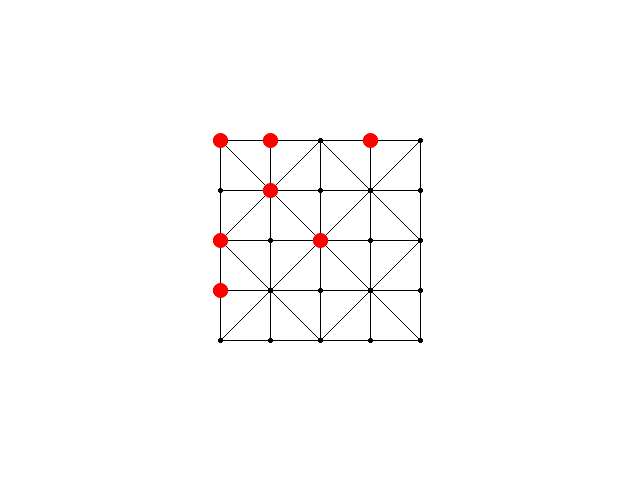

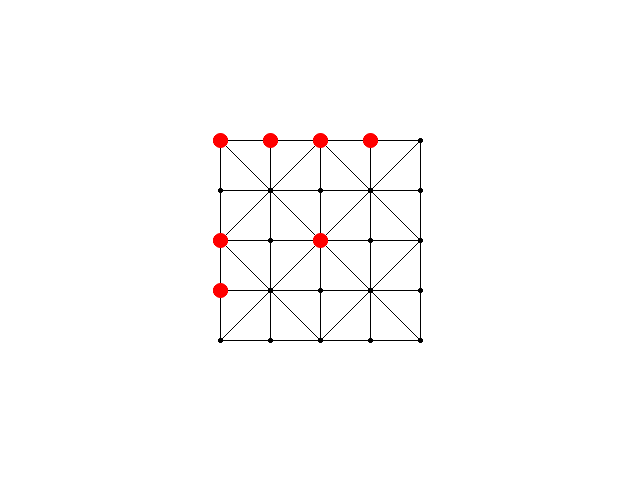

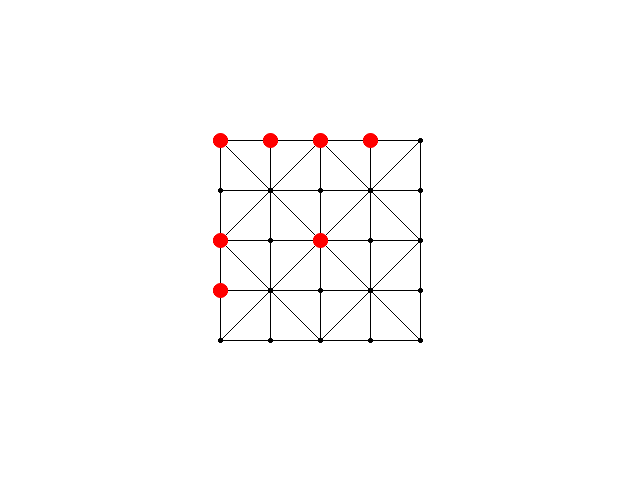

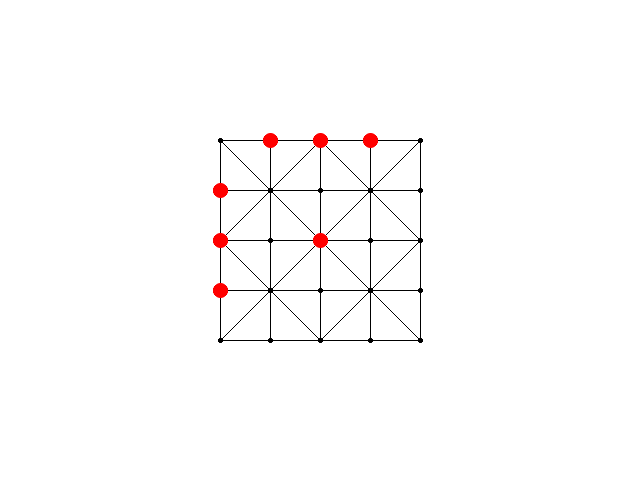

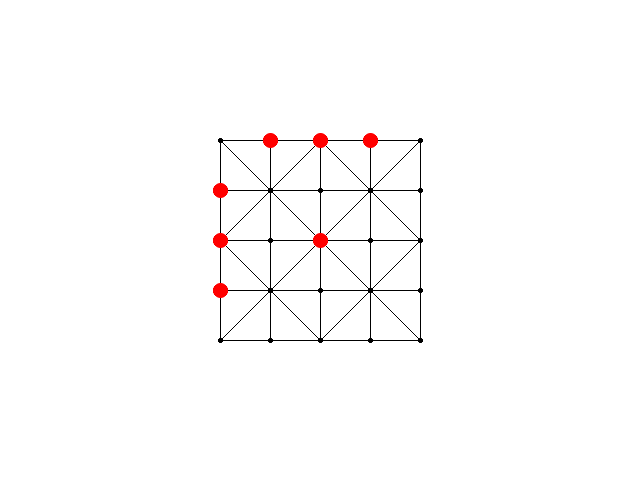

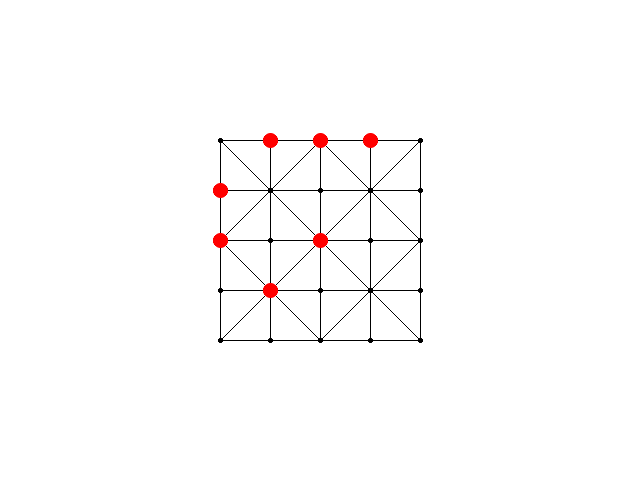

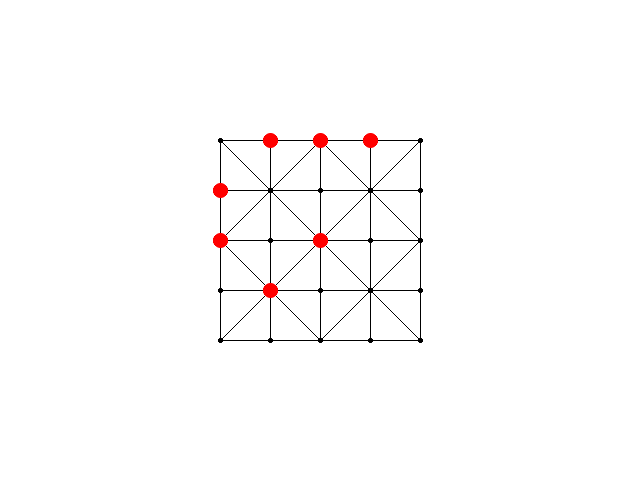

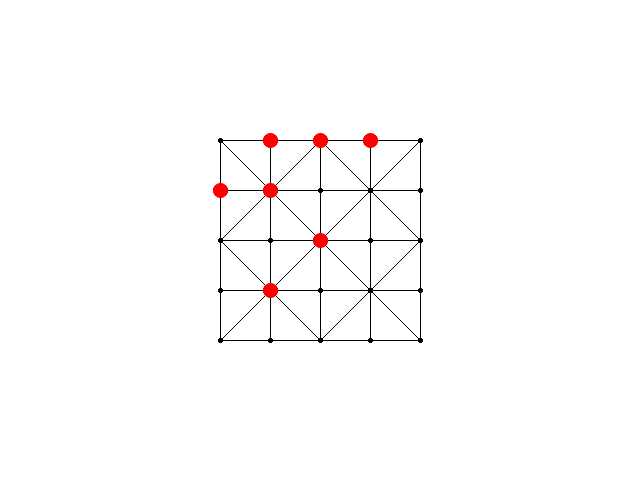

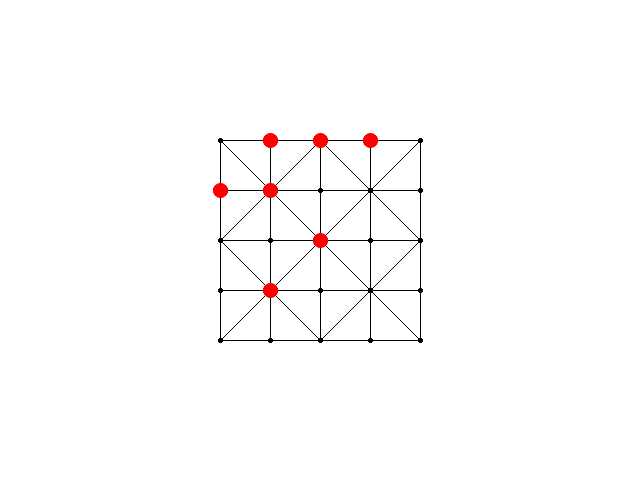

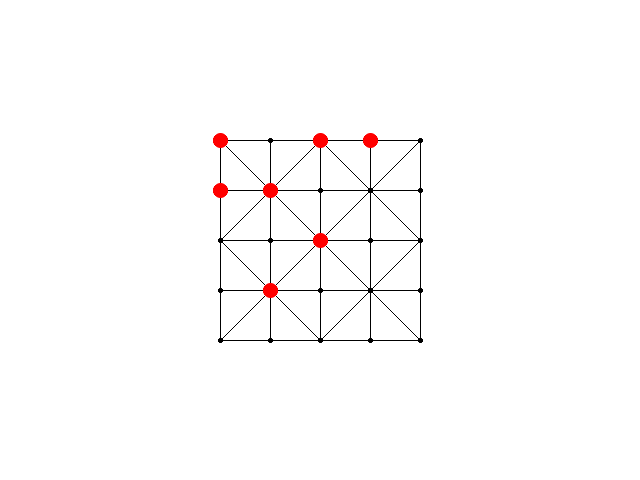

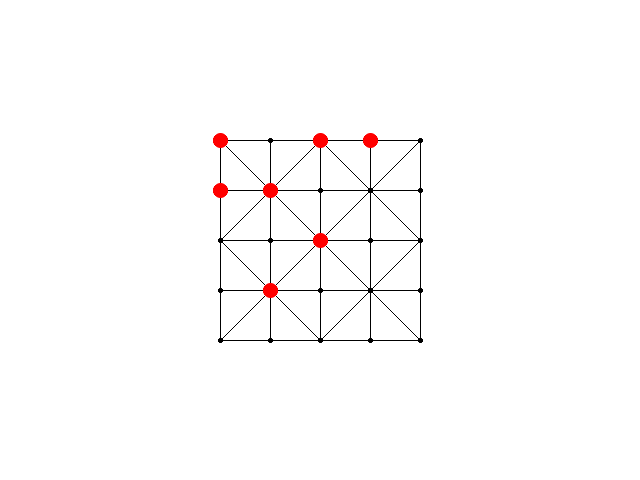

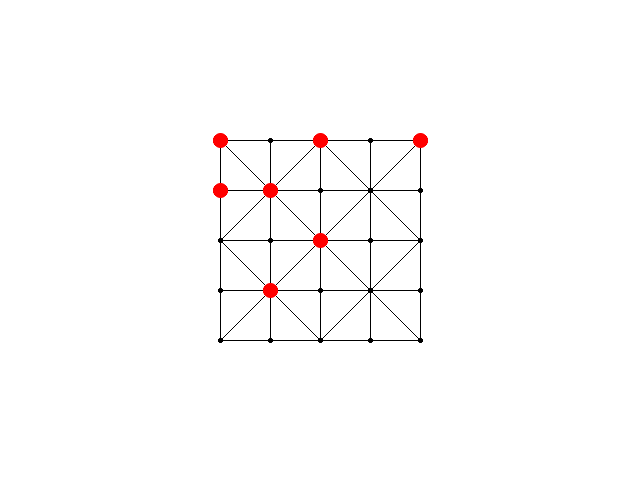

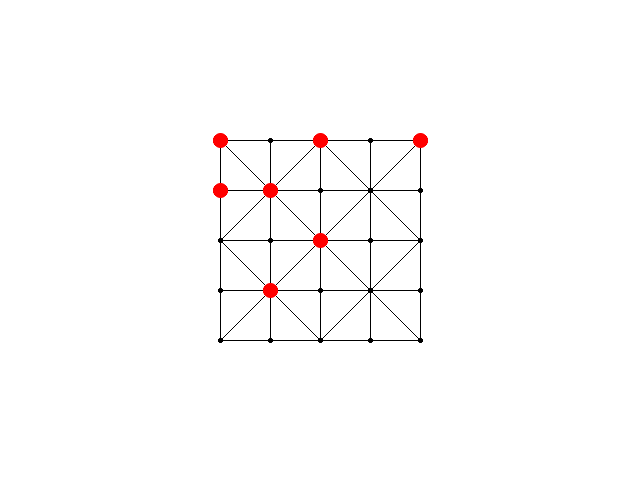

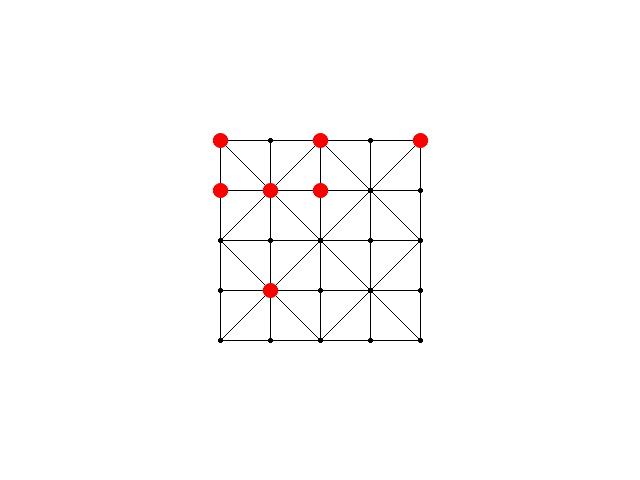

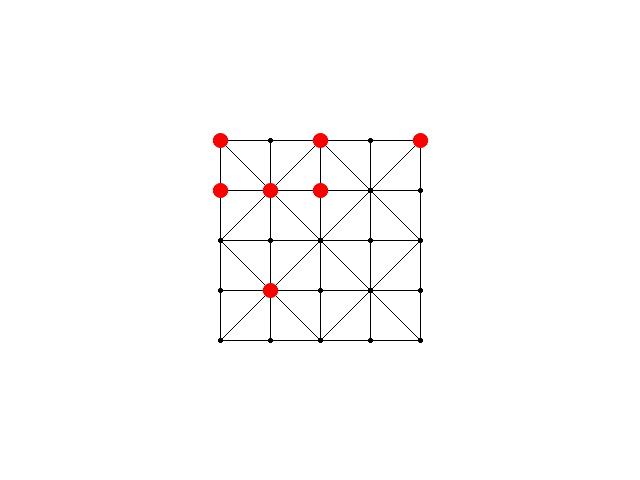

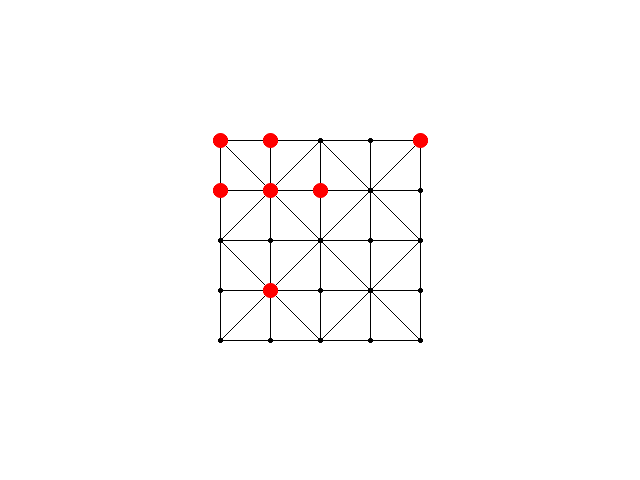

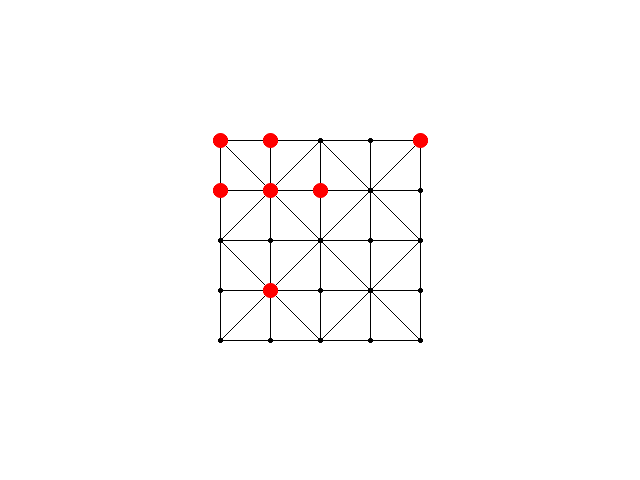

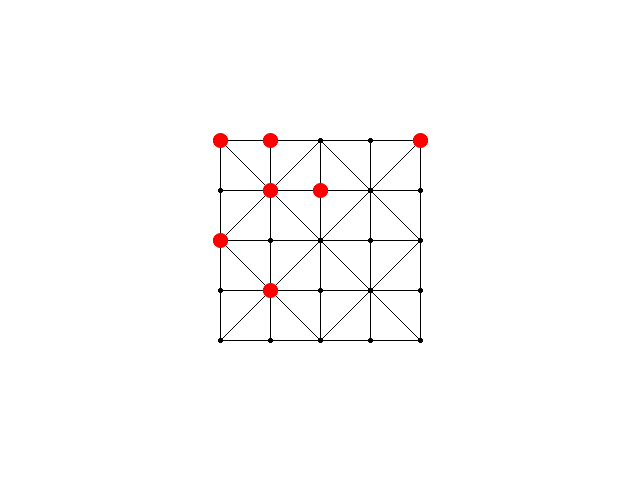

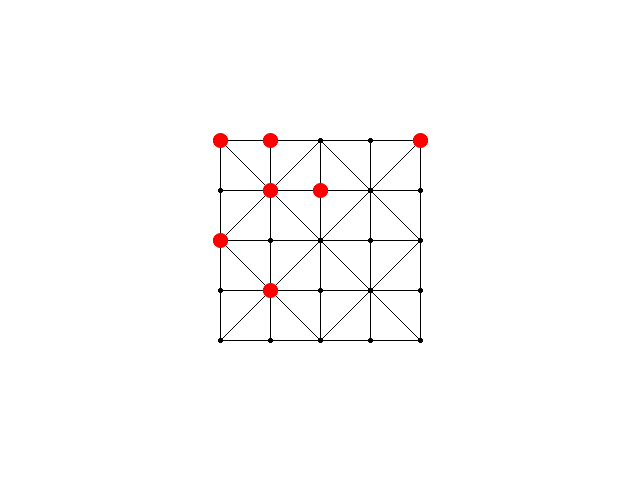

Player 1 wins


1

In [15]:
# example 2:
seed = 42
random.seed(seed)
player_1 = Min_Max_Player(1, maxdepth=3)
player_2 = Random_Player(2)
game = Game(player_1, player_2)
start_game(game, graphics=True)

### Random player vs Alpha-Beta player

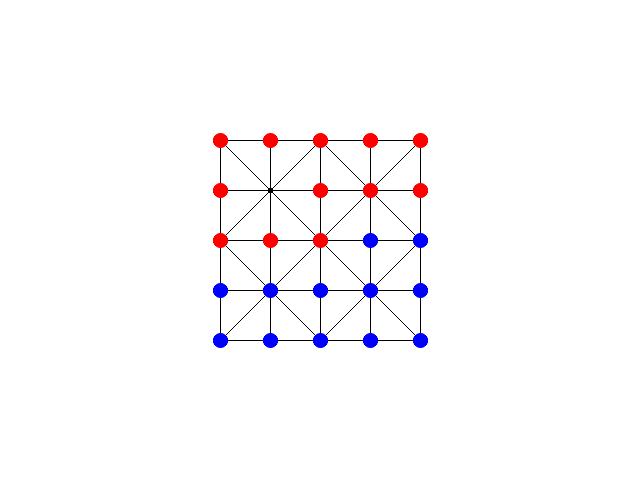

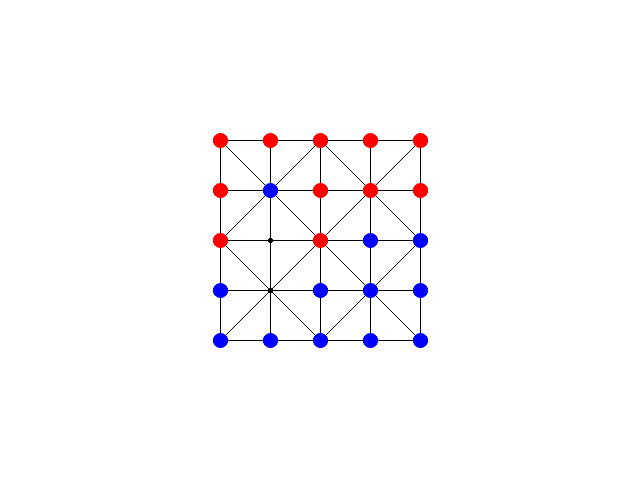

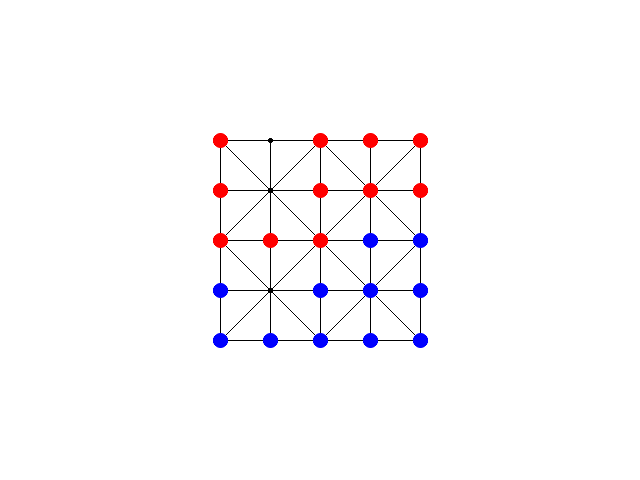

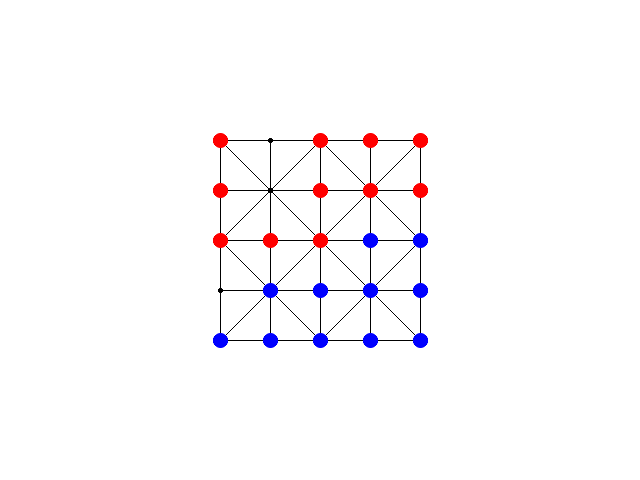

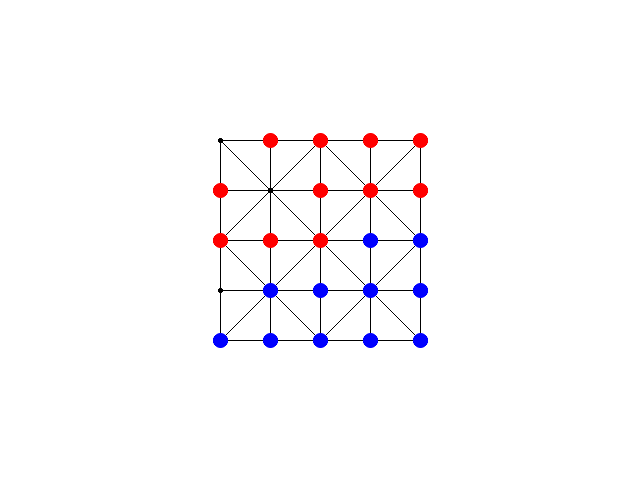

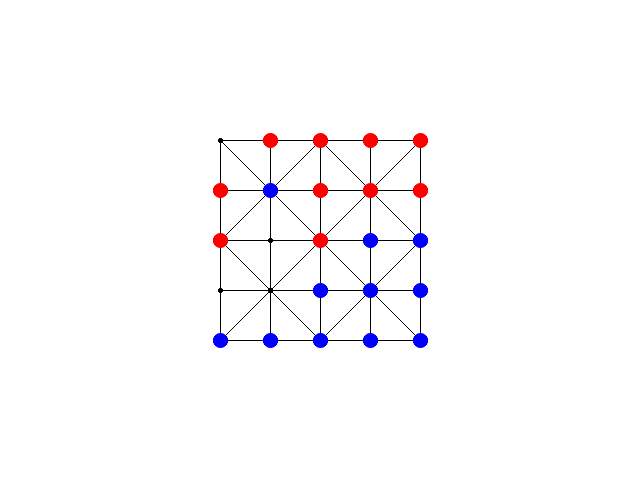

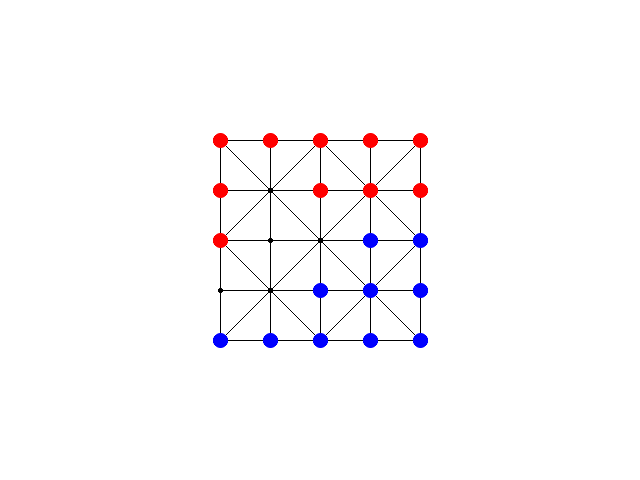

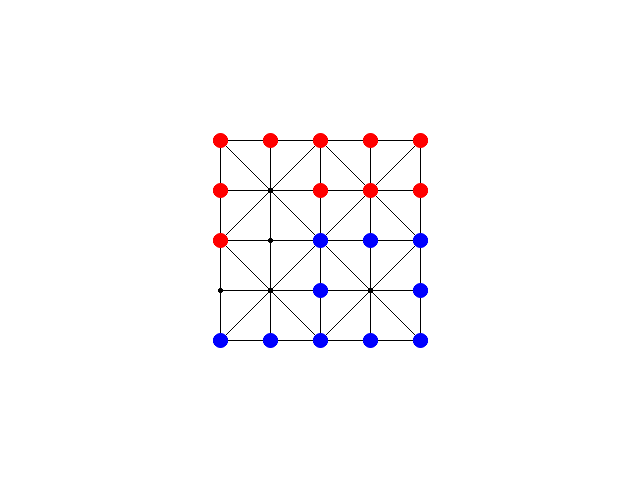

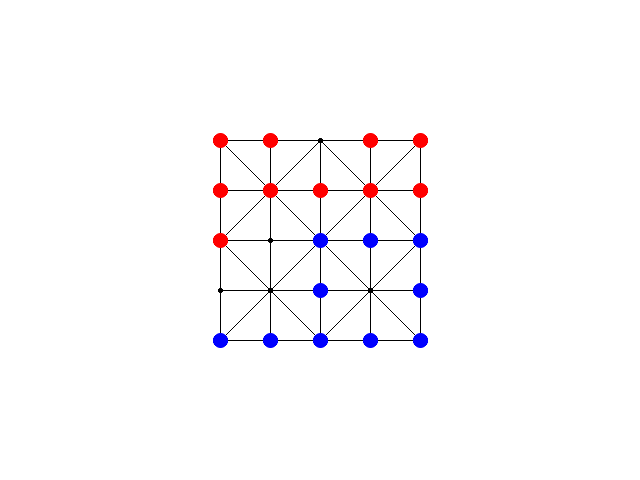

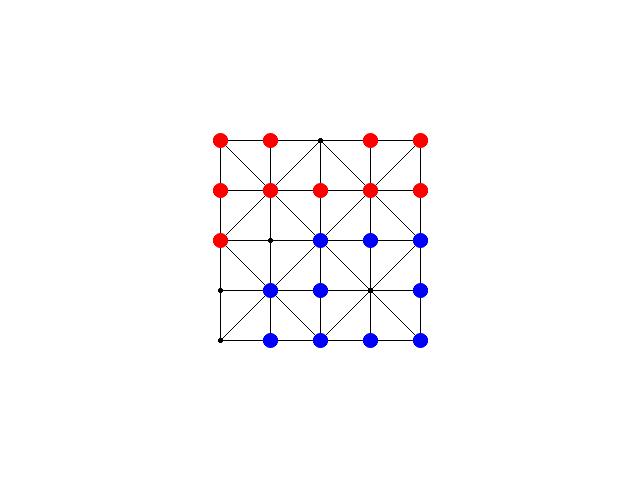

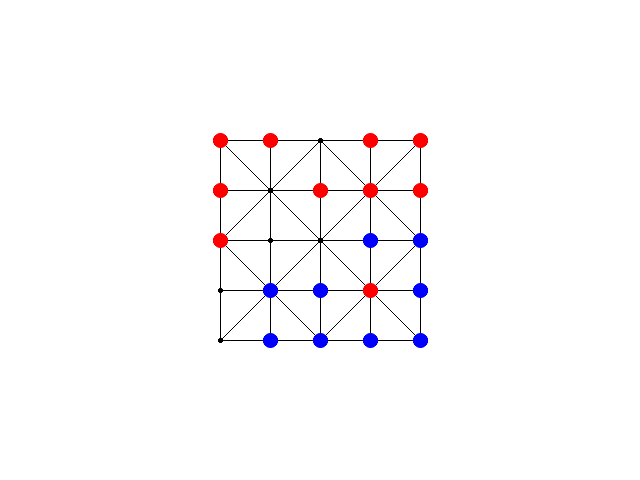

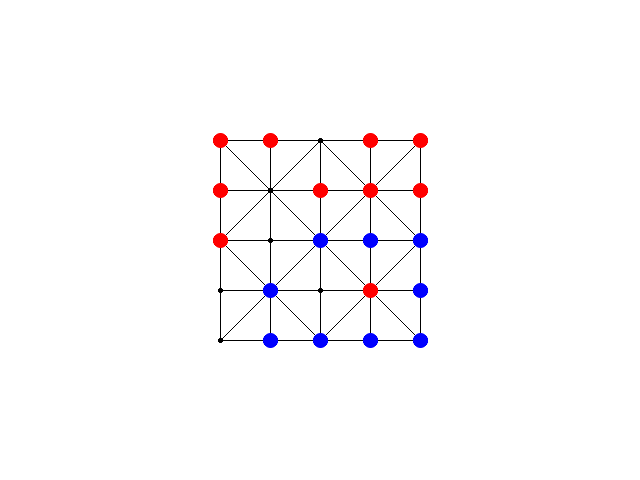

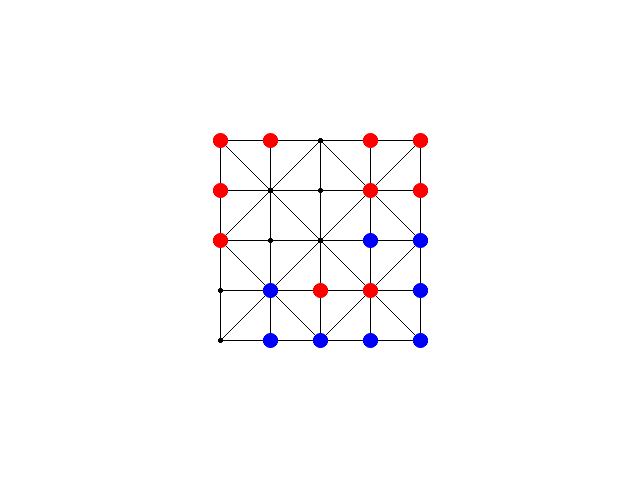

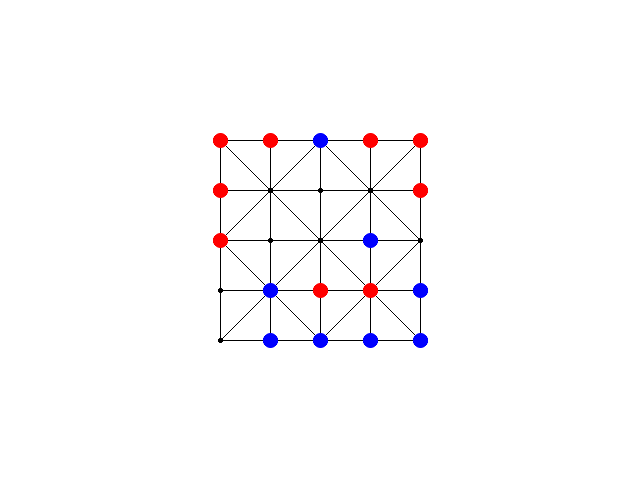

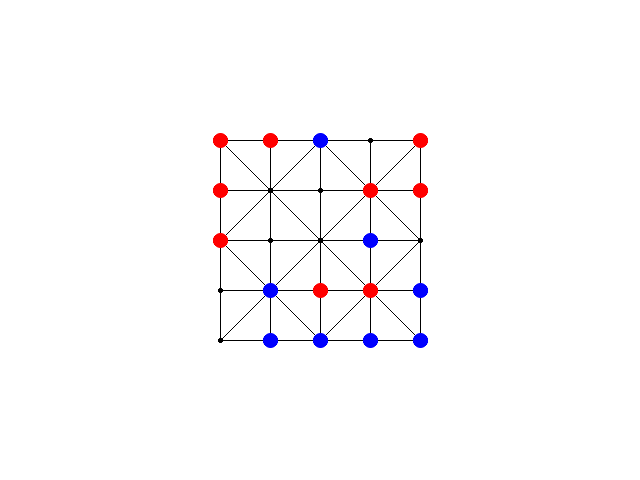

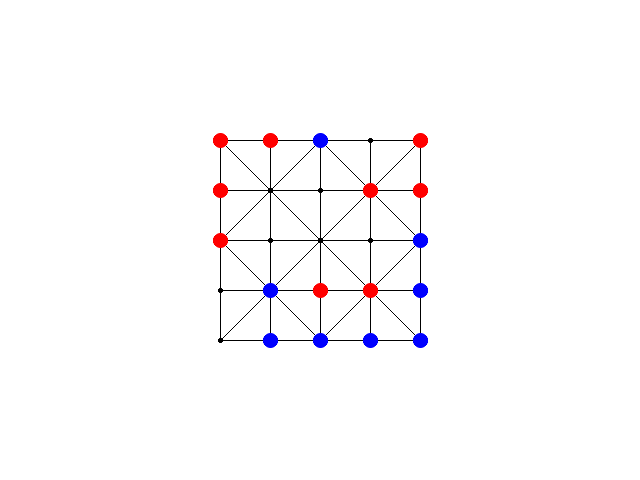

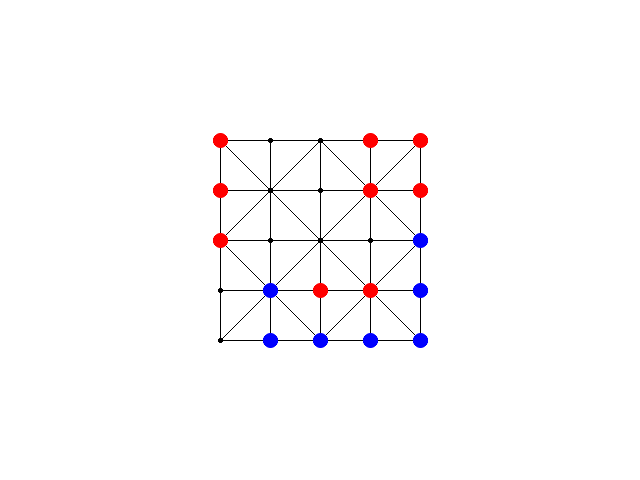

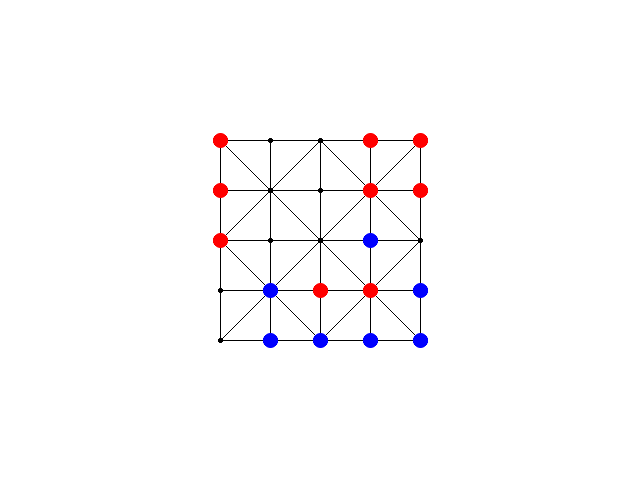

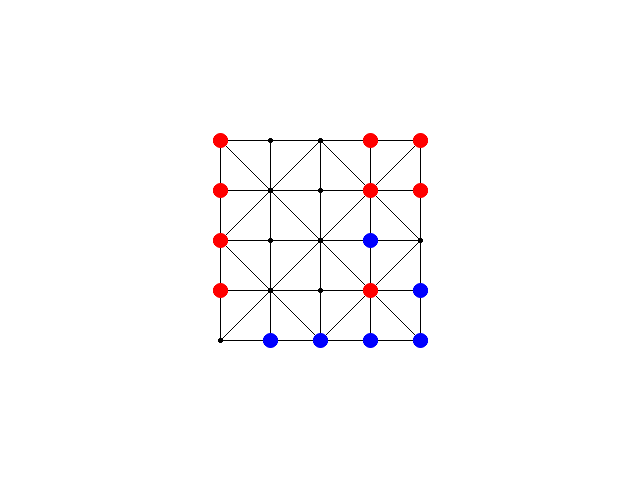

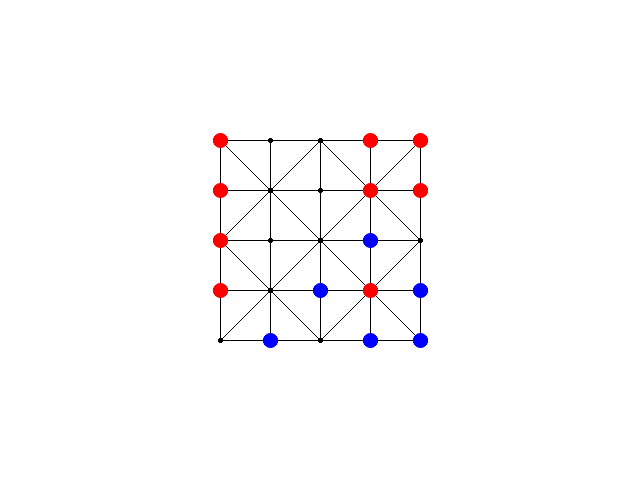

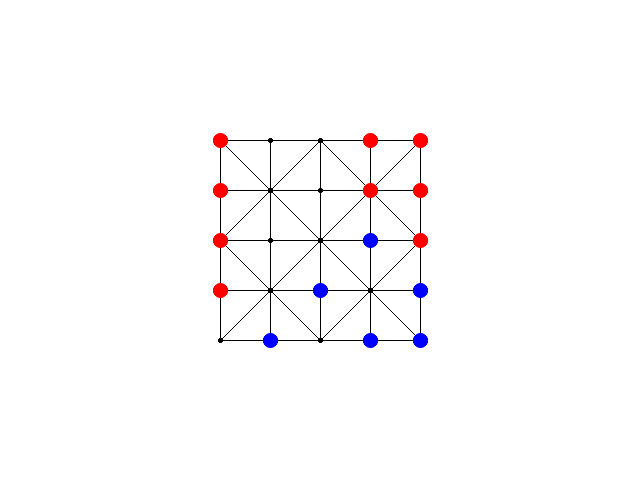

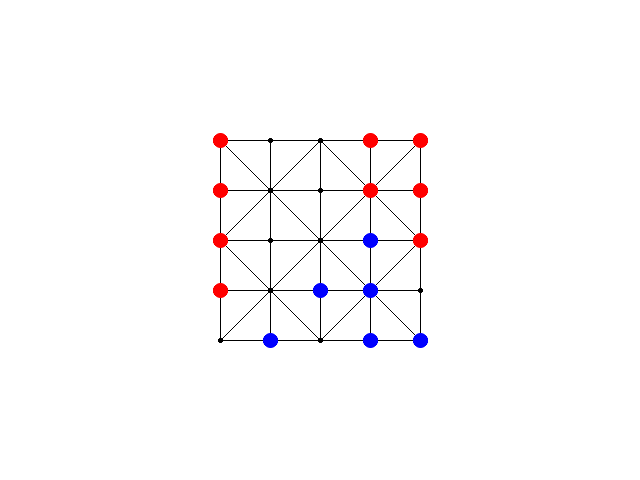

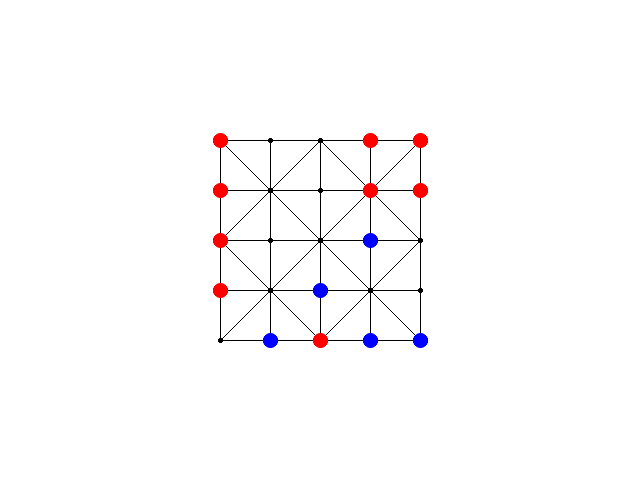

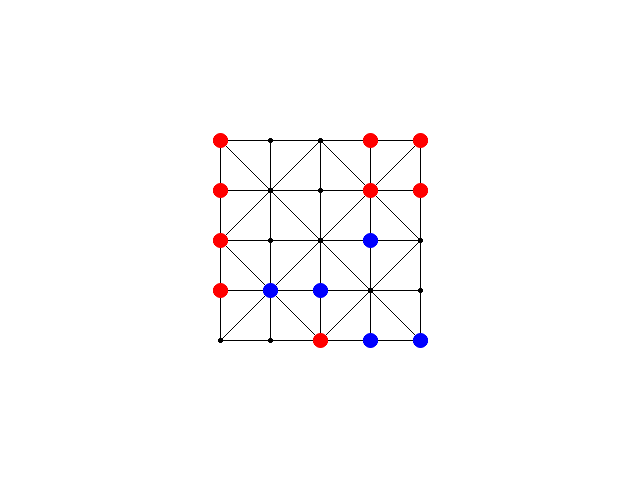

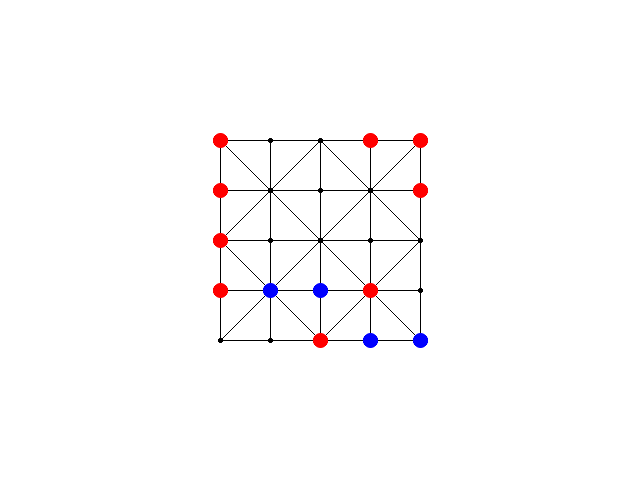

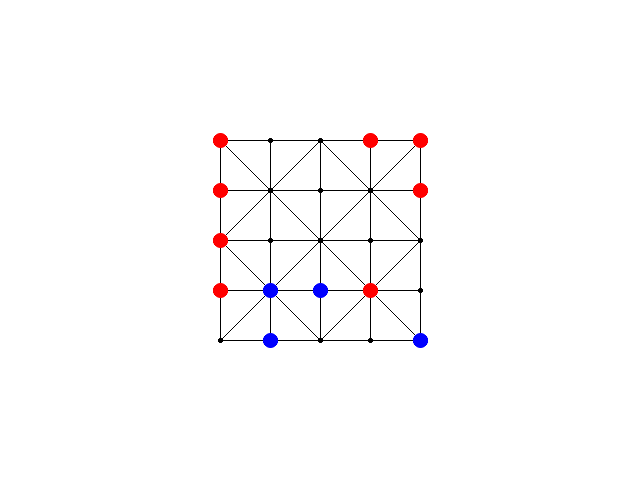

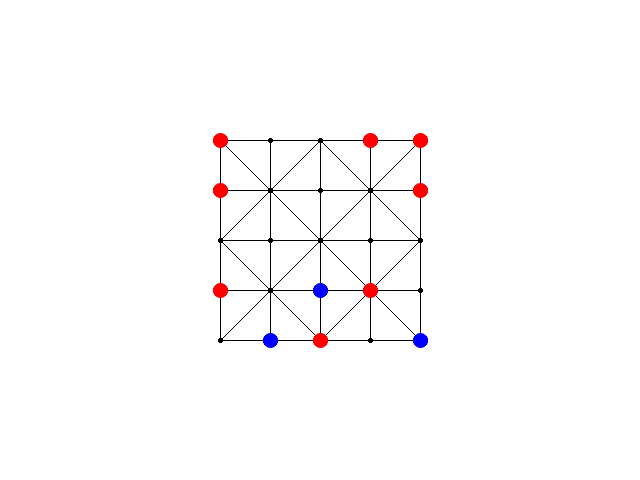

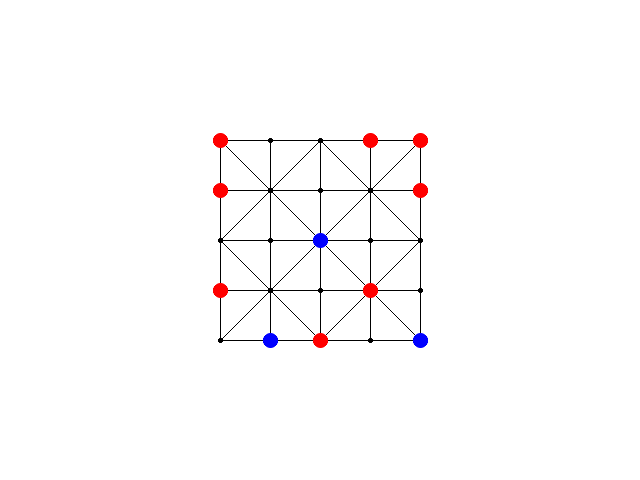

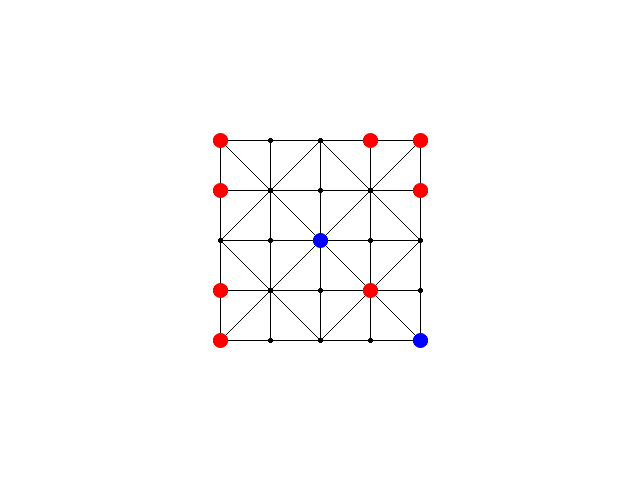

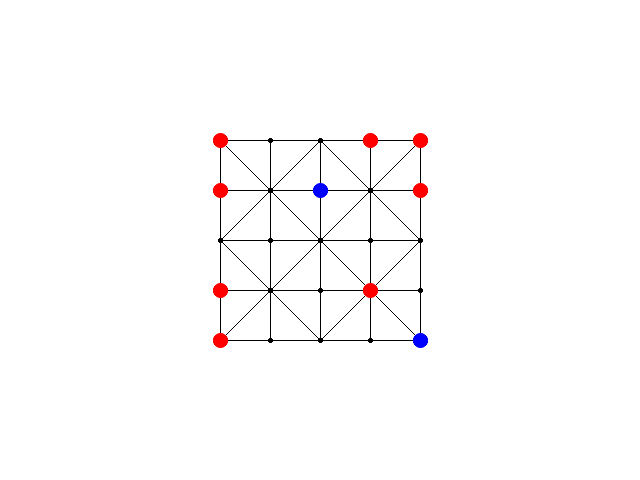

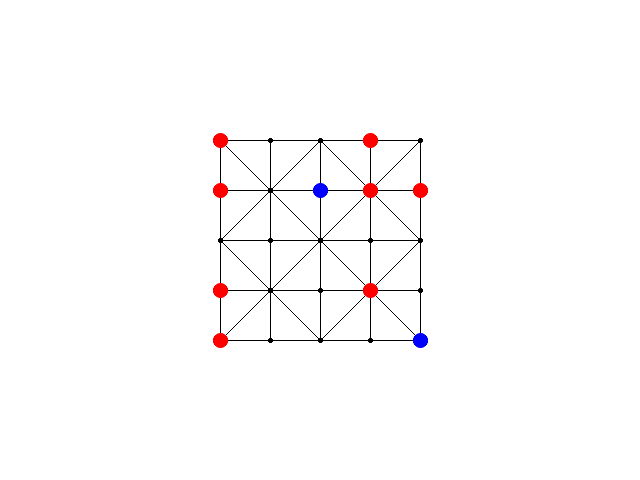

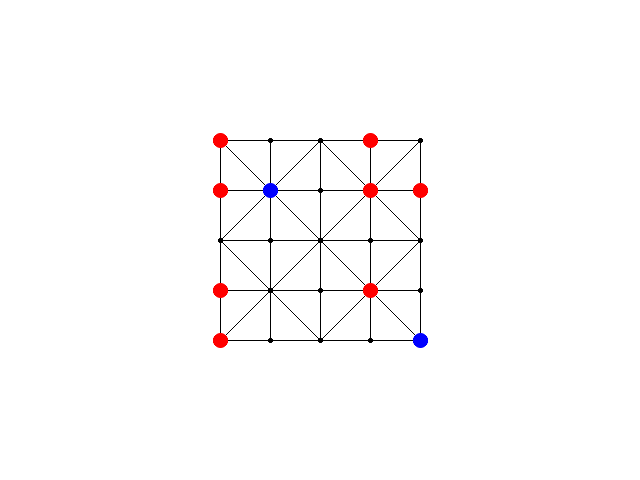

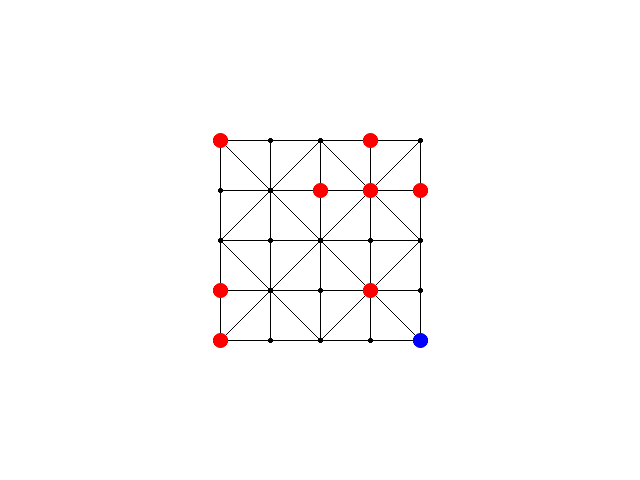

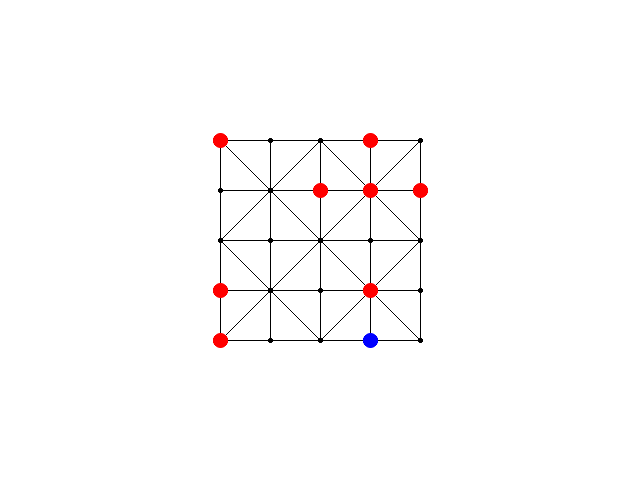

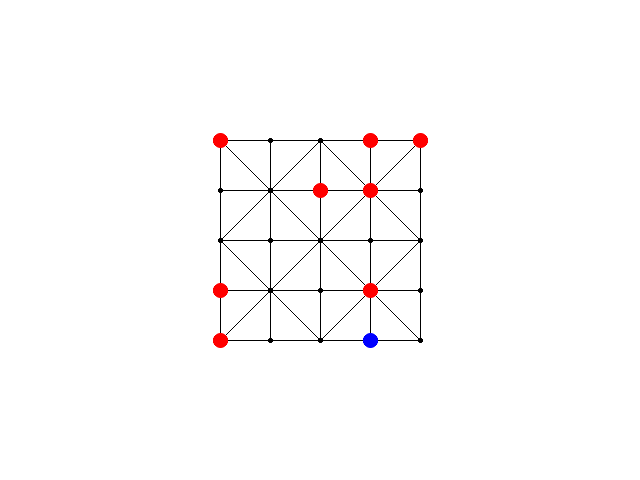

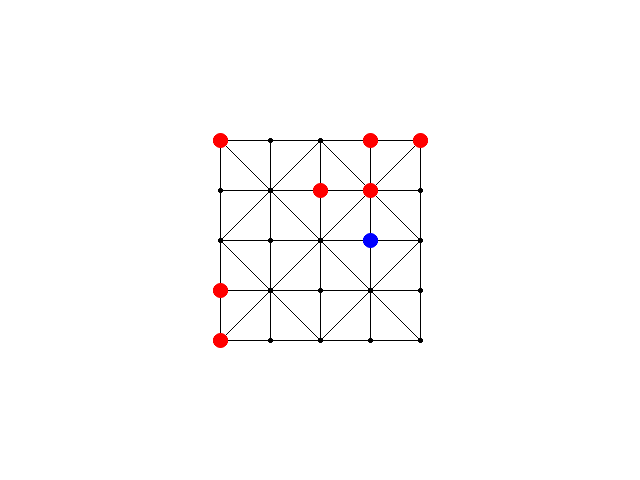

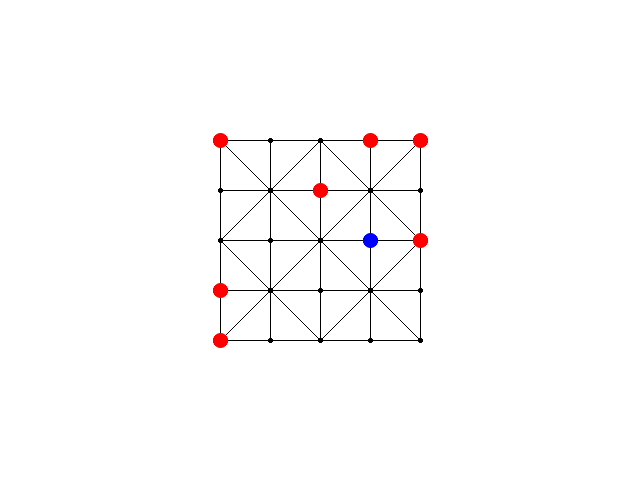

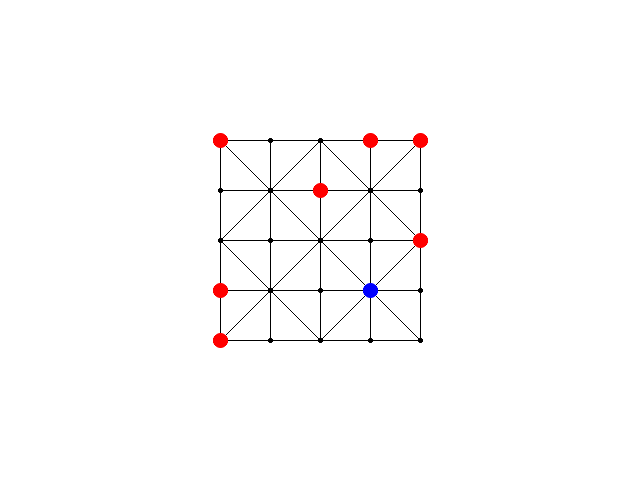

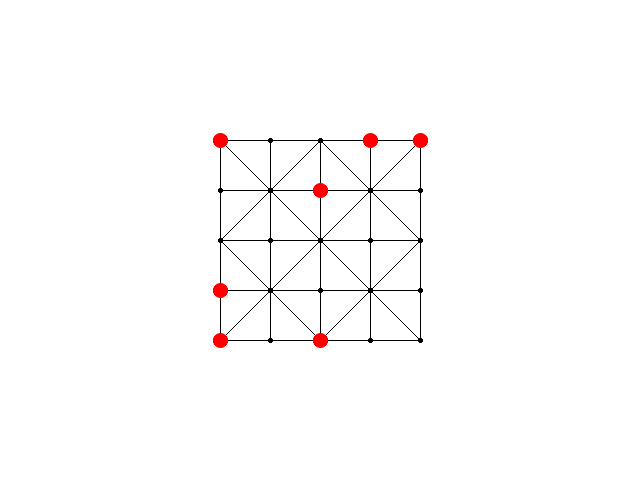

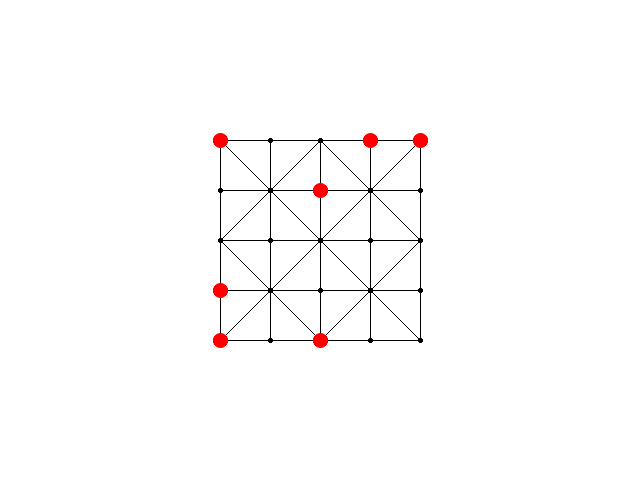

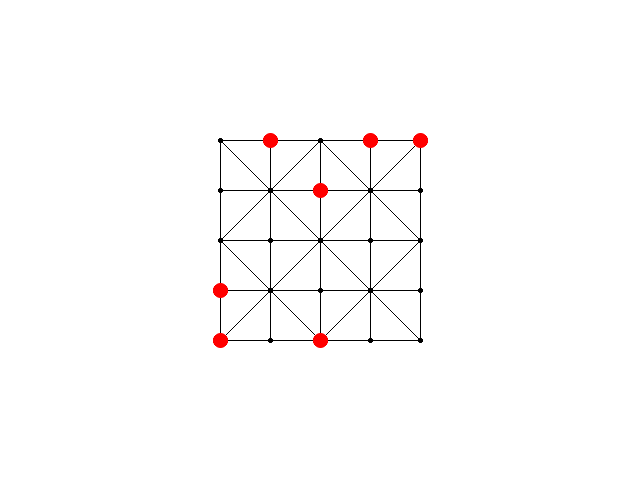

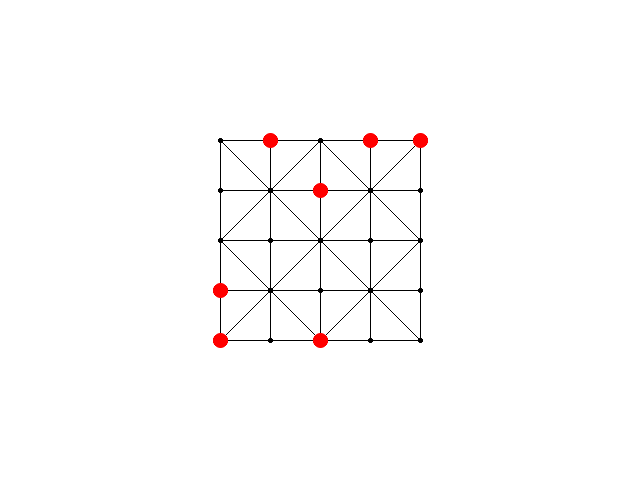

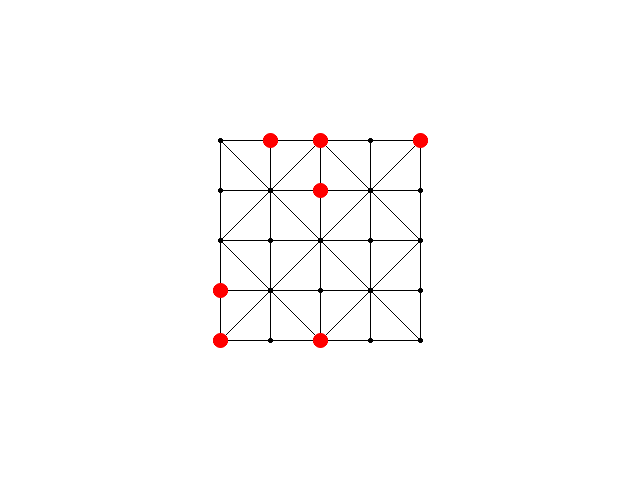

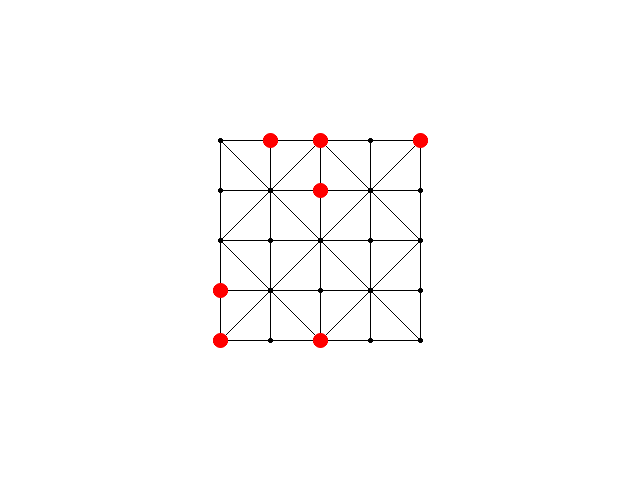

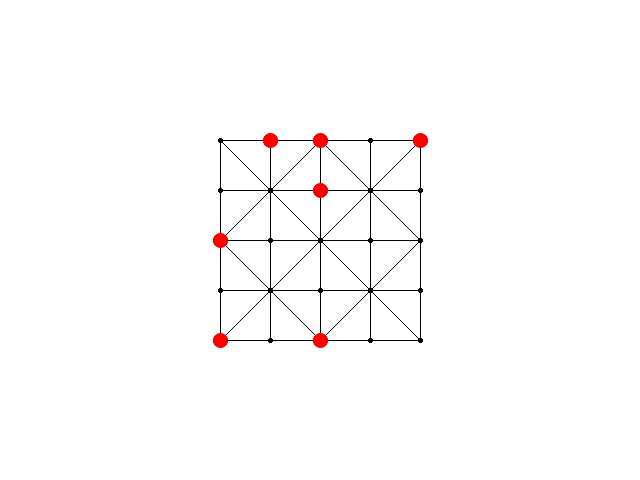

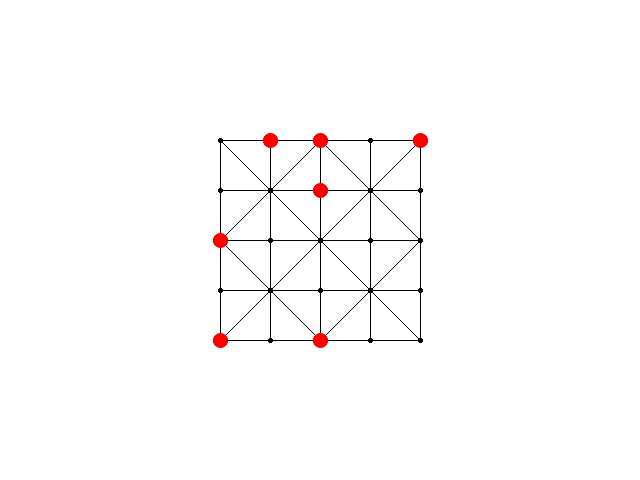

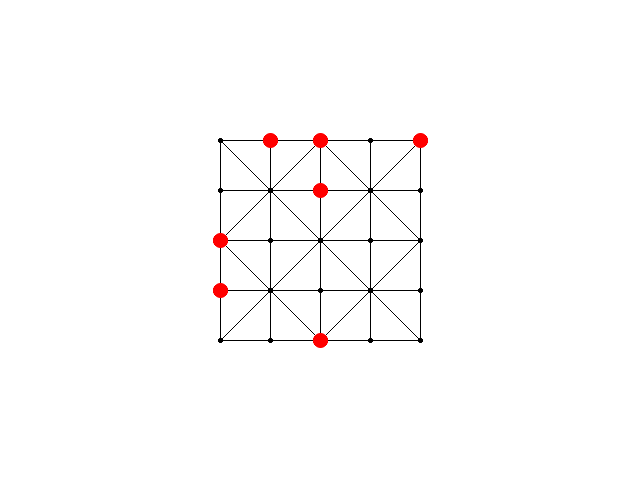

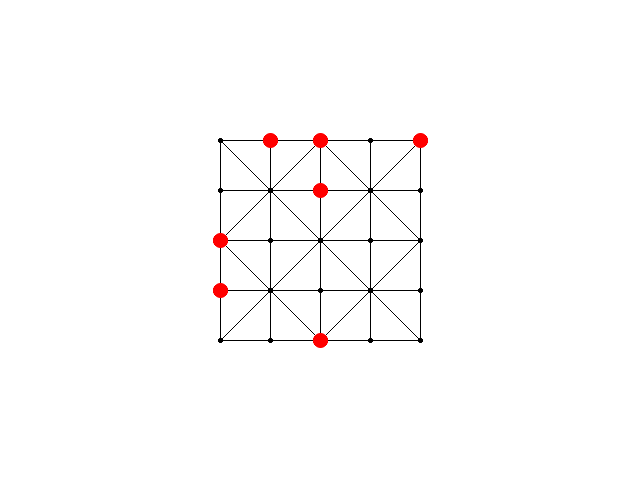

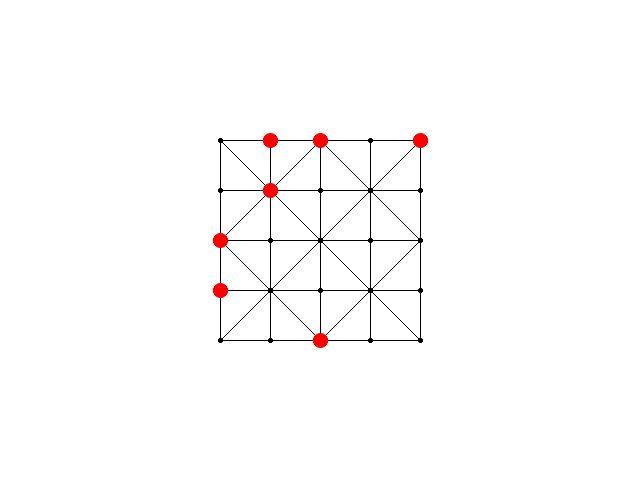

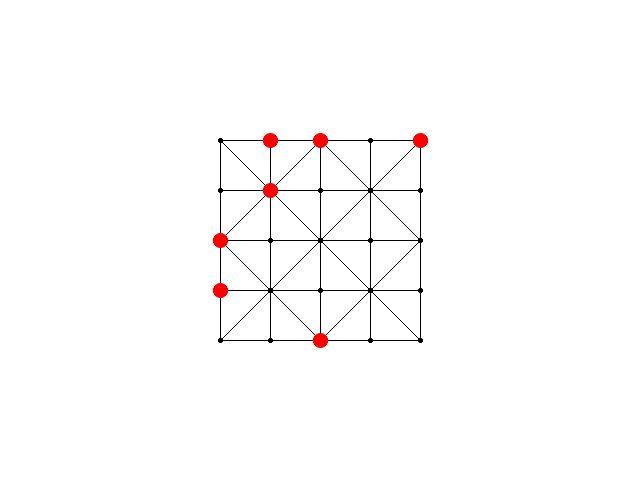

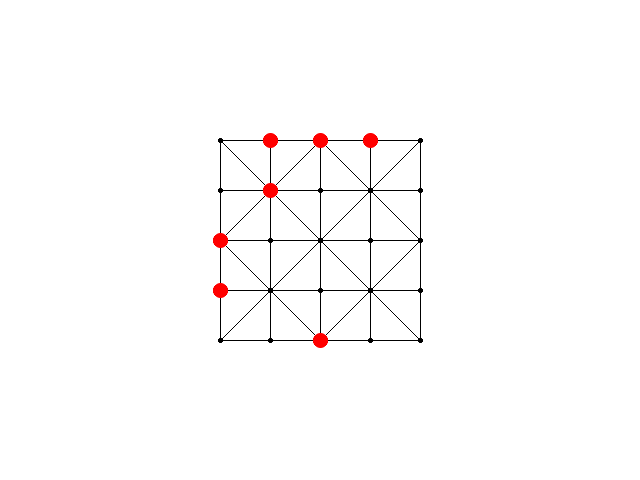

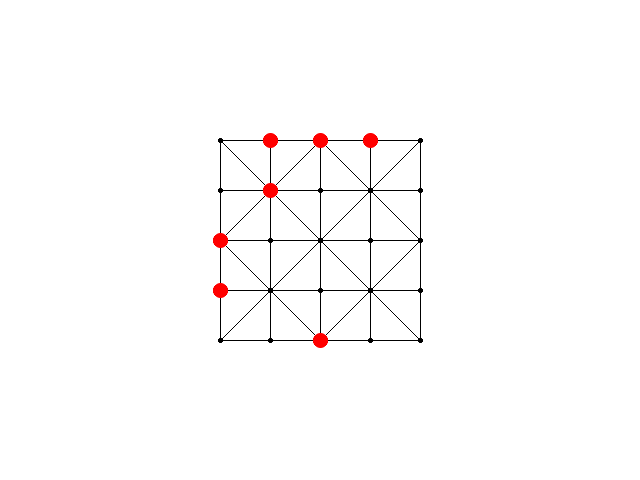

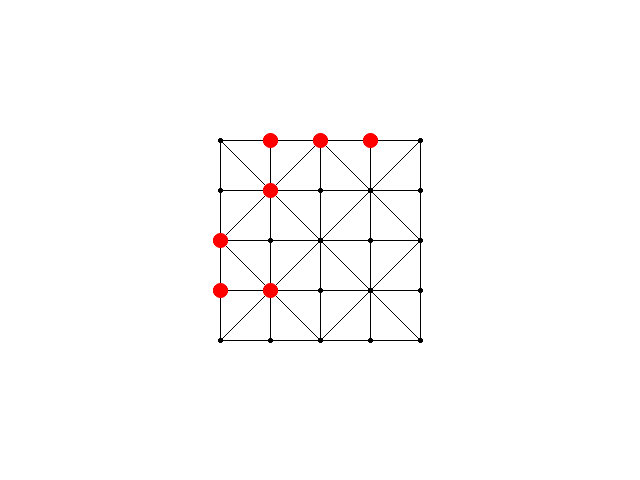

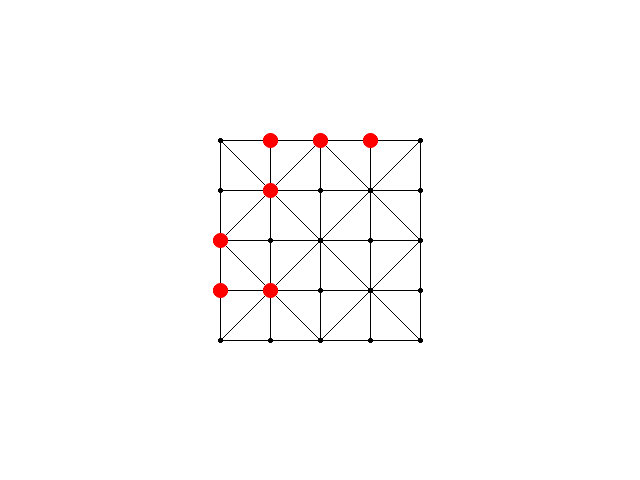

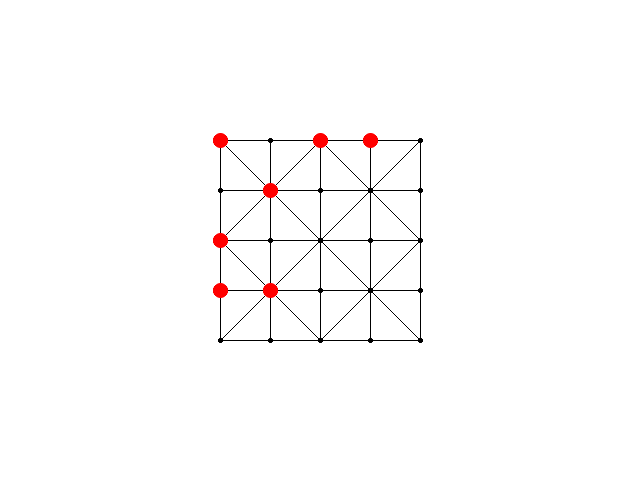

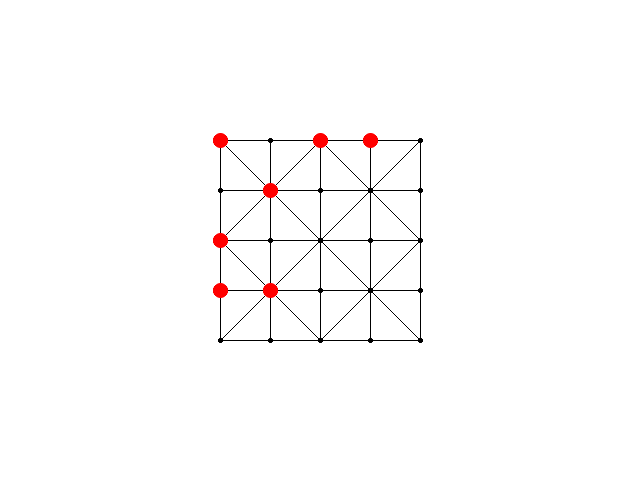

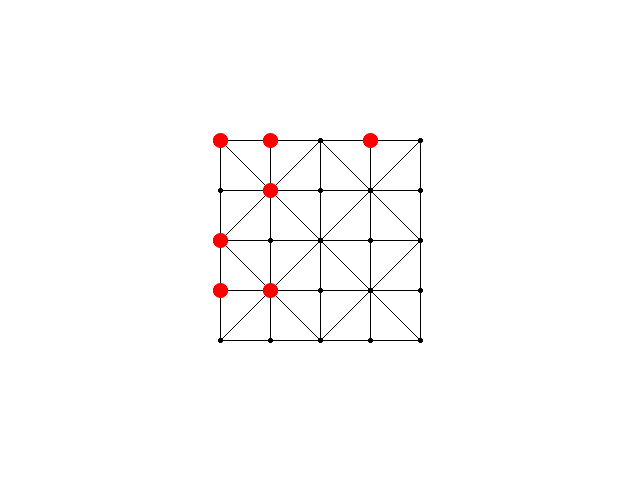

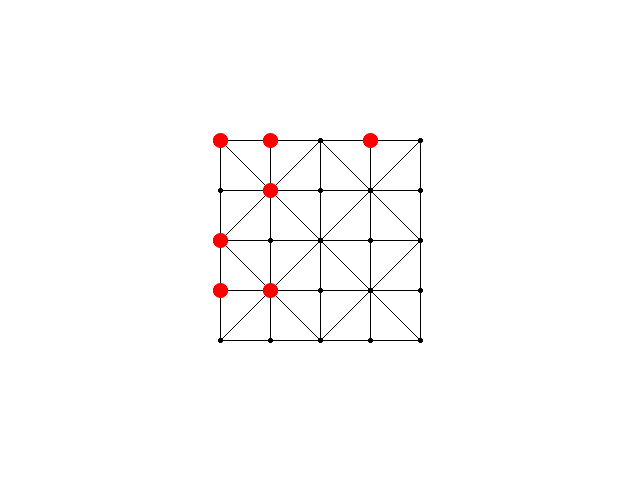

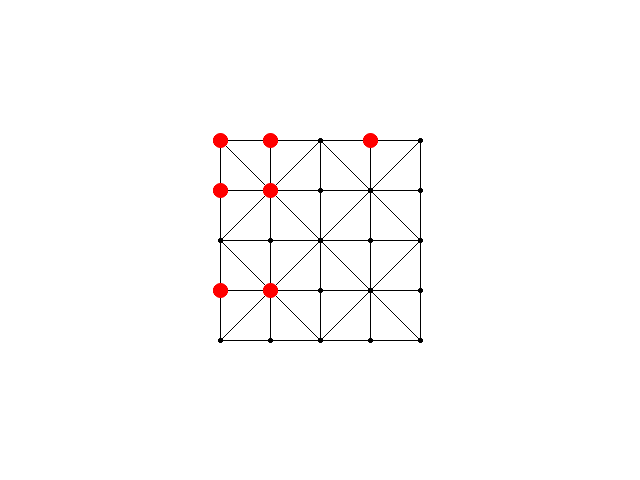

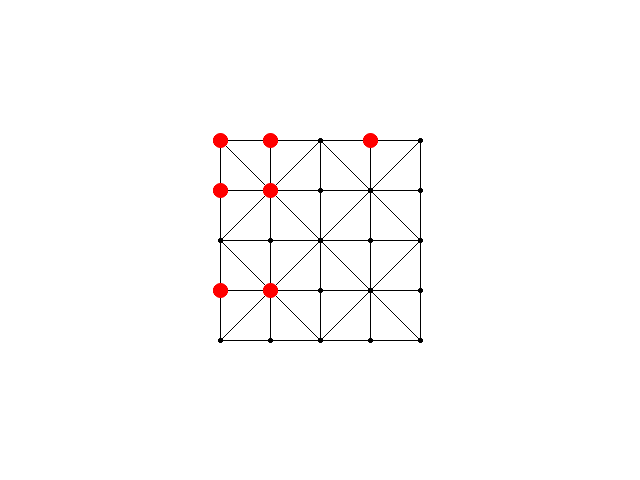

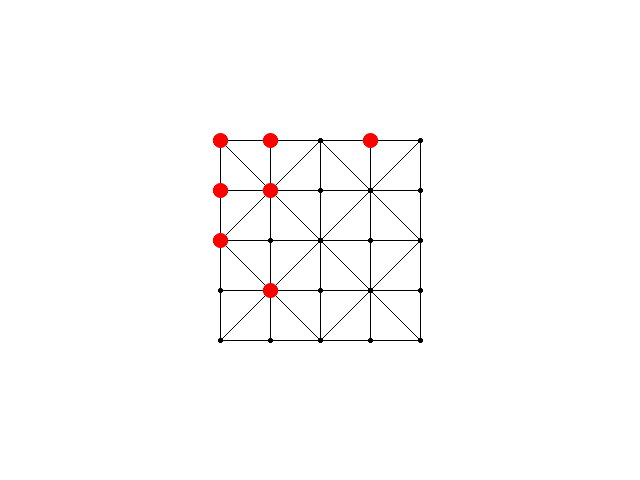

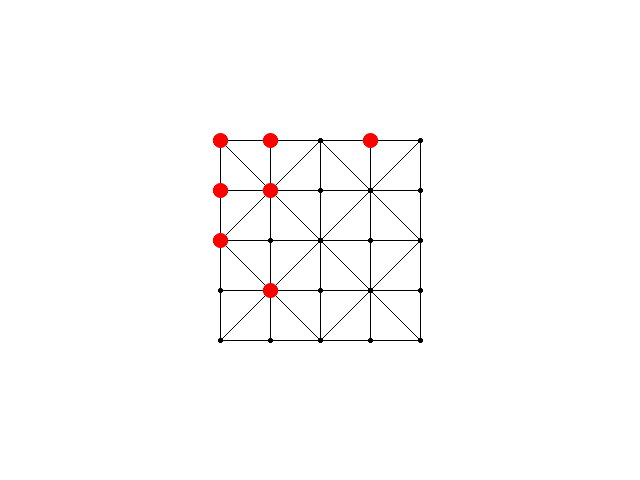

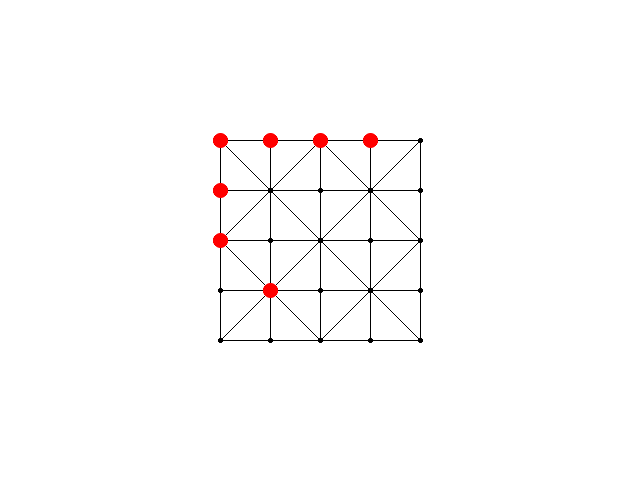

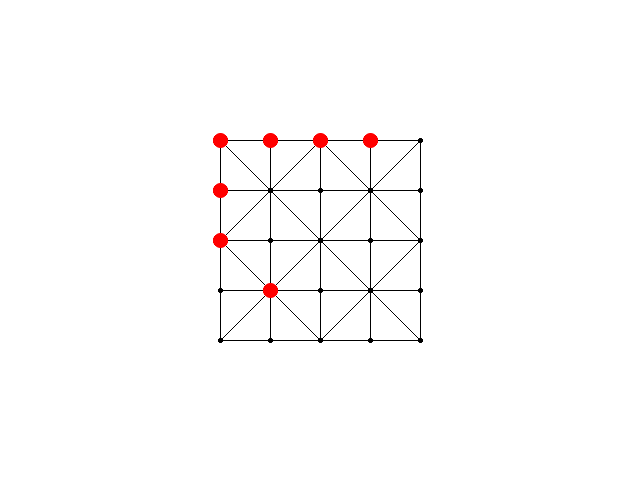

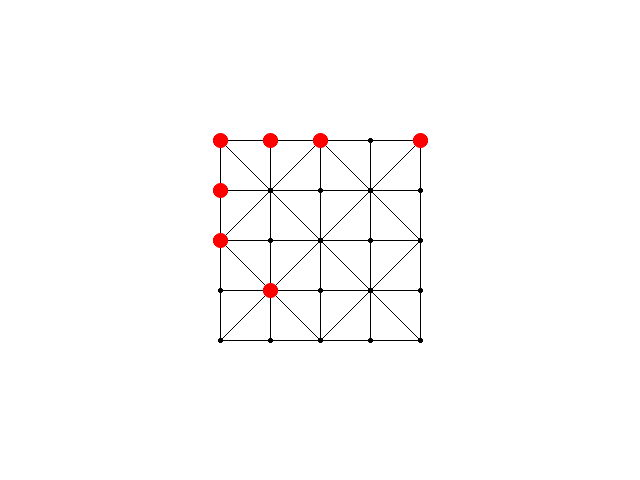

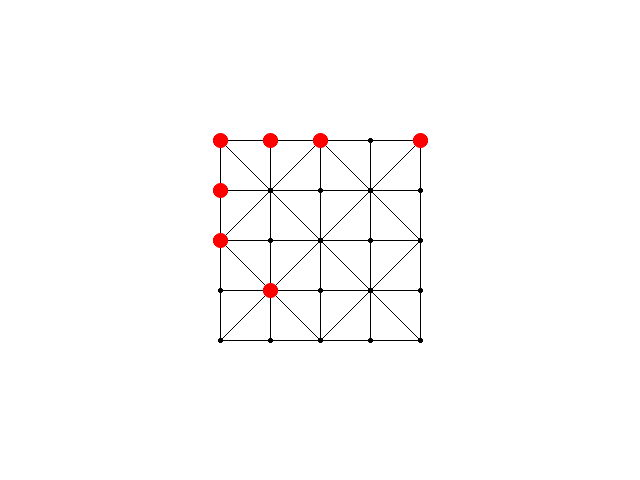

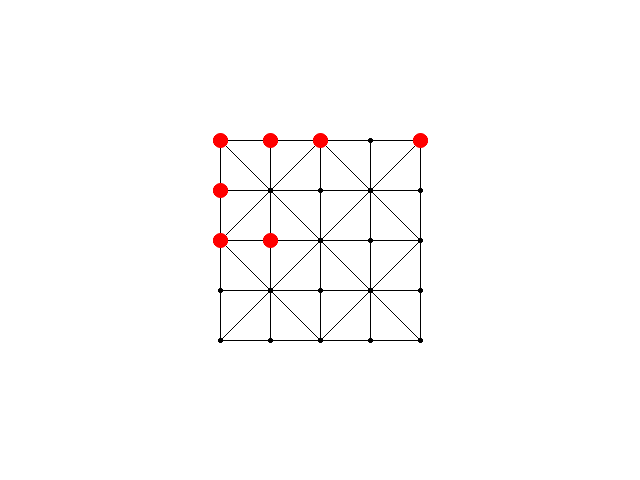

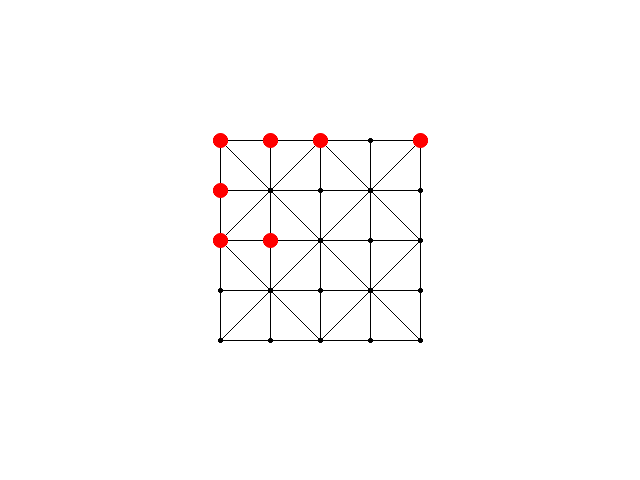

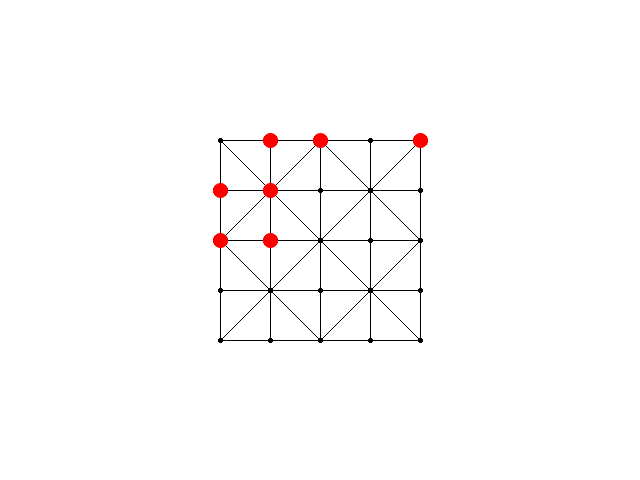

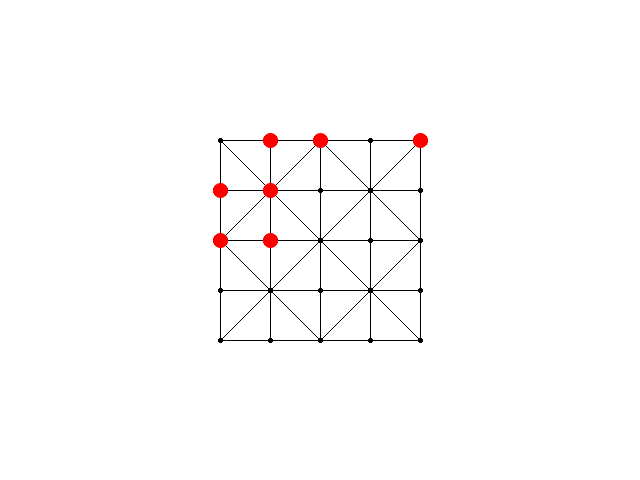

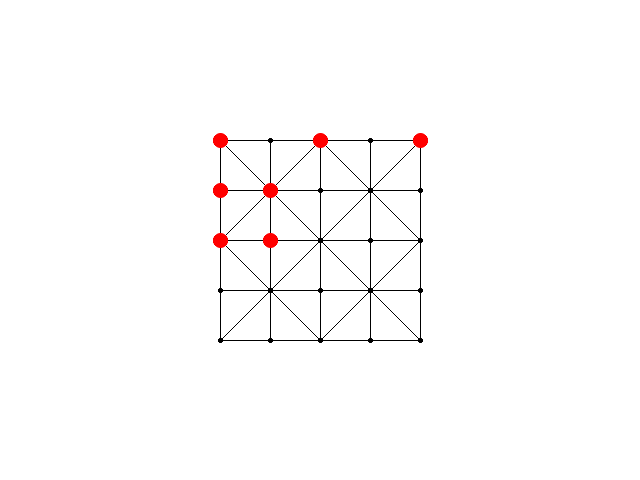

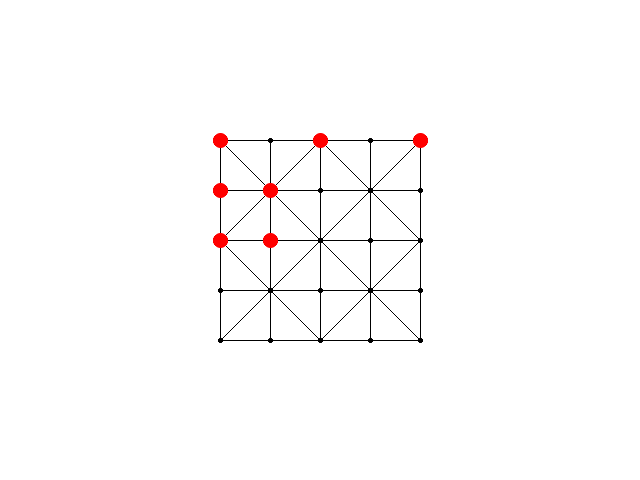

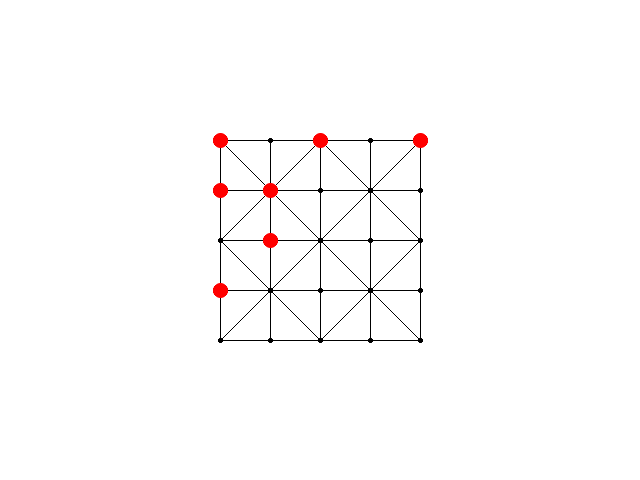

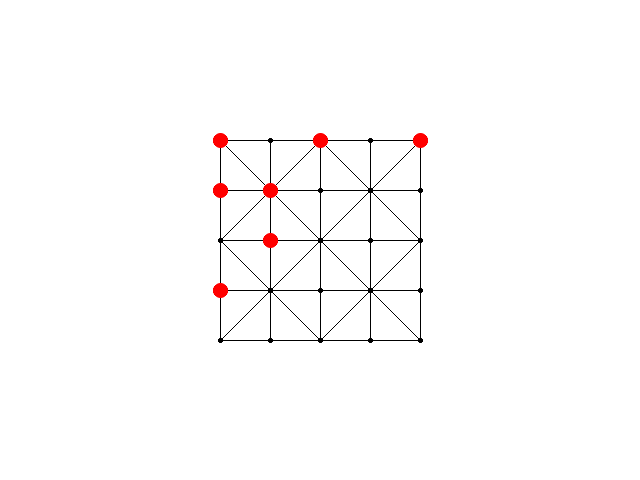

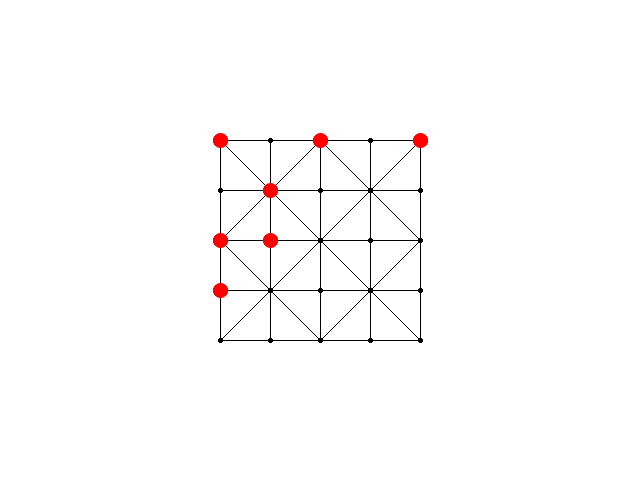

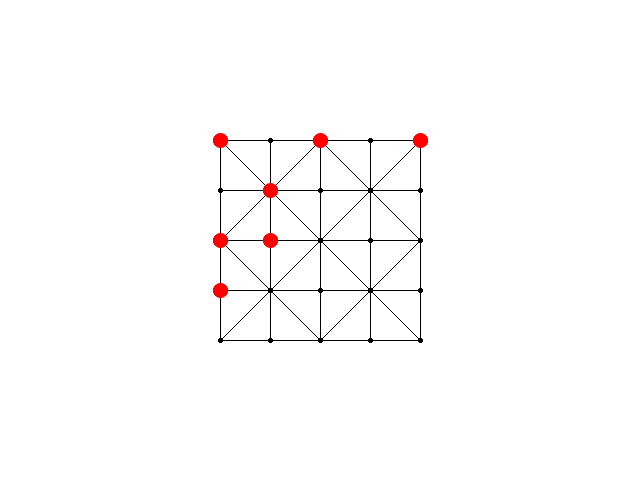

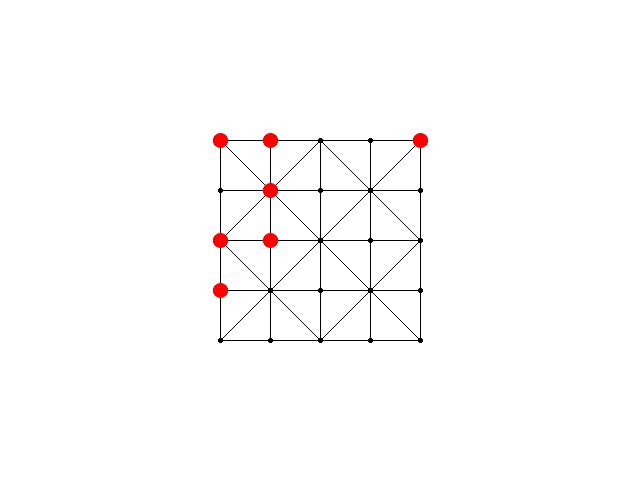

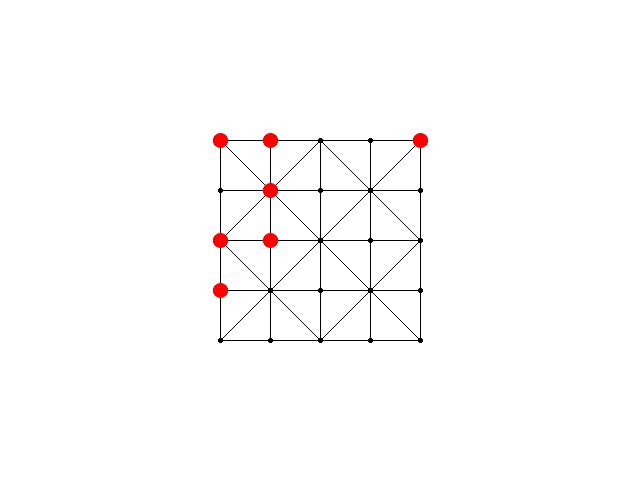

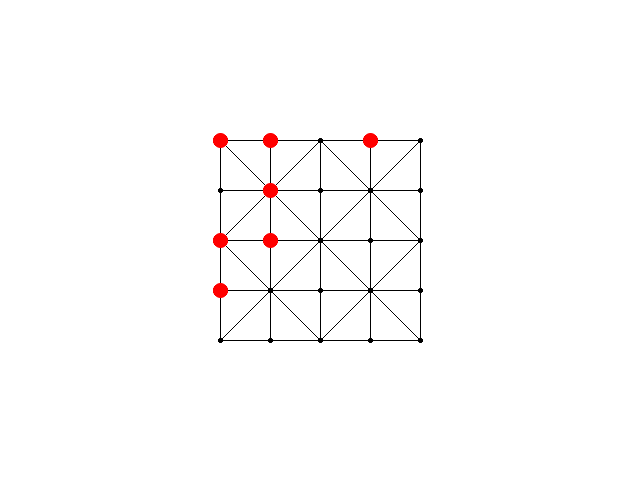

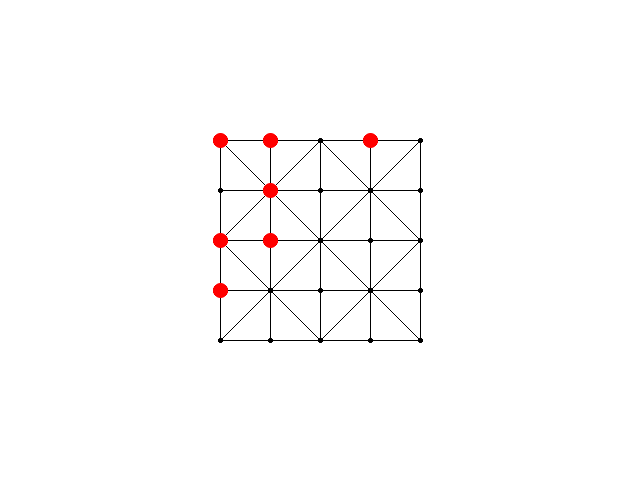

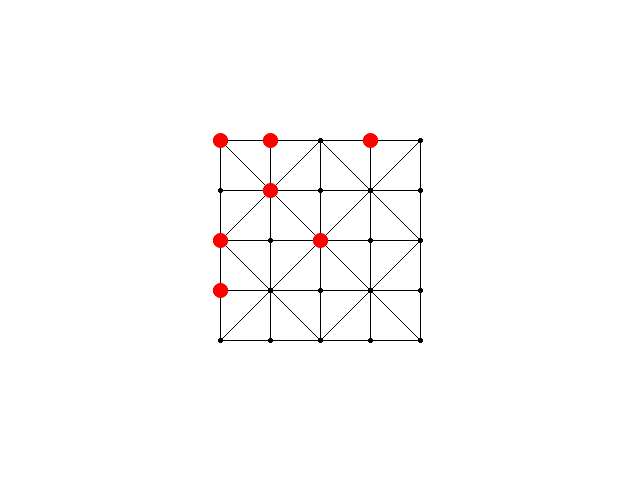

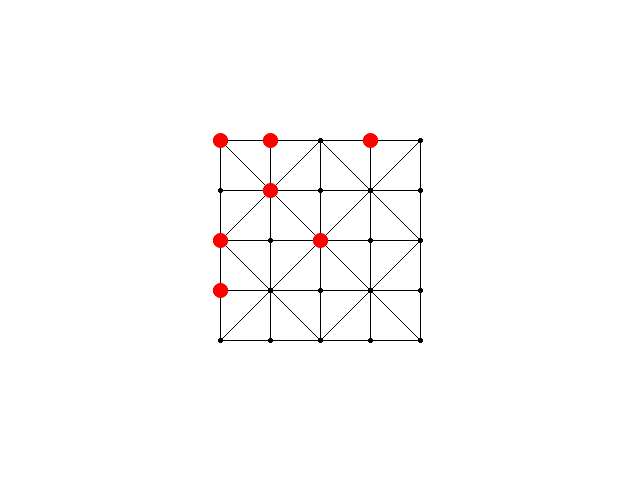

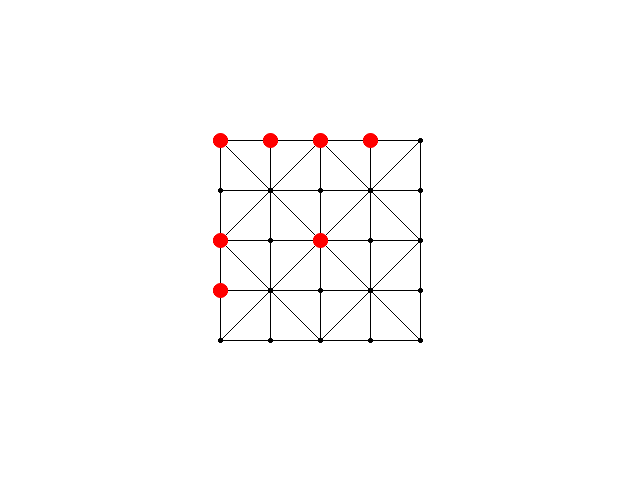

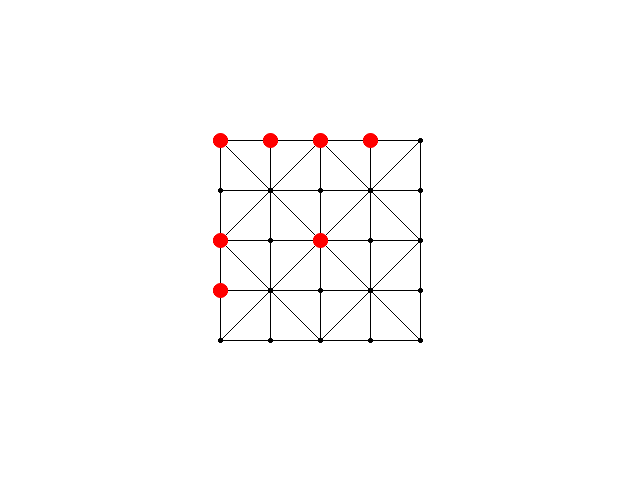

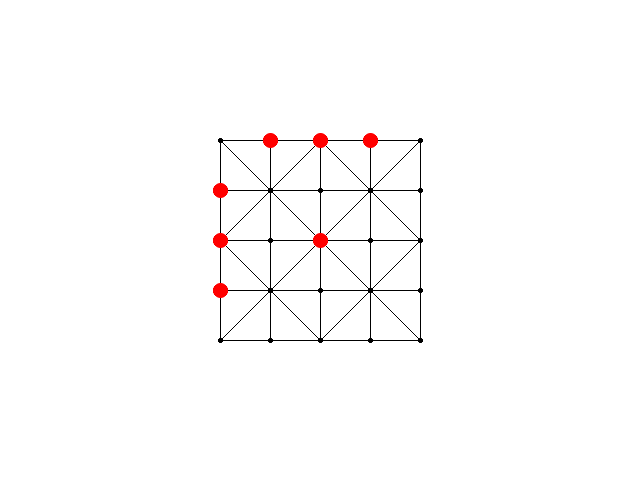

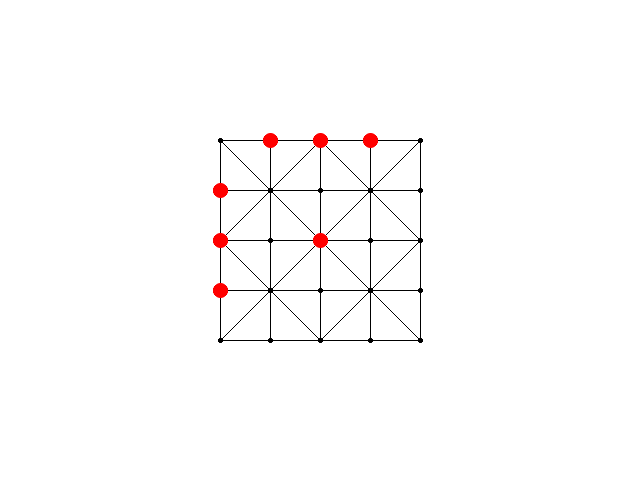

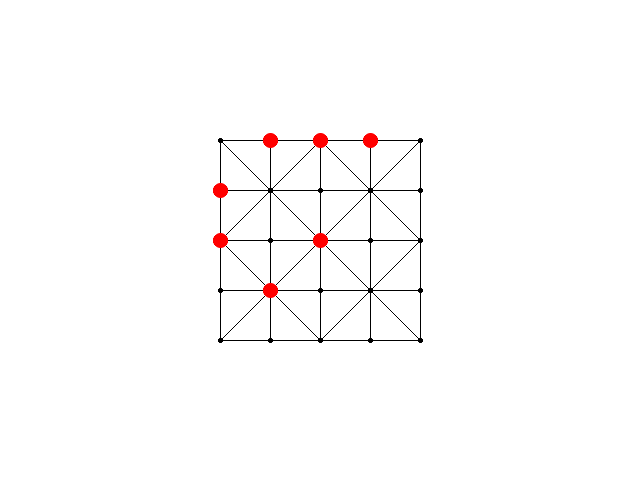

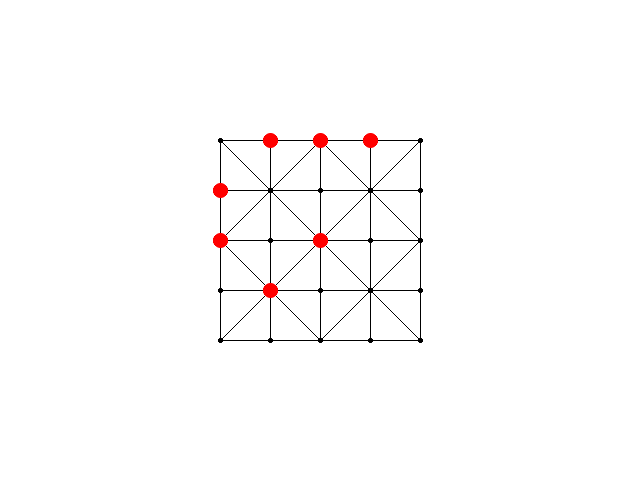

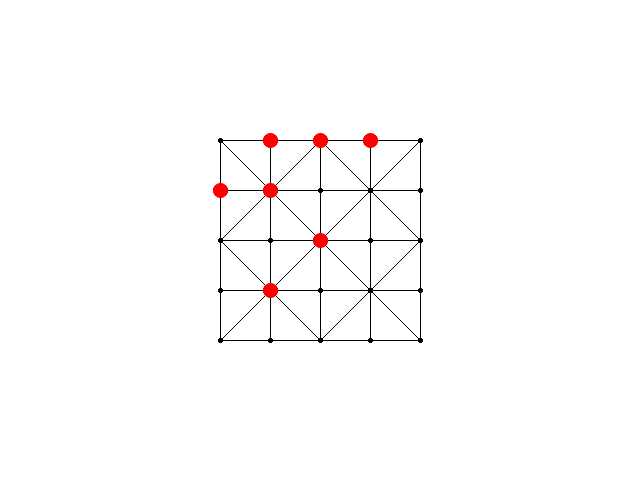

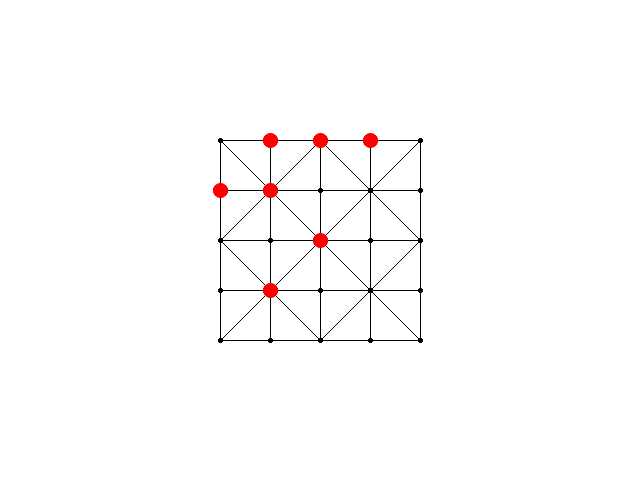

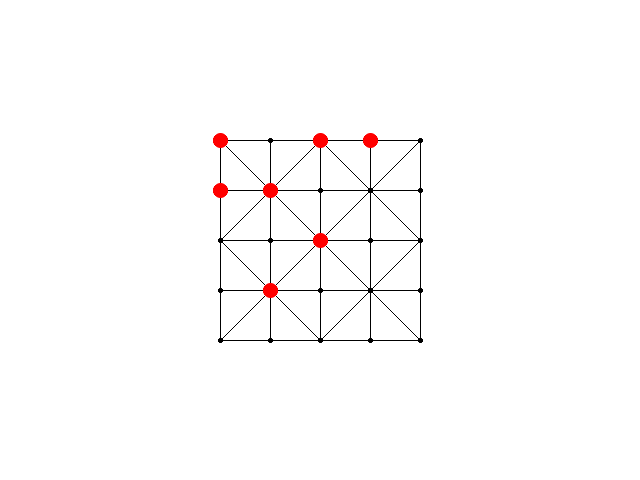

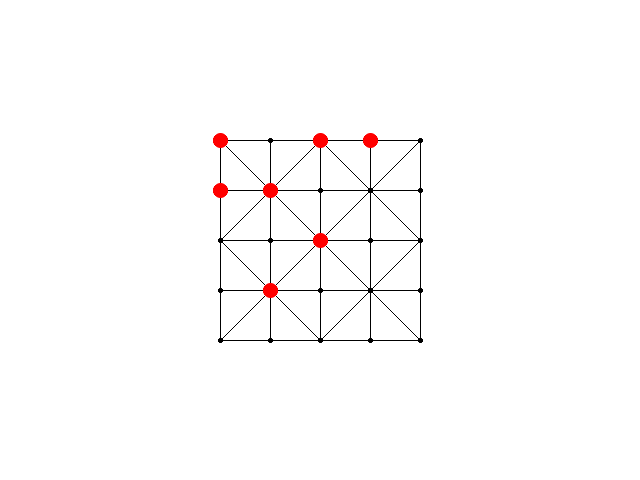

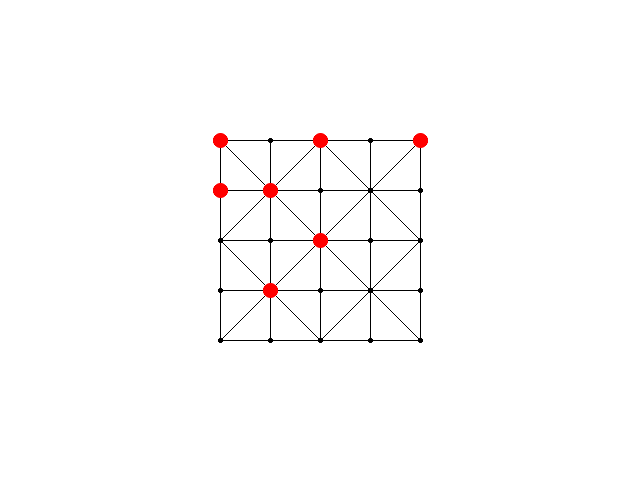

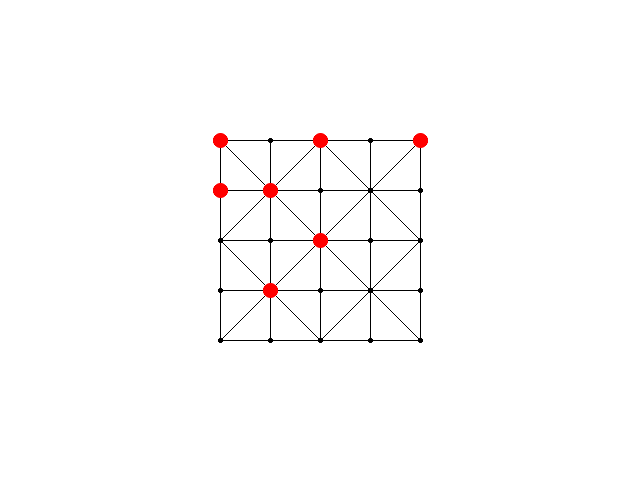

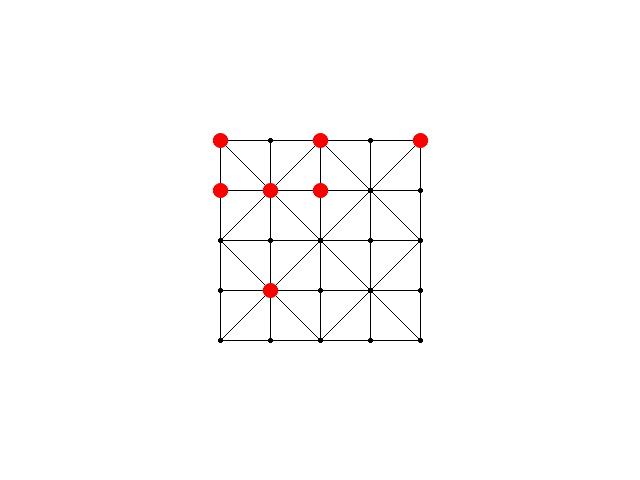

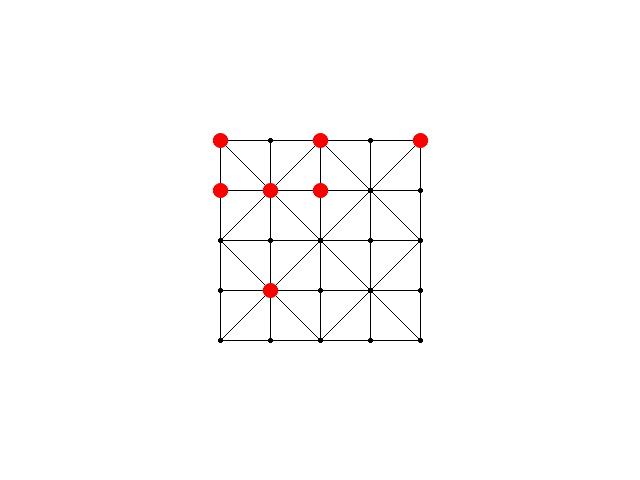

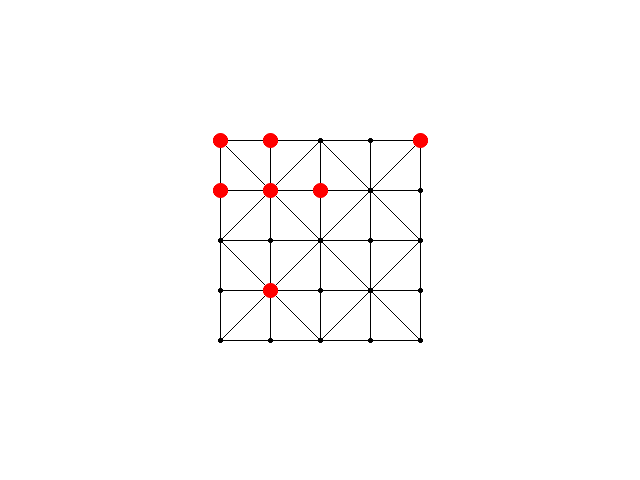

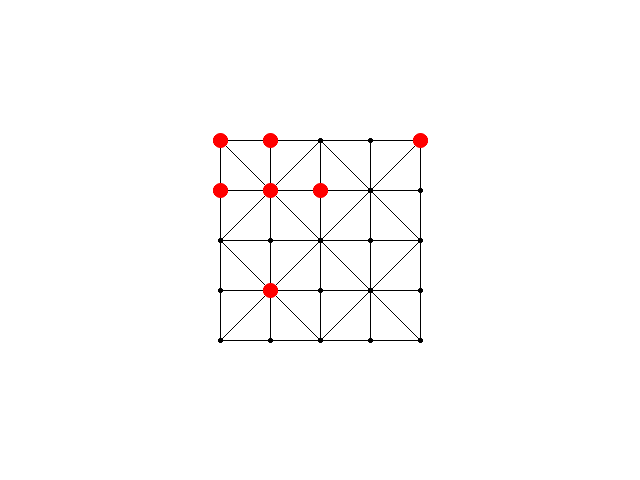

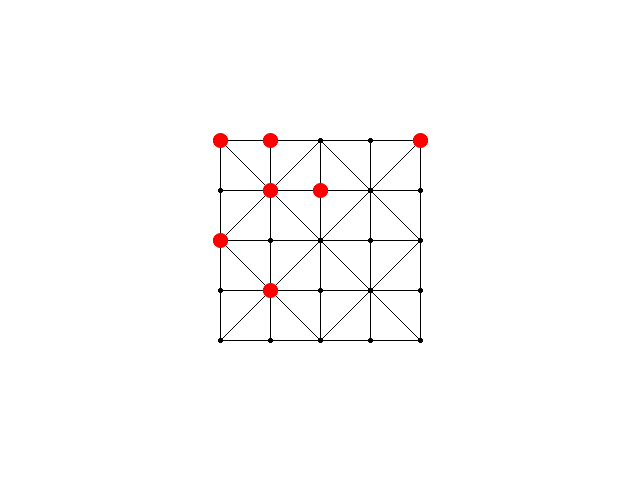

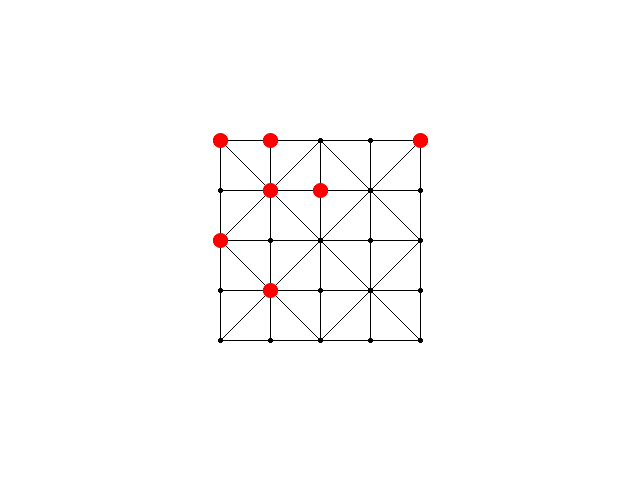

Player 1 wins


1

In [16]:
# example 3:
seed = 42
random.seed(seed)
player1 = Alpha_Beta_Pruning_Player(1, maxdepth=3)
player2 = Random_Player(2)
game = Game(player1, player2)
start_game(game, graphics=True)

### Time performance

In this part, we want to check time performance of alpha beta pruning vs minmax. It may take a little time to run :)

In [ ]:
seed = 42
random.seed(seed)
player_2 = Random_Player(2)
minimax_time = []
alpha_beta_time = []
for i in tqdm(range(4)):
  start = time.time()
  player_1 = Min_Max_Player(1, maxdepth=i + 1)
  game = Game(player_1, player_2)
  start_game(game, graphics=False)
  minimax_time.append(time.time() - start)

  start = time.time()
  player_1 = Alpha_Beta_Pruning_Player(1, maxdepth=i + 1)
  game = Game(player_1, player_2)
  start_game(game, graphics=False)
  alpha_beta_time.append(time.time() - start)

  0%|          | 0/4 [00:00<?, ?it/s]

Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins


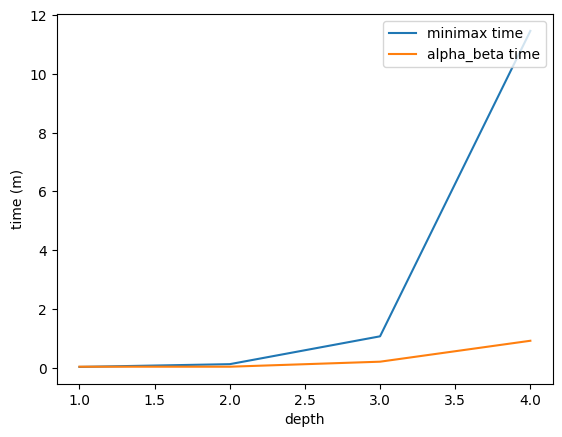

In [ ]:
plt.plot(list(range(1, len(minimax_time) + 1)), np.array(minimax_time) / 60, label="minimax time")
plt.plot(list(range(1, len(alpha_beta_time) + 1)), np.array(alpha_beta_time) / 60, label="alpha_beta time")
plt.legend(loc="upper right")
plt.xlabel('depth')
plt.ylabel('time (m)')
plt.show()

Now you can see how much alpha beta pruning has much better time performance (especially after depth = 3).

### Play for many times

Now we want to test alpha beta and minmax in 10 games and get number of wining. your score should so close to 20.

In [ ]:
def get_game_result(player_1, player_2, num_game):
    win, lose, draw = 0, 0, 0
    start = time.time()
    for i in tqdm(range(num_game)):
        random.seed()
        game = Game(player_1, player_2)
        result = start_game(game, graphics=False)
        if result == 1:
            win += 1
        elif result == 2:
            lose += 1
        else:
            draw += 1
    return win, lose, draw, (time.time() - start) / 60

def mark():
    player1 = Min_Max_Player(1, maxdepth=3)
    player2 = Random_Player(2)
    win1, lose1, draw1, t1 = get_game_result(player1, player2, 10)

    player1 = Alpha_Beta_Pruning_Player(1, maxdepth=3)
    player2 = Random_Player(2)
    win2, lose2, draw2, t2 = get_game_result(player1, player2, 10)
    print(f'minimax player vs random player win={win1}, lose={lose1}, draw={draw1}, time = {t1} m')
    print(f'alpha beta vs random player win={win2}, lose={lose2}, draw={draw2}, time = {t2} m')
    print(f'score: {win1 + win2}')
mark()

  0%|          | 0/10 [00:00<?, ?it/s]

Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins


  0%|          | 0/10 [00:00<?, ?it/s]

Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
minimax player vs random player win=10, lose=0, draw=0, time = 10.179719412326813 m
alpha beta vs random player win=10, lose=0, draw=0, time = 2.302063437302907 m
score: 20


In [ ]:
player1 = Random_Player(1)
player2 = Random_Player(2)
win2, lose2, draw2, t2 = get_game_result(player1, player2, 20)
print(f'random player win={win2}, lose={lose2}, draw={draw2}, time = {t2} m')

  0%|          | 0/20 [00:00<?, ?it/s]

Player 1 wins
Player 1 wins
Player 2 wins
Player 2 wins
Player 2 wins
Player 2 wins
Player 1 wins
It's a draw
Player 1 wins
Player 2 wins
Player 2 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 2 wins
Player 1 wins
Player 2 wins
Player 2 wins
Player 2 wins
Player 2 wins
random player win=8, lose=11, draw=1, time = 0.09593364795049032 m


# Extra score * (20 points)



## Expectimax
In previous sections, you consider your opponent play **min** for each step or action. In this part, you should consider your opponent that play random and implement expectimax algorithm.

In [ ]:
class Expectimax_Player(Player):
    def other_num(self):
        if self.number == 1:
             return 2
        return 1

    # imp 1 : heuristic score of this player - score of other player
    def choose_move_max(self, game, depth,this_player):
        pm = game.get_possible_moves()
        #cutoff or depth limit
        if depth == self.maxdepth or len(pm) == 0 : return game.get_player_score(self.number) - game.get_player_score(self.other_num())
        # copy game
        optimium = -1000000
        if not this_player:
            optimium = 0

        # find best move
        for move in game.get_possible_moves():
                game_copy = copy.deepcopy(game)
                game_copy.apply(move)
                game_copy.turn += 1
                val = self.choose_move_max(game_copy,depth + 1, not this_player)
                #max this player score
                if this_player and val > optimium:
                    optimium = val

                # enemy try to max his score
                if not this_player:
                    optimium += val

        # return best move and scores for each player.
        return optimium/len(pm)
    def next_move(self, game):
        """
        Parameters
        ----------
        game : `game.Game`
            An instance of `game.Game` encoding the current state of the
            game.

        Returns
        ----------
        (int, int) or None
            A randomly selected possible move.

        Useful functions:
        ----------
        game.get_possible_moves

        """
        max_val = -1000000
        best = None
        for move in game.get_possible_moves():
                game_copy = copy.deepcopy(game)
                game_copy.apply(move)
                game_copy.turn += 1
                val = self.choose_move_max(game_copy,1, False)
                if val > max_val:
                    max_val = val
                    best = move
        return best



Now you can see the results by running below cell. We excpect that the results approximatly to be similar below image.
<img
    src="https://gcdnb.pbrd.co/images/OgejM08bTJet.png?o=1"
/>


## Test

In [ ]:
def mark():
    player1 = Alpha_Beta_Pruning_Player(1, maxdepth=3)
    player2 = Alpha_Beta_Pruning_Player(2, maxdepth=1)
    win1, _, _, _ = get_game_result(player1, player2, 5)

    player1 = Alpha_Beta_Pruning_Player(1, maxdepth=3)
    player2 = Random_Player(2)
    win2, _, _, _ = get_game_result(player1, player2, 5)


    player1 = Expectimax_Player(1, maxdepth=3)
    player2 = Alpha_Beta_Pruning_Player(2, maxdepth=3)
    win3, _, _, _ = get_game_result(player1, player2, 5)

    player1 = Expectimax_Player(1, maxdepth=3)
    player2 = Random_Player(2)
    win4, _, _, _ = get_game_result(player1, player2, 5)

    return win1, win2 , win3, win4
result1, result2, result3 , result4 = mark()

  0%|          | 0/5 [00:00<?, ?it/s]

Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins


  0%|          | 0/5 [00:00<?, ?it/s]

Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins


  0%|          | 0/5 [00:00<?, ?it/s]

Player 2 wins
Player 2 wins
Player 2 wins
Player 2 wins
Player 2 wins


  0%|          | 0/5 [00:00<?, ?it/s]

Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins
Player 1 wins


In [ ]:
from prettytable import PrettyTable
myTab = PrettyTable([" ", "Adversarial", "Random"])
myTab.add_row(["Minimax", f'{result1} / 5', f'{result2} / 5'])
myTab.add_row(["Expectimax", f'{result3} / 5', f'{result4} / 5'])
print(myTab)

+------------+-------------+--------+
|            | Adversarial | Random |
+------------+-------------+--------+
|  Minimax   |    5 / 5    | 5 / 5  |
| Expectimax |    0 / 5    | 5 / 5  |
+------------+-------------+--------+
